In [4]:
import pandas
from pandas import read_excel, date_range, DatetimeIndex, DataFrame, to_numeric, concat, to_datetime
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas.tseries.offsets import DateOffset, MonthEnd, MonthBegin

import numpy
from numpy import logical_not

import statistics
import dateutil.relativedelta
from dateutil.relativedelta import relativedelta

import fbprophet
from fbprophet import Prophet

import calendar
from calendar import monthrange

from datetime import datetime, timedelta
from matplotlib import pyplot

from sklearn.metrics import mean_absolute_error, mean_squared_error

from math import sqrt

In [5]:
# cambiamos el valor de estos 4 parametros para que nos muestre dataframes sin truncarlos
pandas.set_option('display.max_rows', 12)
# pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

In [6]:
# Load data using read_excel
transacciones_df = read_excel('20210513 mmelero (249236).xlsx', sheet_name='Hoja1')
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría  \
0           2020-07-24    -1.20          84.0                 parking_84   
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117   
2           2020-07-23   -13.53          70.0           supermercados_70   
3           2020-07-22   -51.40         222.0                   adsl_222   
4           2020-07-22   -11.00          70.0           supermercados_70   
...                ...      ...           ...                        ...   
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18   
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126   
1484        2016-09-05  -138.08         125.0                 cuotas_125   
1485        2016-09-01   -32.22          90.0            seguro_salud_90   
1486        2016-09-01   -33.00         434.0                 cuotas_434   

      Nivel categoría  iD categoría padre Nombre categoría padre  \
0                 2.0                 5.0            vehiculos_5   
1                 2.0                 8.0    gastos_personales_8   
2                 2.0                 4.0         alimentacion_4   
3                 3.0               521.0    Comunicaciones y TV   
4                 2.0                 4.0         alimentacion_4   
...               ...                 ...                    ...   
1482              3.0               576.0                 Nómina   
1483              3.0               478.0   tarjetas_credito_478   
1484              3.0               127.0      otros_pasivos_127   
1485              2.0                 6.0                salud_6   
1486              3.0               115.0           deportes_115   

                    Proveedor               Marca  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                        SPAR                SPAR   
3                Jazz Telecom             Jazztel   
4                   Mercadona           Mercadona   
...                       ...                 ...   
1482                      NaN                 NaN   
1483                      NaN                 NaN   
1484                      NaN                 NaN   
1485  Sanitas S.A. de Seguros             Sanitas   
1486       Royal Sport Center  Royal Sport Center   

                            Sector  Financiero  Transferencia  Unnamed: 12  \
0                              NaN       False          False          NaN   
1                              NaN       False          False          NaN   
2                    Supermercados       False          False          NaN   
3     Compañías telecomunicaciones       False          False          NaN   
4                    Supermercados       False          False          NaN   
...                            ...         ...            ...          ...   
1482                           NaN       False          False          NaN   
1483                           NaN        True           True          NaN   
1484                           NaN        True          False          NaN   
1485              Seguros de salud        True          False          NaN   
1486              Clubs deportivos       False          False          NaN   

      Unnamed: 13        ID  BALANCE BALANCE_DATE  
0             NaN  249236.0  1478.98   2020-07-26  
1             NaN       NaN      NaN          NaT  
2             NaN       NaN      NaN          NaT  
3             NaN       NaN      NaN          NaT  
4             NaN       NaN      NaN          NaT  
...           ...       ...      ...          ...  
1482          NaN       NaN      NaN          NaT  
1483          NaN       NaN      NaN          NaT  
1484          NaN       NaN      NaN          NaT  
1485          NaN       NaN      NaN          NaT  
1486          NaN       NaN      NaN          NaT  

[1487 rows x 17 columns]

In [7]:
type(transacciones_df)

pandas.core.frame.DataFrame

In [227]:
# nos quedamos con categoria desde 'Fecha transacción' hasta 'Nombre Categoría'
transacciones_df=transacciones_df.iloc[:,0:4]
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría
0           2020-07-24    -1.20          84.0                 parking_84
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117
2           2020-07-23   -13.53          70.0           supermercados_70
3           2020-07-22   -51.40         222.0                   adsl_222
4           2020-07-22   -11.00          70.0           supermercados_70
...                ...      ...           ...                        ...
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126
1484        2016-09-05  -138.08         125.0                 cuotas_125
1485        2016-09-01   -32.22          90.0            seguro_salud_90
1486        2016-09-01   -33.00         434.0                 cuotas_434

[1487 rows x 4 columns]

In [228]:
# vamos a contar las veces que ocurre cada 'ID categoría' para así atacar las categorías que más aparecen en las transacciones

In [229]:
# hacemos un drop de 'Fecha transacción'
transacciones_df.drop(columns='Fecha transacción', inplace=True)
transacciones_df

Importe  ID Categoría           Nombre categoría
0       -1.20          84.0                 parking_84
1       -4.50         117.0  regalos_celebraciones_117
2      -13.53          70.0           supermercados_70
3      -51.40         222.0                   adsl_222
4      -11.00          70.0           supermercados_70
...       ...           ...                        ...
1482  1533.02          18.0     retribucion_liquida_18
1483  -617.47         126.0    liquidacion_tarjeta_126
1484  -138.08         125.0                 cuotas_125
1485   -32.22          90.0            seguro_salud_90
1486   -33.00         434.0                 cuotas_434

[1487 rows x 3 columns]

In [230]:
transacciones_df['num_observaciones'] = 1
transacciones_df

Importe  ID Categoría           Nombre categoría  num_observaciones
0       -1.20          84.0                 parking_84                  1
1       -4.50         117.0  regalos_celebraciones_117                  1
2      -13.53          70.0           supermercados_70                  1
3      -51.40         222.0                   adsl_222                  1
4      -11.00          70.0           supermercados_70                  1
...       ...           ...                        ...                ...
1482  1533.02          18.0     retribucion_liquida_18                  1
1483  -617.47         126.0    liquidacion_tarjeta_126                  1
1484  -138.08         125.0                 cuotas_125                  1
1485   -32.22          90.0            seguro_salud_90                  1
1486   -33.00         434.0                 cuotas_434                  1

[1487 rows x 4 columns]

In [231]:
transacciones_df.dtypes

Importe              float64
ID Categoría         float64
Nombre categoría      object
num_observaciones      int64
dtype: object

In [232]:
transacciones_df=transacciones_df.groupby(['ID Categoría','Nombre categoría']).sum(numeric_only=True)
transacciones_df

Importe  num_observaciones
ID Categoría Nombre categoría                                             
6.0          salud_6                             -35.00                  1
8.0          gastos_personales_8                 -42.22                  2
10.0         mascotas_10                        -552.18                 10
15.0         impuestos_15                      -2078.67                  4
18.0         retribucion_liquida_18            84808.76                 49
44.0         cuota_hipoteca_44                 -2529.33                  1
45.0         impuestos_municipales_45            -50.00                  1
49.0         reformas_mantenimiento_49            -9.99                  1
50.0         mobiliario_decoracion_50           -867.89                  5
51.0         electrodomesticos_electronica_51   -131.12                  4
53.0         gastos_aqluiler_53                -5650.00                 12
70.0         supermercados_70                  -6449.39                284
71.0         bazares_71                         -277.20                  9
73.0         consolas_73                        -119.90                  1
76.0         cuota_prestamo_vehiculo_76        -5441.40                 15
77.0         combustible_77                    -1317.94                 31
78.0         seguro_vehiculo_78                 -900.07                  5
80.0         reperaciones_mantenimientos_80     -435.16                  6
82.0         accesorios_82                        -7.38                  1
83.0         peajes_83                           -85.31                  9
84.0         parking_84                          -86.67                 43
85.0         lavado_85                           -47.40                  7
90.0         seguro_salud_90                   -2272.65                 59
91.0         consultas_privadas_91              -388.90                  6
95.0         farmacia_95                        -729.17                 36
96.0         otras_terapias_96                  -737.93                 10
102.0        asosiaciones_102                    -75.00                  1
109.0        ropa_complementos_109             -2032.29                 52
110.0        belleza_estetica_110               -604.66                 18
111.0        transporte_publico_111              -31.00                  1
113.0        Otros gastos personales           -1482.16                 47
115.0        deportes_115                       -135.95                 11
116.0        restaurantes_salidas_116          -2579.21                148
117.0        regalos_celebraciones_117         -1116.72                 29
118.0        viajes_118                           -5.00                  1
125.0        cuotas_125                        -2647.50                 22
126.0        liquidacion_tarjeta_126          -20176.45                 43
128.0        capital_128                        -100.00                  1
140.0        irpf_140                           7392.43                  7
214.0        agua_214                           -337.15                 12
219.0        gas_natural_219                   -2089.72                 24
222.0        adsl_222                          -1902.60                 30
238.0        itv_238                             -45.41                  1
242.0        reparaciones_242                   -250.00                  2
245.0        parking_245                          -8.50                  2
330.0        cuota_330                         -1899.21                 22
332.0        papeleria_332                        -5.95                  1
339.0        cuota_339                          -650.00                  3
419.0        cuota_419                          -884.64                 27
424.0        libros_revistas_periodicos_424      -50.60                  4
429.0        cine_teatro_conciertos_429          -24.00                  2
430.0        musica_video_430                    -23.97                  

In [233]:
# ordenamos categorias por num_observaciones descendente y luego por importe ascendente

In [234]:
transacciones_obs_df=transacciones_df.sort_values(by='num_observaciones', ascending=False, na_position='last')
transacciones_obs_df

Importe  num_observaciones
ID Categoría Nombre categoría                                             
70.0         supermercados_70                  -6449.39                284
116.0        restaurantes_salidas_116          -2579.21                148
461.0        movimiento_efectivo_461          -17902.44                113
508.0        comisioes_508                     -1590.23                103
90.0         seguro_salud_90                   -2272.65                 59
109.0        ropa_complementos_109             -2032.29                 52
18.0         retribucion_liquida_18            84808.76                 49
113.0        Otros gastos personales           -1482.16                 47
84.0         parking_84                          -86.67                 43
126.0        liquidacion_tarjeta_126          -20176.45                 43
95.0         farmacia_95                        -729.17                 36
434.0        cuotas_434                        -2124.35                 32
77.0         combustible_77                    -1317.94                 31
222.0        adsl_222                          -1902.60                 30
117.0        regalos_celebraciones_117         -1116.72                 29
462.0        Transferencias                    -4130.56                 27
419.0        cuota_419                          -884.64                 27
219.0        gas_natural_219                   -2089.72                 24
125.0        cuotas_125                        -2647.50                 22
330.0        cuota_330                         -1899.21                 22
472.0        loterias_472                       -370.69                 19
110.0        belleza_estetica_110               -604.66                 18
76.0         cuota_prestamo_vehiculo_76        -5441.40                 15
214.0        agua_214                           -337.15                 12
53.0         gastos_aqluiler_53                -5650.00                 12
115.0        deportes_115                       -135.95                 11
96.0         otras_terapias_96                  -737.93                 10
10.0         mascotas_10                        -552.18                 10
465.0        puericultura_465                   -306.38                 10
71.0         bazares_71                         -277.20                  9
83.0         peajes_83                           -85.31                  9
576.0        Nómina                             2308.17                  8
550.0        Ingreso en efectivo                 660.00                  8
140.0        irpf_140                           7392.43                  7
85.0         lavado_85                           -47.40                  7
91.0         consultas_privadas_91              -388.90                  6
80.0         reperaciones_mantenimientos_80     -435.16                  6
78.0         seguro_vehiculo_78                 -900.07                  5
50.0         mobiliario_decoracion_50           -867.89                  5
15.0         impuestos_15                      -2078.67                  4
424.0        libros_revistas_periodicos_424      -50.60                  4
51.0         electrodomesticos_electronica_51   -131.12                  4
443.0        hotel_alojamiento_443              -196.60                  4
430.0        musica_video_430                    -23.97                  3
339.0        cuota_339                          -650.00                  3
444.0        alimentacion_restauracion_444      -138.78                  3
245.0        parking_245                          -8.50                  2
242.0        reparaciones_242                   -250.00                  2
467.0        jardineria_467                      -20.05                  2
8.0          gastos_personales_8                 -42.22                  2
429.0        cine_teatro_conciertos_429          -24.00                  2
502.0        desayunos_menus_502                 -20.10                  

In [62]:
# nos guardamos el dataframe a un csv
transacciones_obs_df.to_excel('transacciones_obs_df.xlsx')

In [235]:
transacciones_importe_df=transacciones_df.sort_values(by='Importe', ascending=True, na_position='last')
transacciones_importe_df

Importe  num_observaciones
ID Categoría Nombre categoría                                             
126.0        liquidacion_tarjeta_126          -20176.45                 43
461.0        movimiento_efectivo_461          -17902.44                113
70.0         supermercados_70                  -6449.39                284
53.0         gastos_aqluiler_53                -5650.00                 12
76.0         cuota_prestamo_vehiculo_76        -5441.40                 15
462.0        Transferencias                    -4130.56                 27
125.0        cuotas_125                        -2647.50                 22
116.0        restaurantes_salidas_116          -2579.21                148
44.0         cuota_hipoteca_44                 -2529.33                  1
90.0         seguro_salud_90                   -2272.65                 59
434.0        cuotas_434                        -2124.35                 32
219.0        gas_natural_219                   -2089.72                 24
15.0         impuestos_15                      -2078.67                  4
109.0        ropa_complementos_109             -2032.29                 52
222.0        adsl_222                          -1902.60                 30
330.0        cuota_330                         -1899.21                 22
508.0        comisioes_508                     -1590.23                103
113.0        Otros gastos personales           -1482.16                 47
77.0         combustible_77                    -1317.94                 31
117.0        regalos_celebraciones_117         -1116.72                 29
78.0         seguro_vehiculo_78                 -900.07                  5
419.0        cuota_419                          -884.64                 27
50.0         mobiliario_decoracion_50           -867.89                  5
96.0         otras_terapias_96                  -737.93                 10
95.0         farmacia_95                        -729.17                 36
339.0        cuota_339                          -650.00                  3
110.0        belleza_estetica_110               -604.66                 18
10.0         mascotas_10                        -552.18                 10
438.0        alquiler_vehiculo_438              -548.58                  2
80.0         reperaciones_mantenimientos_80     -435.16                  6
91.0         consultas_privadas_91              -388.90                  6
472.0        loterias_472                       -370.69                 19
214.0        agua_214                           -337.15                 12
465.0        puericultura_465                   -306.38                 10
71.0         bazares_71                         -277.20                  9
242.0        reparaciones_242                   -250.00                  2
443.0        hotel_alojamiento_443              -196.60                  4
476.0        optica_476                         -140.00                  1
444.0        alimentacion_restauracion_444      -138.78                  3
115.0        deportes_115                       -135.95                 11
51.0         electrodomesticos_electronica_51   -131.12                  4
73.0         consolas_73                        -119.90                  1
128.0        capital_128                        -100.00                  1
84.0         parking_84                          -86.67                 43
83.0         peajes_83                           -85.31                  9
102.0        asosiaciones_102                    -75.00                  1
505.0        asesores_505                        -56.00                  1
424.0        libros_revistas_periodicos_424      -50.60                  4
45.0         impuestos_municipales_45            -50.00                  1
85.0         lavado_85                           -47.40                  7
238.0        itv_238                             -45.41                  1
436.0        equipamiento_ropa_deportiva_436     -43.97                  

In [64]:
# nos guardamos el dataframe a un csv
transacciones_importe_df.to_excel('transacciones_importe_df.xlsx')

In [236]:
# vemos que la categoria '70' de 'supermercados_70' es la 1a en numero de transacciones y la 3a en cuantia de las mismas así que
# vamos a quedarnos sólo como las transacciones de esta categoria y hacer un estudio estadistico temporal de las mismas

In [237]:
del(transacciones_df)

In [411]:
# Load data using read_excel
transacciones_df = read_excel('20210513 mmelero (249236).xlsx', sheet_name='Hoja1')
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría  \
0           2020-07-24    -1.20          84.0                 parking_84   
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117   
2           2020-07-23   -13.53          70.0           supermercados_70   
3           2020-07-22   -51.40         222.0                   adsl_222   
4           2020-07-22   -11.00          70.0           supermercados_70   
...                ...      ...           ...                        ...   
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18   
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126   
1484        2016-09-05  -138.08         125.0                 cuotas_125   
1485        2016-09-01   -32.22          90.0            seguro_salud_90   
1486        2016-09-01   -33.00         434.0                 cuotas_434   

      Nivel categoría  iD categoría padre Nombre categoría padre  \
0                 2.0                 5.0            vehiculos_5   
1                 2.0                 8.0    gastos_personales_8   
2                 2.0                 4.0         alimentacion_4   
3                 3.0               521.0    Comunicaciones y TV   
4                 2.0                 4.0         alimentacion_4   
...               ...                 ...                    ...   
1482              3.0               576.0                 Nómina   
1483              3.0               478.0   tarjetas_credito_478   
1484              3.0               127.0      otros_pasivos_127   
1485              2.0                 6.0                salud_6   
1486              3.0               115.0           deportes_115   

                    Proveedor               Marca  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                        SPAR                SPAR   
3                Jazz Telecom             Jazztel   
4                   Mercadona           Mercadona   
...                       ...                 ...   
1482                      NaN                 NaN   
1483                      NaN                 NaN   
1484                      NaN                 NaN   
1485  Sanitas S.A. de Seguros             Sanitas   
1486       Royal Sport Center  Royal Sport Center   

                            Sector  Financiero  Transferencia  Unnamed: 12  \
0                              NaN       False          False          NaN   
1                              NaN       False          False          NaN   
2                    Supermercados       False          False          NaN   
3     Compañías telecomunicaciones       False          False          NaN   
4                    Supermercados       False          False          NaN   
...                            ...         ...            ...          ...   
1482                           NaN       False          False          NaN   
1483                           NaN        True           True          NaN   
1484                           NaN        True          False          NaN   
1485              Seguros de salud        True          False          NaN   
1486              Clubs deportivos       False          False          NaN   

      Unnamed: 13        ID  BALANCE BALANCE_DATE  
0             NaN  249236.0  1478.98   2020-07-26  
1             NaN       NaN      NaN          NaT  
2             NaN       NaN      NaN          NaT  
3             NaN       NaN      NaN          NaT  
4             NaN       NaN      NaN          NaT  
...           ...       ...      ...          ...  
1482          NaN       NaN      NaN          NaT  
1483          NaN       NaN      NaN          NaT  
1484          NaN       NaN      NaN          NaT  
1485          NaN       NaN      NaN          NaT  
1486          NaN       NaN      NaN          NaT  

[1487 rows x 17 columns]

In [412]:
# nos quedamos con categoria desde 'Fecha transacción' hasta 'Nombre Categoría'
transacciones_df=transacciones_df.iloc[:,0:4]
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría
0           2020-07-24    -1.20          84.0                 parking_84
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117
2           2020-07-23   -13.53          70.0           supermercados_70
3           2020-07-22   -51.40         222.0                   adsl_222
4           2020-07-22   -11.00          70.0           supermercados_70
...                ...      ...           ...                        ...
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126
1484        2016-09-05  -138.08         125.0                 cuotas_125
1485        2016-09-01   -32.22          90.0            seguro_salud_90
1486        2016-09-01   -33.00         434.0                 cuotas_434

[1487 rows x 4 columns]

In [413]:
# nos quedamos con las transacciones de la categoria 'supermercados_70'
transacciones_super_df=transacciones_df[transacciones_df['ID Categoría'] == 70.0]
transacciones_super_df

Fecha transacción  Importe  ID Categoría  Nombre categoría
2           2020-07-23   -13.53          70.0  supermercados_70
4           2020-07-22   -11.00          70.0  supermercados_70
6           2020-07-22   -73.77          70.0  supermercados_70
9           2020-07-20   -16.17          70.0  supermercados_70
12          2020-07-20   -14.75          70.0  supermercados_70
...                ...      ...           ...               ...
1427        2016-11-03   -18.21          70.0  supermercados_70
1436        2016-10-25  -147.50          70.0  supermercados_70
1444        2016-10-24   -21.48          70.0  supermercados_70
1456        2016-10-11    -8.74          70.0  supermercados_70
1465        2016-10-06    -8.58          70.0  supermercados_70

[284 rows x 4 columns]

In [414]:
# quitamos las columnas de 'ID Categoría' y 'Nombre Categoría' que ya no me aportan nada
transacciones_super_df.drop(columns=['ID Categoría', 'Nombre categoría'], inplace=True)
transacciones_super_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Fecha transacción  Importe
2           2020-07-23   -13.53
4           2020-07-22   -11.00
6           2020-07-22   -73.77
9           2020-07-20   -16.17
12          2020-07-20   -14.75
...                ...      ...
1427        2016-11-03   -18.21
1436        2016-10-25  -147.50
1444        2016-10-24   -21.48
1456        2016-10-11    -8.74
1465        2016-10-06    -8.58

[284 rows x 2 columns]

In [415]:
# renombramos columnas
transacciones_super_df.rename(columns={'Fecha transacción': 'FECHA', 'Importe': 'IMPORTE'}, inplace=True)
transacciones_super_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


FECHA  IMPORTE
2    2020-07-23   -13.53
4    2020-07-22   -11.00
6    2020-07-22   -73.77
9    2020-07-20   -16.17
12   2020-07-20   -14.75
...         ...      ...
1427 2016-11-03   -18.21
1436 2016-10-25  -147.50
1444 2016-10-24   -21.48
1456 2016-10-11    -8.74
1465 2016-10-06    -8.58

[284 rows x 2 columns]

In [416]:
# ordenamos las fechas por orden ascendente
transacciones_super_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)
transacciones_super_df

<ipython-input-416-8ed63b426aa3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transacciones_super_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)


FECHA  IMPORTE
0   2016-10-06    -8.58
1   2016-10-11    -8.74
2   2016-10-24   -21.48
3   2016-10-25  -147.50
4   2016-11-03   -18.21
..         ...      ...
279 2020-07-20   -14.75
280 2020-07-20   -16.17
281 2020-07-22   -73.77
282 2020-07-22   -11.00
283 2020-07-23   -13.53

[284 rows x 2 columns]

In [417]:
# vamos a agrupar los valores y sumarlos por fecha

In [418]:
transacciones_super_df=transacciones_super_df.groupby(['FECHA']).sum()
transacciones_super_df

IMPORTE
FECHA              
2016-10-06    -8.58
2016-10-11    -8.74
2016-10-24   -21.48
2016-10-25  -147.50
2016-11-03   -18.21
...             ...
2020-07-15    -6.61
2020-07-17   -12.72
2020-07-20   -30.92
2020-07-22   -84.77
2020-07-23   -13.53

[214 rows x 1 columns]

In [419]:
# rellenamos con ceros las fechas que faltan

In [420]:
transacciones_super_ser = transacciones_super_df.T.squeeze()
transacciones_super_ser

FECHA
2016-10-06     -8.58
2016-10-11     -8.74
2016-10-24    -21.48
2016-10-25   -147.50
2016-11-03    -18.21
               ...  
2020-07-15     -6.61
2020-07-17    -12.72
2020-07-20    -30.92
2020-07-22    -84.77
2020-07-23    -13.53
Name: IMPORTE, Length: 214, dtype: float64

In [421]:
transacciones_super_df.index.min(), transacciones_super_df.index.max()

(Timestamp('2016-10-06 00:00:00'), Timestamp('2020-07-23 00:00:00'))

In [422]:
idx = date_range(transacciones_super_df.index.min(), transacciones_super_df.index.max())
idx

DatetimeIndex(['2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09',
               '2016-10-10', '2016-10-11', '2016-10-12', '2016-10-13',
               '2016-10-14', '2016-10-15',
               ...
               '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
               '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
               '2020-07-22', '2020-07-23'],
              dtype='datetime64[ns]', length=1387, freq='D')

In [423]:
transacciones_super_ser.index = pandas.DatetimeIndex(transacciones_super_ser.index)
transacciones_super_ser.index

DatetimeIndex(['2016-10-06', '2016-10-11', '2016-10-24', '2016-10-25',
               '2016-11-03', '2016-11-07', '2016-11-15', '2016-11-16',
               '2016-11-17', '2016-11-21',
               ...
               '2020-06-15', '2020-06-29', '2020-07-01', '2020-07-07',
               '2020-07-09', '2020-07-15', '2020-07-17', '2020-07-20',
               '2020-07-22', '2020-07-23'],
              dtype='datetime64[ns]', name='FECHA', length=214, freq=None)

In [424]:
transacciones_super_ser = transacciones_super_ser.reindex(idx, fill_value=0)
transacciones_super_ser

2016-10-06    -8.58
2016-10-07     0.00
2016-10-08     0.00
2016-10-09     0.00
2016-10-10     0.00
              ...  
2020-07-19     0.00
2020-07-20   -30.92
2020-07-21     0.00
2020-07-22   -84.77
2020-07-23   -13.53
Freq: D, Name: IMPORTE, Length: 1387, dtype: float64

In [425]:
transacciones_super_df = DataFrame(transacciones_super_ser)
transacciones_super_df

IMPORTE
2016-10-06    -8.58
2016-10-07     0.00
2016-10-08     0.00
2016-10-09     0.00
2016-10-10     0.00
...             ...
2020-07-19     0.00
2020-07-20   -30.92
2020-07-21     0.00
2020-07-22   -84.77
2020-07-23   -13.53

[1387 rows x 1 columns]

In [426]:
transacciones_super_df=transacciones_super_df.multiply(other=-1, axis='columns')
transacciones_super_df

IMPORTE
2016-10-06     8.58
2016-10-07    -0.00
2016-10-08    -0.00
2016-10-09    -0.00
2016-10-10    -0.00
...             ...
2020-07-19    -0.00
2020-07-20    30.92
2020-07-21    -0.00
2020-07-22    84.77
2020-07-23    13.53

[1387 rows x 1 columns]

In [427]:
transacciones_super_df=transacciones_super_df.add(other=0, axis='columns')
transacciones_super_df

IMPORTE
2016-10-06     8.58
2016-10-07     0.00
2016-10-08     0.00
2016-10-09     0.00
2016-10-10     0.00
...             ...
2020-07-19     0.00
2020-07-20    30.92
2020-07-21     0.00
2020-07-22    84.77
2020-07-23    13.53

[1387 rows x 1 columns]

In [1]:
#vamos a explorar un poco los datos

In [429]:
transacciones_super_df.size

1387

In [430]:
transacciones_super_df.shape

(1387, 1)

In [431]:
transacciones_super_df.describe()

IMPORTE
count  1387.000000
mean      4.649885
std      18.416815
min    -148.830000
25%       0.000000
50%       0.000000
75%       0.000000
max     169.830000

In [432]:
statistics.mode(transacciones_super_df['IMPORTE'])

0.0

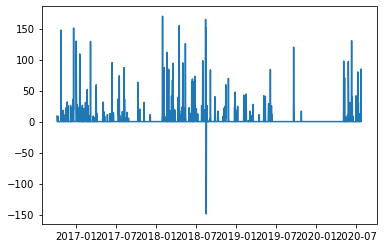

In [433]:
pyplot.plot(transacciones_super_df)
pyplot.show()

In [434]:
"""
Vemos como la mayor parte de las transacciones son de poco valor 
q1 = q2 = q3 = mode = 0 eur
mean = 4.64 eur
std = 18.41 eur

este analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur
"""

'\nVemos como la mayor parte de las transacciones son de poco valor \nq1 = q2 = q3 = mode = 0 eur\nmean = 4.64 eur\nstd = 18.41 eur\n\neste analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur\n'

In [435]:
# 1 time series plot

In [436]:
transacciones_super_ser = transacciones_super_df.T.squeeze()
transacciones_super_ser

2016-10-06     8.58
2016-10-07     0.00
2016-10-08     0.00
2016-10-09     0.00
2016-10-10     0.00
              ...  
2020-07-19     0.00
2020-07-20    30.92
2020-07-21     0.00
2020-07-22    84.77
2020-07-23    13.53
Freq: D, Name: IMPORTE, Length: 1387, dtype: float64

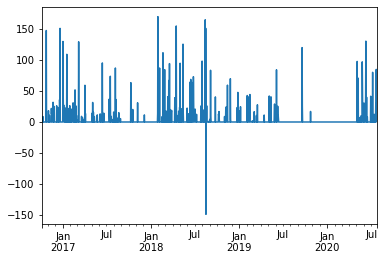

In [437]:
transacciones_super_ser.plot()
pyplot.show()

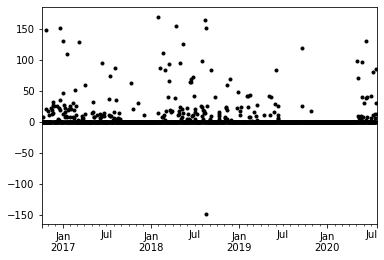

In [438]:
transacciones_super_ser.plot(style='.', color='black')
pyplot.show()

In [439]:
# 2 Time Series Histogram and Density Plots

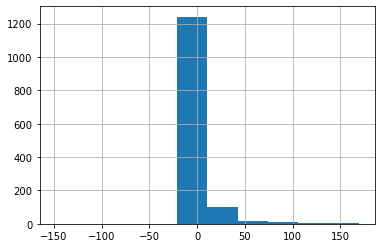

In [440]:
transacciones_super_ser.hist()
pyplot.show()

In [441]:
"""
el histograma confirma lo que ya sabiamos que casi todas las compras son de poco valor porque ademas la transaccion mas comun
es 0 eur.

q1 = q2 = q3 = mode = 0 eur
mean = 4.64 eur
std = 18.41 eur

este analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur
"""

'\nel histograma confirma lo que ya sabiamos que casi todas las compras son de poco valor porque ademas la transaccion mas comun\nes 0 eur.\n\nq1 = q2 = q3 = mode = 0 eur\nmean = 4.64 eur\nstd = 18.41 eur\n\neste analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur\n'

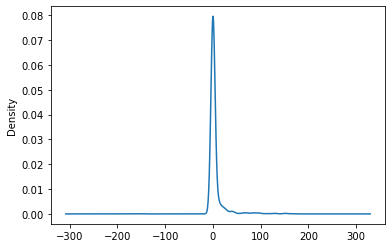

In [442]:
transacciones_super_ser.plot(kind='kde')
pyplot.show()

In [443]:
"""
el diagrama de densidad confirma y acentua las conclusiones del histograma

q1 = q2 = q3 = mode = 0 eur
mean = 4.64 eur
std = 18.41 eur

este analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur
"""

'\nel diagrama de densidad confirma y acentua las conclusiones del histograma\n\nq1 = q2 = q3 = mode = 0 eur\nmean = 4.64 eur\nstd = 18.41 eur\n\neste analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur\n'

In [444]:
# 3. Time Series Box and Whisker Plots by Interval

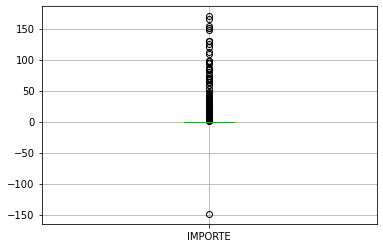

In [445]:
transacciones_super_df.boxplot()
pyplot.show()

In [446]:
"""
en linea con las conclusiones de los graficos anterior. todas aquellas transacciones de mas de 0 eur son tomadas como outliers
q1 = q2 = q3 = mode = 0 eur
iqr = 0 eur
q3 + 1.5*iqr = 0
q1 + 1.5*iqr = 0

mean = 4.64 eur
std = 18.41 eur

este analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur
"""

'\nen linea con las conclusiones de los graficos anterior. todas aquellas transacciones de mas de 0 eur son tomadas como outliers\nq1 = q2 = q3 = mode = 0 eur\niqr = 0 eur\nq3 + 1.5*iqr = 0\nq1 + 1.5*iqr = 0\n\nmean = 4.64 eur\nstd = 18.41 eur\n\neste analisis estadistico es correcto pero no es significativo pues la mayor parte de los días hay una transaccion de 0 eur\n'

In [447]:
# 4. Time Series Heat Maps

In [448]:
pyplot.matshow(transacciones_super_ser, interpolation=None, aspect='auto')
pyplot.show()

ValueError: not enough values to unpack (expected 2, got 1)

In [449]:
"""
para hacer heat maps necesito presentar los valores agrupados por 2 dimensiones (año, dia) o (mes, dia)
y como no he separado los años en transacciones_super_ser solo los tengo presentados por dia
"""

'\npara hacer heat maps necesito presentar los valores agrupados por 2 dimensiones (año, dia) o (mes, dia)\ny como no he separado los años en transacciones_super_ser solo los tengo presentados por dia\n'

In [450]:
# 5. Time Series Lag Scatter Plots

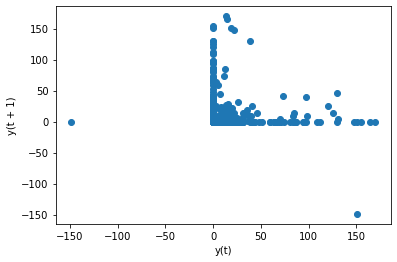

In [451]:
lag_plot(transacciones_super_ser)
pyplot.show()

In [452]:
"""
no hay correlacion entre y(t+1) e y(t)
"""

'\nno hay correlacion entre y(t+1) e y(t)\n'

In [453]:
# vamos a hacer lagplots entre y(t+1) y sus 31 lags anteriores hasta y(t-31)

t+1 vs t-1


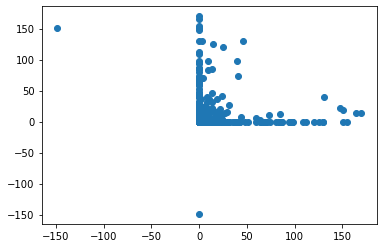

t+1 vs t-2


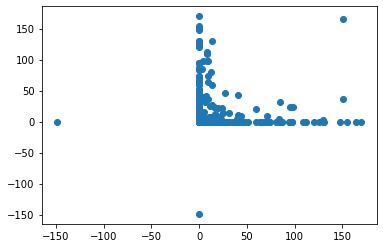

t+1 vs t-3


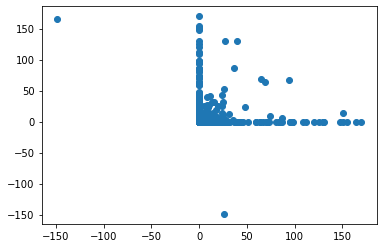

t+1 vs t-4


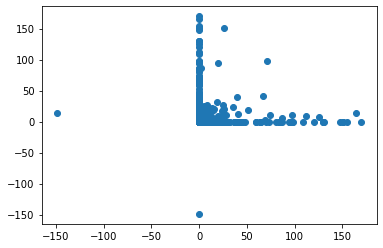

t+1 vs t-5


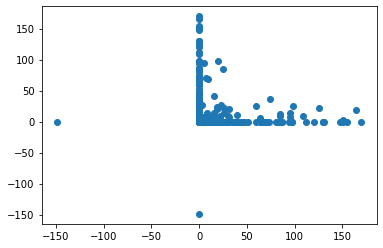

t+1 vs t-6


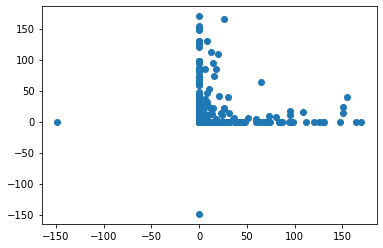

t+1 vs t-7


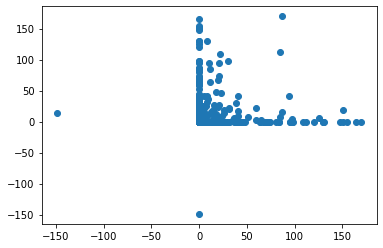

t+1 vs t-8


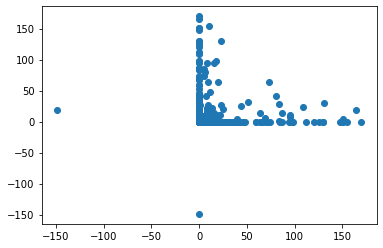

t+1 vs t-9


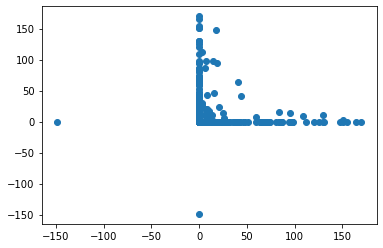

t+1 vs t-10


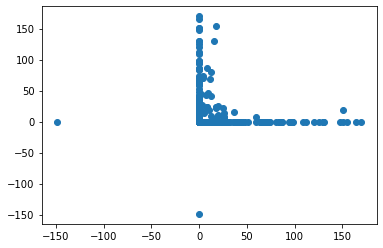

t+1 vs t-11


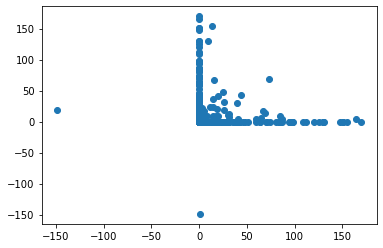

t+1 vs t-12


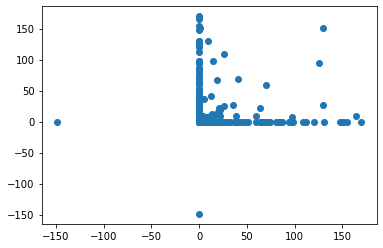

t+1 vs t-13


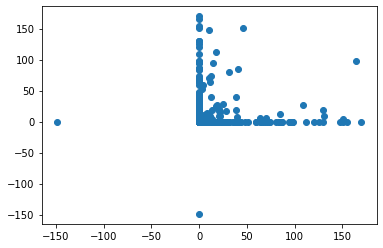

t+1 vs t-14


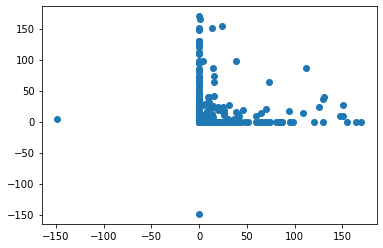

t+1 vs t-15


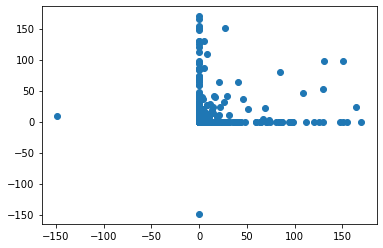

t+1 vs t-16


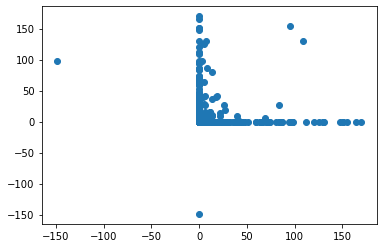

t+1 vs t-17


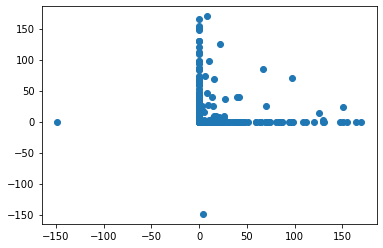

t+1 vs t-18


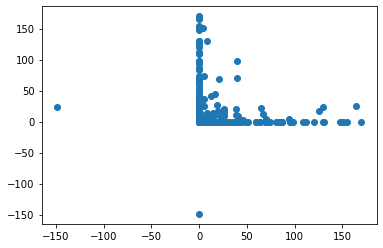

t+1 vs t-19


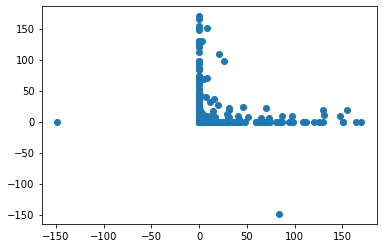

t+1 vs t-20


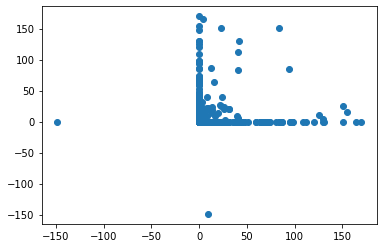

t+1 vs t-21


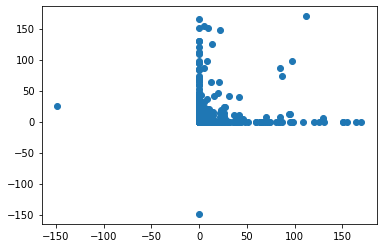

t+1 vs t-22


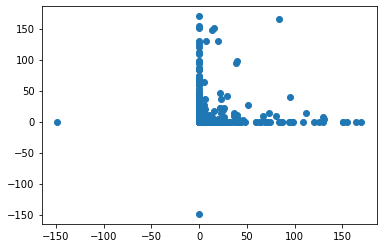

t+1 vs t-23


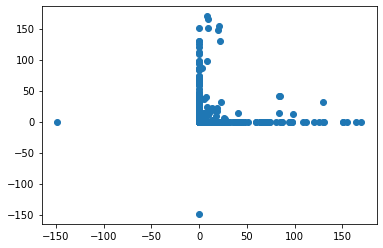

t+1 vs t-24


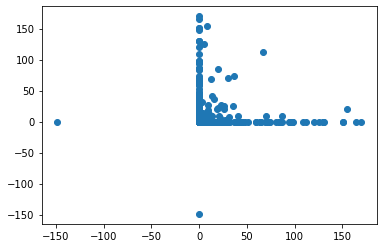

t+1 vs t-25


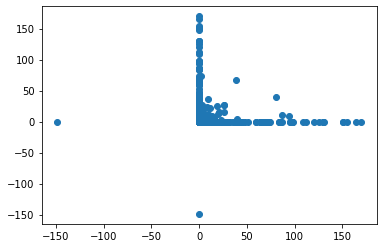

t+1 vs t-26


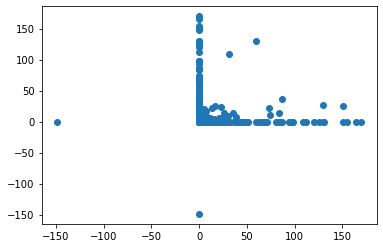

t+1 vs t-27


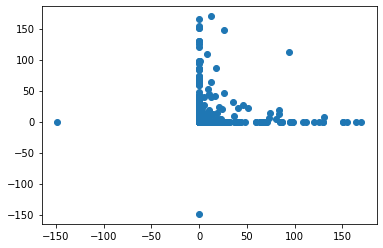

t+1 vs t-28


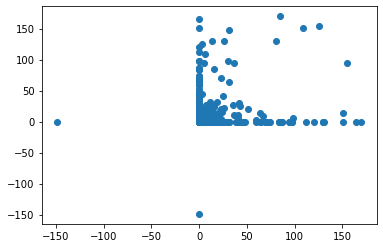

t+1 vs t-29


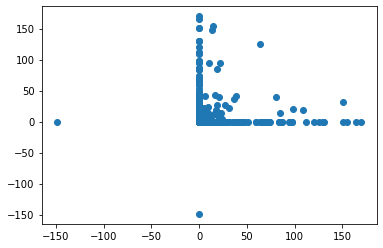

t+1 vs t-30


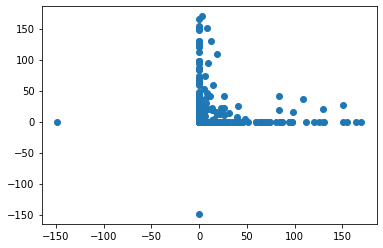

t+1 vs t-31


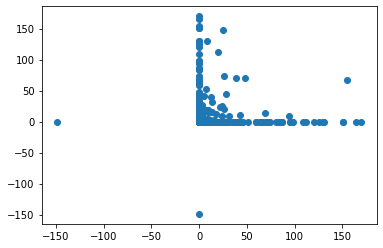

In [454]:
values = DataFrame(transacciones_super_ser.values)
lags = 31
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
for i in range(1,(lags + 1)):
	print('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
	pyplot.show()

In [455]:
"""
no hay correlacion entre y(t+1) y sus 31 lags anteriores
"""

'\nno hay correlacion entre y(t+1) y sus 31 lags anteriores\n'

In [456]:
# 6. Time Series Autocorrelation Plots

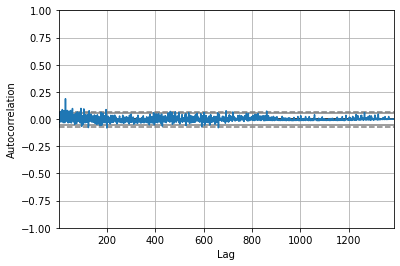

In [457]:
autocorrelation_plot(transacciones_super_ser)
pyplot.show()

In [458]:
"""
no hay correlacion significativa entre y(t+1) y sus 1600 lags anteiores.
como mucho con uno de sus 1os lags pero esta correlacion es debil e inferior a 0.25
"""

'\nno hay correlacion significativa entre y(t+1) y sus 1600 lags anteiores.\ncomo mucho con uno de sus 1os lags pero esta correlacion es debil e inferior a 0.25\n'

In [459]:
# agrupamos las observaciones por semanas y sumalas

In [460]:
transacciones_super_df

IMPORTE
2016-10-06     8.58
2016-10-07     0.00
2016-10-08     0.00
2016-10-09     0.00
2016-10-10     0.00
...             ...
2020-07-19     0.00
2020-07-20    30.92
2020-07-21     0.00
2020-07-22    84.77
2020-07-23    13.53

[1387 rows x 1 columns]

In [461]:
transacciones_super_df.index

DatetimeIndex(['2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09',
               '2016-10-10', '2016-10-11', '2016-10-12', '2016-10-13',
               '2016-10-14', '2016-10-15',
               ...
               '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
               '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
               '2020-07-22', '2020-07-23'],
              dtype='datetime64[ns]', length=1387, freq='D')

In [462]:
weeks_df = transacciones_super_df.index.isocalendar()
weeks_df

year  week  day
2016-10-06  2016    40    4
2016-10-07  2016    40    5
2016-10-08  2016    40    6
2016-10-09  2016    40    7
2016-10-10  2016    41    1
...          ...   ...  ...
2020-07-19  2020    29    7
2020-07-20  2020    30    1
2020-07-21  2020    30    2
2020-07-22  2020    30    3
2020-07-23  2020    30    4

[1387 rows x 3 columns]

In [463]:
transacciones_super_weeks_df=transacciones_super_df.merge(weeks_df, how='inner', left_index=True, right_index=True)
transacciones_super_weeks_df

IMPORTE  year  week  day
2016-10-06     8.58  2016    40    4
2016-10-07     0.00  2016    40    5
2016-10-08     0.00  2016    40    6
2016-10-09     0.00  2016    40    7
2016-10-10     0.00  2016    41    1
...             ...   ...   ...  ...
2020-07-19     0.00  2020    29    7
2020-07-20    30.92  2020    30    1
2020-07-21     0.00  2020    30    2
2020-07-22    84.77  2020    30    3
2020-07-23    13.53  2020    30    4

[1387 rows x 4 columns]

In [464]:
transacciones_super_weeks_df.dtypes

IMPORTE    float64
year        UInt32
week        UInt32
day         UInt32
dtype: object

In [465]:
transacciones_super_weeks_df['year_str'] = transacciones_super_weeks_df['year']
transacciones_super_weeks_df['week_str'] = transacciones_super_weeks_df['week']
transacciones_super_weeks_df

IMPORTE  year  week  day  year_str  week_str
2016-10-06     8.58  2016    40    4      2016        40
2016-10-07     0.00  2016    40    5      2016        40
2016-10-08     0.00  2016    40    6      2016        40
2016-10-09     0.00  2016    40    7      2016        40
2016-10-10     0.00  2016    41    1      2016        41
...             ...   ...   ...  ...       ...       ...
2020-07-19     0.00  2020    29    7      2020        29
2020-07-20    30.92  2020    30    1      2020        30
2020-07-21     0.00  2020    30    2      2020        30
2020-07-22    84.77  2020    30    3      2020        30
2020-07-23    13.53  2020    30    4      2020        30

[1387 rows x 6 columns]

In [466]:
# vamos a cambiar de estrategia y hacerlo de otra manera para agrupar por semanas y sumar

# asi que para empezar voy a eliminar todas las columnas menos la del IMPORTE
transacciones_super_weeks_df.drop(columns=['year','week','day','year_str','week_str'], inplace=True)
transacciones_super_weeks_df

IMPORTE
2016-10-06     8.58
2016-10-07     0.00
2016-10-08     0.00
2016-10-09     0.00
2016-10-10     0.00
...             ...
2020-07-19     0.00
2020-07-20    30.92
2020-07-21     0.00
2020-07-22    84.77
2020-07-23    13.53

[1387 rows x 1 columns]

In [467]:
transacciones_super_weeks_df['FECHA'] = transacciones_super_weeks_df.index
transacciones_super_weeks_df

IMPORTE      FECHA
2016-10-06     8.58 2016-10-06
2016-10-07     0.00 2016-10-07
2016-10-08     0.00 2016-10-08
2016-10-09     0.00 2016-10-09
2016-10-10     0.00 2016-10-10
...             ...        ...
2020-07-19     0.00 2020-07-19
2020-07-20    30.92 2020-07-20
2020-07-21     0.00 2020-07-21
2020-07-22    84.77 2020-07-22
2020-07-23    13.53 2020-07-23

[1387 rows x 2 columns]

In [468]:
transacciones_super_weeks_df.dtypes

IMPORTE           float64
FECHA      datetime64[ns]
dtype: object

In [469]:
# First substract one week, as we want to sum for the week ahead of the date, not the week before that date.
transacciones_super_weeks_df['FECHA'] = transacciones_super_weeks_df['FECHA'] - timedelta(days=7)
transacciones_super_weeks_df

IMPORTE      FECHA
2016-10-06     8.58 2016-09-29
2016-10-07     0.00 2016-09-30
2016-10-08     0.00 2016-10-01
2016-10-09     0.00 2016-10-02
2016-10-10     0.00 2016-10-03
...             ...        ...
2020-07-19     0.00 2020-07-12
2020-07-20    30.92 2020-07-13
2020-07-21     0.00 2020-07-14
2020-07-22    84.77 2020-07-15
2020-07-23    13.53 2020-07-16

[1387 rows x 2 columns]

In [470]:
# Then use groupby with Grouper by W-MON and aggregate sum.

In [471]:
transacciones_super_weeks_df = transacciones_super_weeks_df.resample('W-Mon', on='FECHA').sum()
transacciones_super_weeks_df

IMPORTE
FECHA              
2016-10-03     8.58
2016-10-10     8.74
2016-10-17    21.48
2016-10-24   147.50
2016-10-31    29.04
...             ...
2020-06-22    41.52
2020-06-29     6.83
2020-07-06    92.12
2020-07-13    50.25
2020-07-20    98.30

[199 rows x 1 columns]

In [472]:
#hemos agrupado los gastos por semana y se los hemos asignado al lunes de la semana a la que pertenece el gasto

# ahora que tenemos el gasto en supermercados agrupado por semanas vamos a pintar la serie y hacer el estudio estadistico

In [473]:
# Lesson 02: Load Time Series Data
# How to Load and Explore Time Series Data in Python
# https://machinelearningmastery.com/load-explore-time-series-data-python/

In [474]:
transacciones_super_weeks_df.size

199

In [475]:
transacciones_super_weeks_df.shape

(199, 1)

In [476]:
transacciones_super_weeks_df.describe()

IMPORTE
count  199.000000
mean    32.408995
std     47.650403
min      0.000000
25%      0.000000
50%      8.830000
75%     48.200000
max    197.460000

In [477]:
"""
cada semana gasta de media 32.4 eur
mean = 32.4 eur
std = 47.65 eur
el 68% de las semanas gasta entre 0 y 80.05 eur
el 99.5% gasta entre 0 y 127.7 eur
q1 (25%) = 0 eur
q2 (50%) = 8.83 eur
q3 (75%) = 48.2 eur
"""

'\ncada semana gasta de media 32.4 eur\nmean = 32.4 eur\nstd = 47.65 eur\nel 68% de las semanas gasta entre 0 y 80.05 eur\nel 99.5% gasta entre 0 y 127.7 eur\nq1 (25%) = 0 eur\nq2 (50%) = 8.83 eur\nq3 (75%) = 48.2 eur\n'

In [478]:
statistics.mode(transacciones_super_weeks_df['IMPORTE'])

0.0

In [479]:
"""
la moda son 0 eur 
min = q1 (25%) = moda = 0 eur
"""

'\nla moda son 0 eur \nmin = q1 (25%) = moda = 0 eur\n'

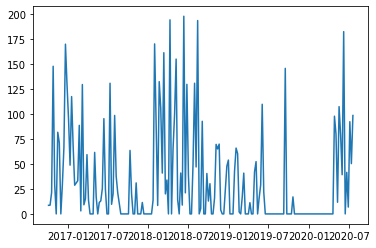

In [480]:
pyplot.plot(transacciones_super_weeks_df)
pyplot.show()

In [481]:
# Lesson 03: Data Visualization
# Time Series Data Visualization with Python
# https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [482]:
# 1. Time Series Line Plot

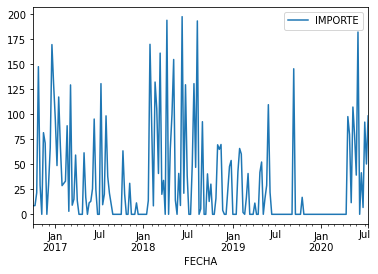

In [483]:
transacciones_super_weeks_df.plot()
pyplot.show()

In [484]:
"""
quiza por meses la grafica del gasto seria mas suave pero con menos observaciones la serie temporal seria mucho más dificil de
calcular
"""

'\nquiza por meses la grafica del gasto seria mas suave pero con menos observaciones la serie temporal seria mucho más dificil de\ncalcular\n'

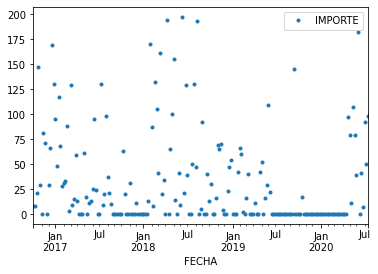

In [485]:
transacciones_super_weeks_df.plot(style='.')
pyplot.show()

In [486]:
# TODO: 
# dejamos el estudio comparativo por años de las graficas entre 2017 y 2019 para más adelante porque necesito años completos

In [487]:
# 2. Time Series Histogram and Density Plots

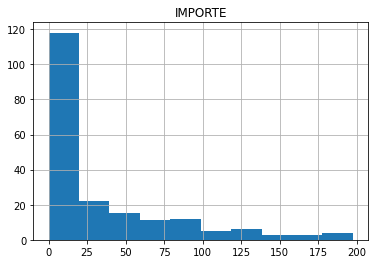

In [488]:
transacciones_super_weeks_df.hist()
pyplot.show()

In [489]:
transacciones_super_weeks_df.describe()

IMPORTE
count  199.000000
mean    32.408995
std     47.650403
min      0.000000
25%      0.000000
50%      8.830000
75%     48.200000
max    197.460000

In [501]:
statistics.mode(transacciones_super_weeks_df['IMPORTE'])

0.0

In [491]:
"""
El histograma confirma las conclusiones del análisis de los estadisticos de la distribucion.

El 50% de las transacciones son inferiores a 8.83 eur y el 75% de las transacciones inferiores a 45.2 eur.

La moda de la distribucion son 0 eur que es el valor claramente más repetido si se mira la evolución de la grafica del gasto a
lo largo del tiempo.
"""

'\nEl histograma confirma las conclusiones del análisis de los estadisticos de la distribucion.\n\nEl 50% de las transacciones son inferiores a 8.83 eur y el 75% de las transacciones inferiores a 45.2 eur.\n\nLa moda de la distribucion son 0 eur que es el valor claramente más repetido si se mira la evolución de la grafica del gasto a\nlo largo del tiempo.\n'

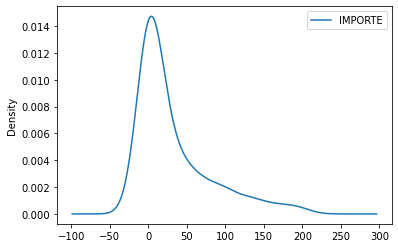

In [502]:
transacciones_super_weeks_df.plot(kind='kde')
pyplot.show()

In [503]:
"""
El diagrama de densidad sólo confirma las conclusiones del histograma.

Vemos que la parte del diagrama indica que hay transacciones de valor negativo. Lo cual es falso y únicamente pandas pinta así
el diagrama de densidad para que quede mejor.
"""

'\nEl diagrama de densidad sólo confirma las conclusiones del histograma.\n\nVemos que la parte del diagrama indica que hay transacciones de valor negativo. Lo cual es falso y únicamente pandas pinta así\nel diagrama de densidad para que quede mejor.\n'

In [504]:
# 3. Time Series Box and Whisker Plots by Interval

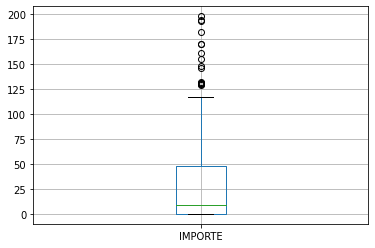

In [506]:
transacciones_super_weeks_df.boxplot()
pyplot.show()

In [507]:
"""
Vemos que el boxplot designa como outliers todas aquellas transacciones de valor superior a q3 + 1.5*iqr.
q3 + 1.5*iqr = 48.2 + 1.5*48.2 = 120.5 eur
Es decir aquellas compras superiores a 120.25 eur se consideran como outliers.

El boxplot representa perfectamente de forma gráfica los parámetros estadisticos de la distribución:
q2 = 8.83 uer
min = q1 = 0 eur
q3 = 48.2 eur

moda = 0 eur
"""

'\nVemos que el boxplot designa como outliers todas aquellas transacciones superiores a 0 eur.\nAlgo con lo que no estoy de acuerdo.\nPara mí son outliers aquellas transacciones de valor superior a q3 + 1.5*iqr\nq3 + 1.5*iqr = 48.2 + 1.5*48.2 = 120.5 eur\n\nDicho esto, al considerarse todos los puntos como outliers no puedo sacar conclusiones utiles del boxplot.\n'

In [512]:
statistics.mode(transacciones_super_weeks_df['IMPORTE'])

0.0

In [511]:
transacciones_super_weeks_df.describe()

IMPORTE
count  199.000000
mean    32.408995
std     47.650403
min      0.000000
25%      0.000000
50%      8.830000
75%     48.200000
max    197.460000

In [508]:
# TODO: 
# dejamos el estudio comparativo de los boxplots por años y por meses en los años entre 2017 y 2019 para más adelante porque
# necesito años completos

In [498]:
# 4. Time Series Heat Maps

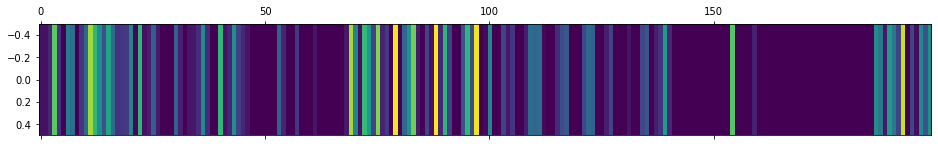

In [509]:
pyplot.matshow(transacciones_super_weeks_df.T, interpolation=None, aspect='auto')
pyplot.show()

In [514]:
"""
Vemos que el heatmap del dataset está total mente en consonancia con la representacion de los valores de las compras a lo largo
del tiempo.
Es decir, la mayor para de las semanas el valor medio de compra es cero; representado en el heatmap con valores oscuros y luego
los dias que hay compras con lineas verticales verde claro o inlcuso amarillas cuando son compras de mucho valor.
"""

'\nVemos que el heatmap del dataset está total mente en consonancia con la representacion de los valores de las compras a lo largo\ndel tiempo.\nEs decir, la mayor para de las semanas el valor medio de compra es cero; representado en el heatmap con valores oscuros y luego\nlos dias que hay compras con lineas verticales verde claro o inlcuso amarillas cuando son compras de mucho valor.\n'

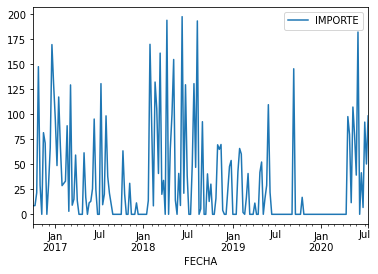

In [515]:
transacciones_super_weeks_df.plot()
pyplot.show()

In [516]:
statistics.mode(transacciones_super_weeks_df['IMPORTE'])

0.0

In [510]:
transacciones_super_weeks_df.describe()

IMPORTE
count  199.000000
mean    32.408995
std     47.650403
min      0.000000
25%      0.000000
50%      8.830000
75%     48.200000
max    197.460000

In [517]:
# TODO:
# dejamos para más adelante la representacion del heatmap por años o por meses dentro de un año para 2017, 2018 y 2019 
# porque para eso tengo que hacerme un dataframe con los años completos de 2017 a 2019

In [518]:
# 5. Time Series Lag Scatter Plots

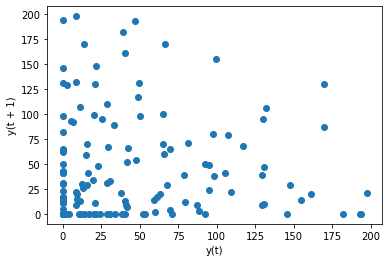

In [520]:
lag_plot(transacciones_super_weeks_df)
pyplot.show()

In [522]:
"""
Vemos que por semanas hay poca correlacion entre y(t+1) e y(t)
"""

'\nVemos que por semanas hay poca correlacion entre y(t+1) e y(t)\n'

In [528]:
# vamos a hacer lagplots (scatter plots) entre y(t+1) y sus 104 lags anteriores hasta y(t-104) para ver la correlación entre el
# valor medio de una semana y los valores medios semanales de los 24 meses anteriores

t+1 vs t-1


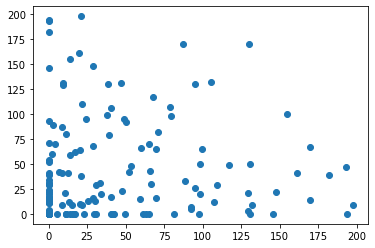

t+1 vs t-2


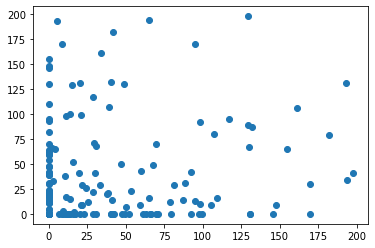

t+1 vs t-3


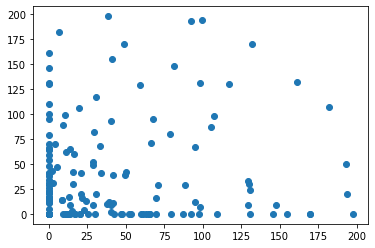

t+1 vs t-4


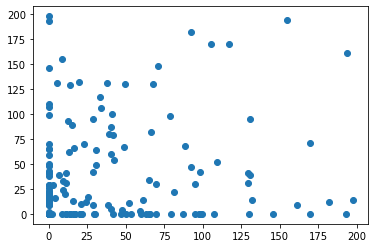

t+1 vs t-5


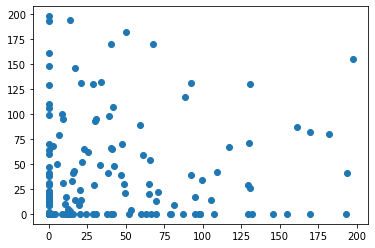

t+1 vs t-6


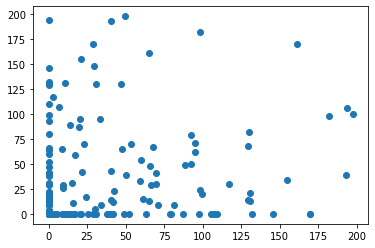

t+1 vs t-7


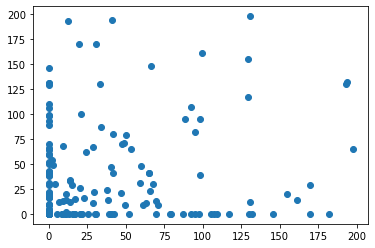

t+1 vs t-8


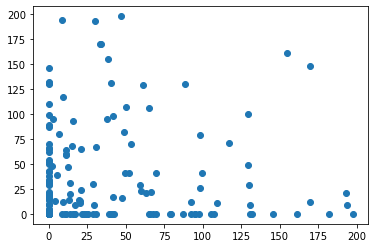

t+1 vs t-9


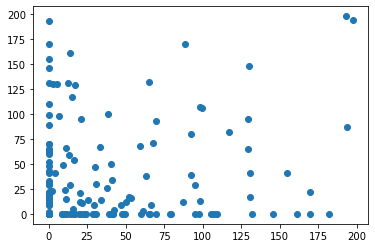

t+1 vs t-10


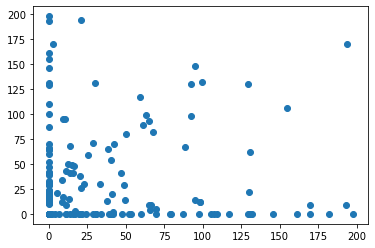

t+1 vs t-11


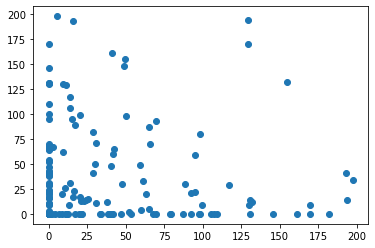

t+1 vs t-12


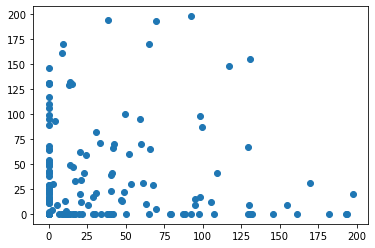

t+1 vs t-13


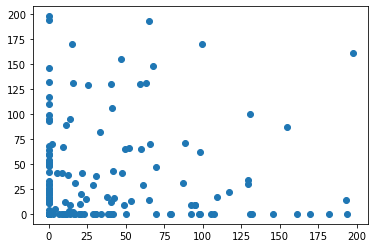

t+1 vs t-14


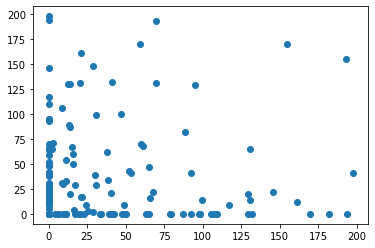

t+1 vs t-15


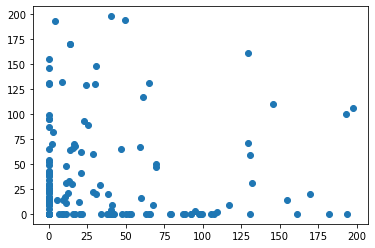

t+1 vs t-16


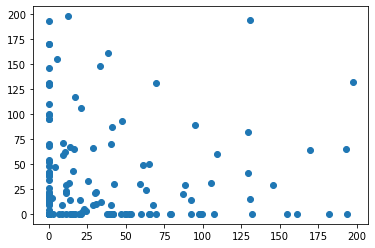

t+1 vs t-17


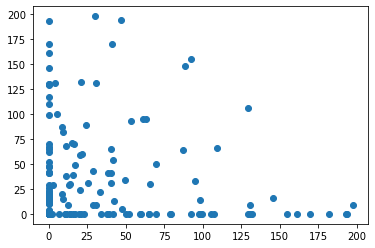

t+1 vs t-18


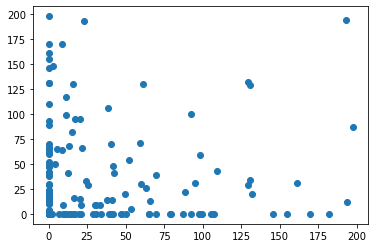

t+1 vs t-19


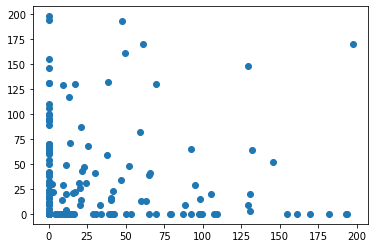

t+1 vs t-20


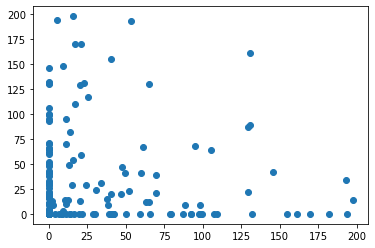

t+1 vs t-21


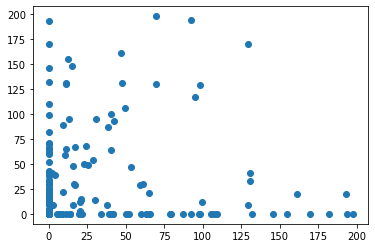

t+1 vs t-22


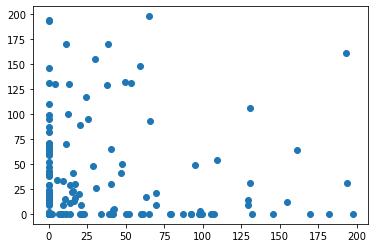

t+1 vs t-23


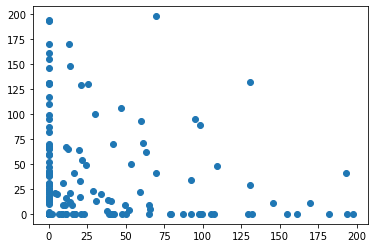

t+1 vs t-24


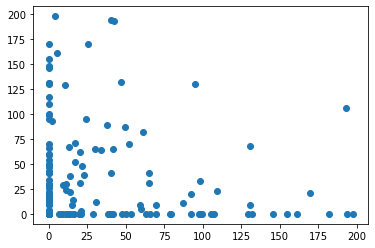

t+1 vs t-25


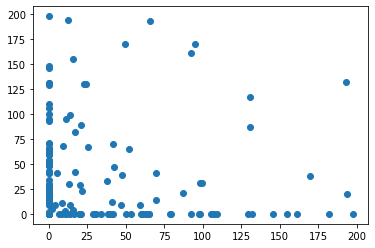

t+1 vs t-26


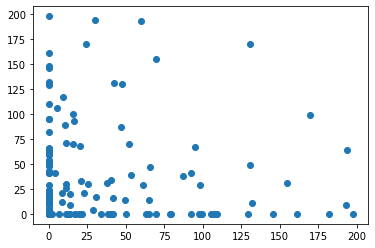

t+1 vs t-27


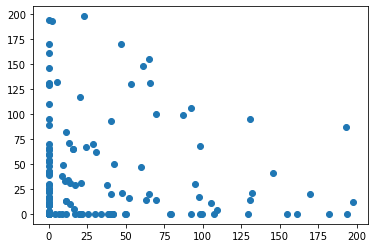

t+1 vs t-28


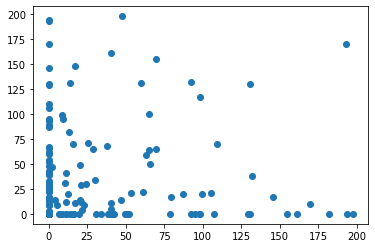

t+1 vs t-29


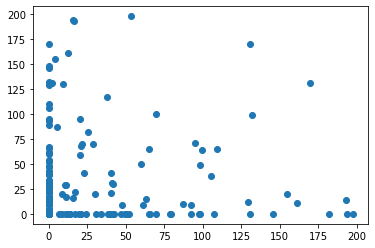

t+1 vs t-30


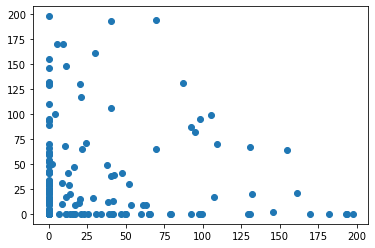

t+1 vs t-31


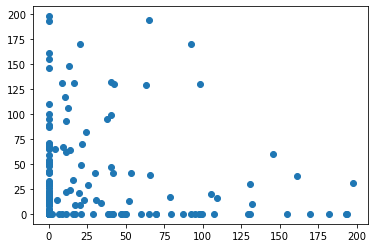

t+1 vs t-32


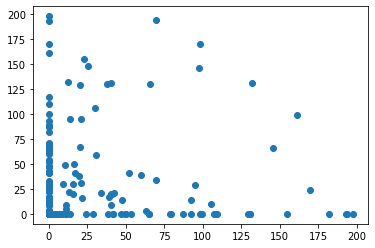

t+1 vs t-33


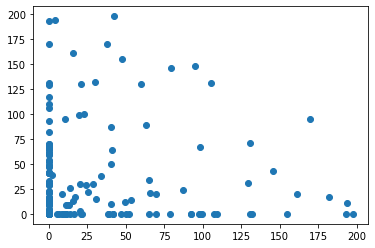

t+1 vs t-34


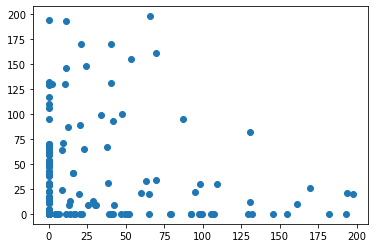

t+1 vs t-35


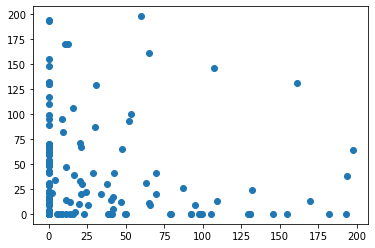

t+1 vs t-36


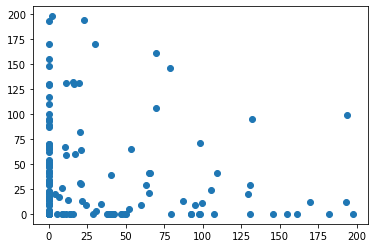

t+1 vs t-37


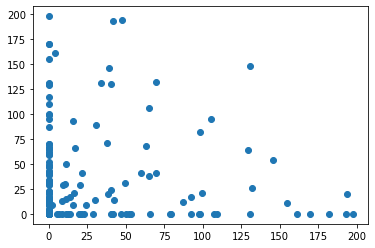

t+1 vs t-38


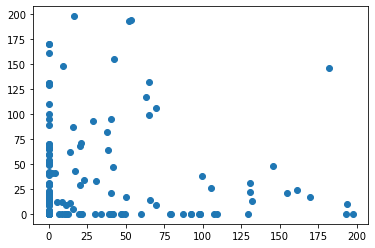

t+1 vs t-39


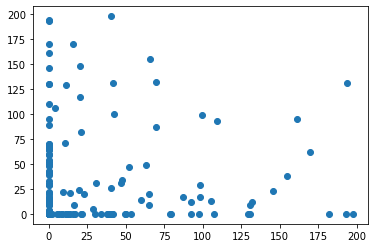

t+1 vs t-40


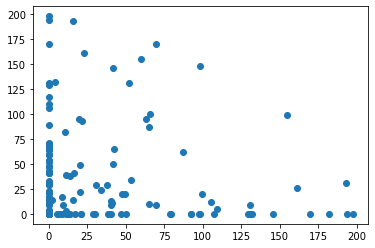

t+1 vs t-41


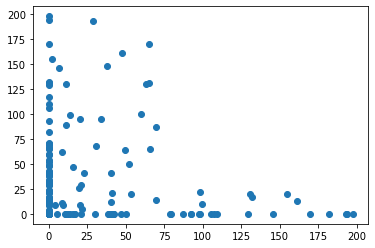

t+1 vs t-42


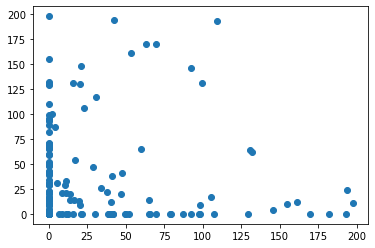

t+1 vs t-43


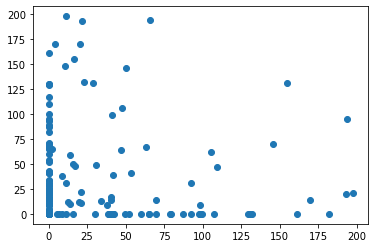

t+1 vs t-44


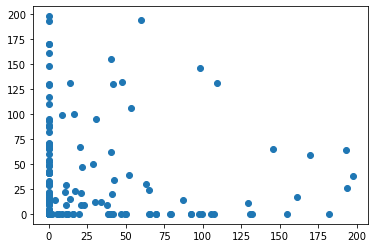

t+1 vs t-45


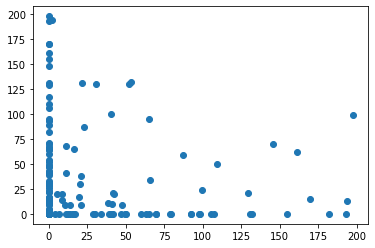

t+1 vs t-46


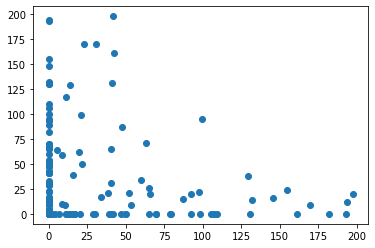

t+1 vs t-47


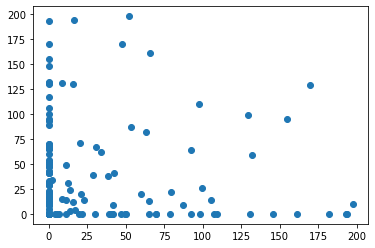

t+1 vs t-48


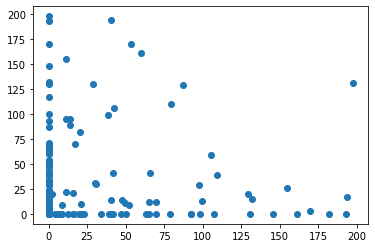

t+1 vs t-49


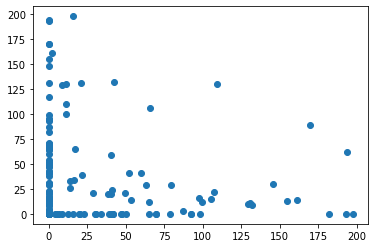

t+1 vs t-50


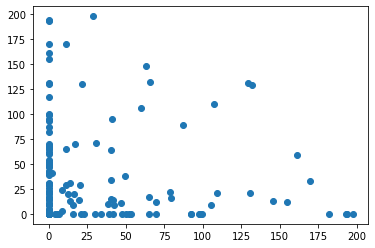

t+1 vs t-51


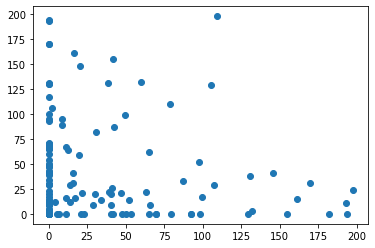

t+1 vs t-52


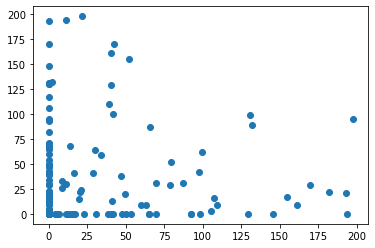

t+1 vs t-53


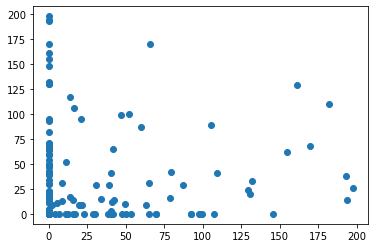

t+1 vs t-54


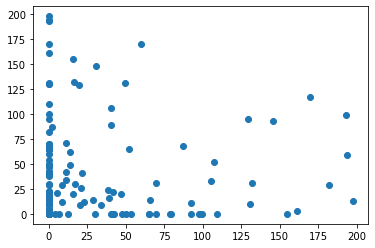

t+1 vs t-55


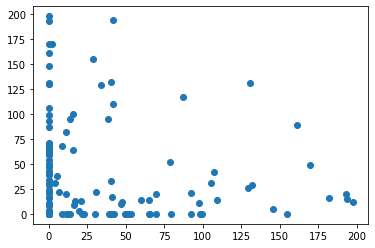

t+1 vs t-56


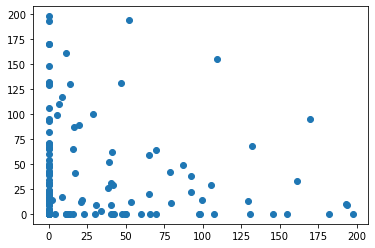

t+1 vs t-57


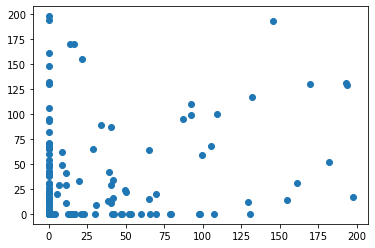

t+1 vs t-58


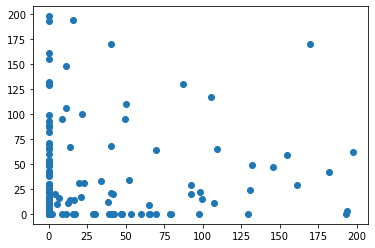

t+1 vs t-59


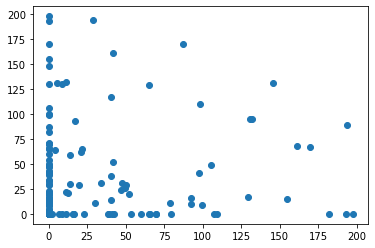

t+1 vs t-60


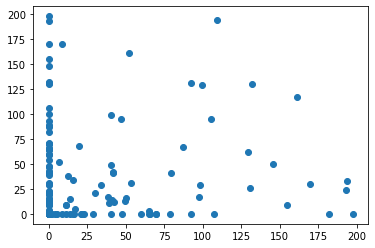

t+1 vs t-61


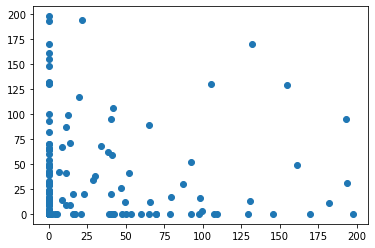

t+1 vs t-62


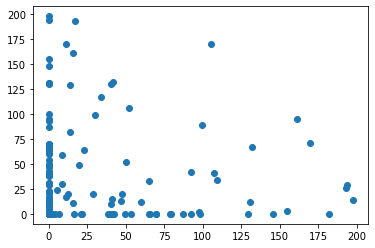

t+1 vs t-63


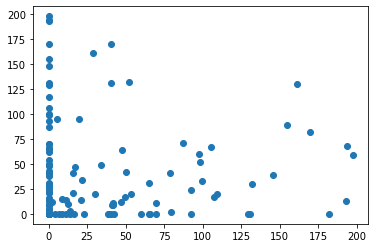

t+1 vs t-64


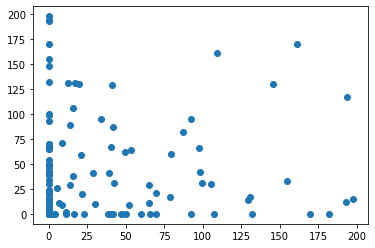

t+1 vs t-65


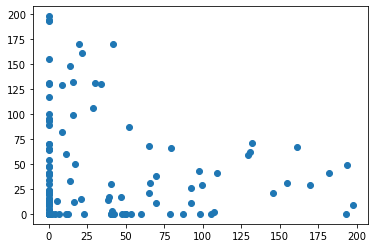

t+1 vs t-66


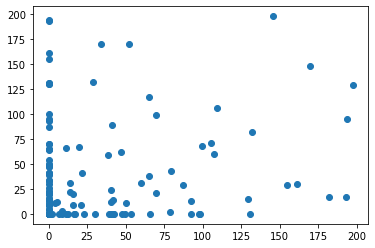

t+1 vs t-67


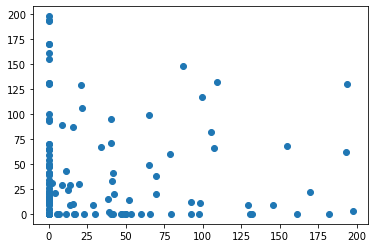

t+1 vs t-68


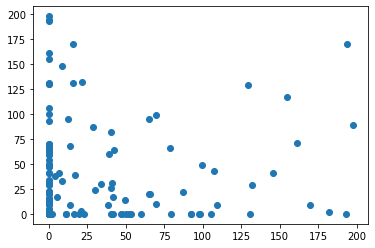

t+1 vs t-69


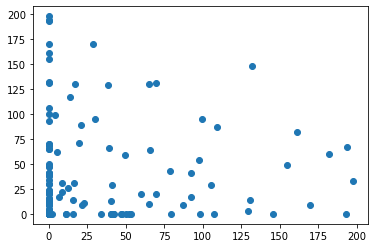

t+1 vs t-70


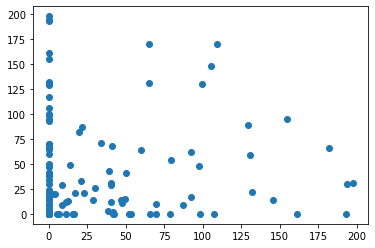

t+1 vs t-71


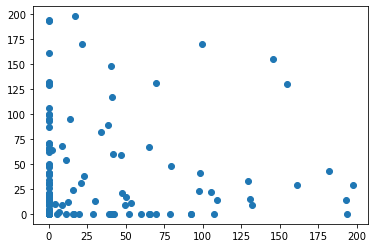

t+1 vs t-72


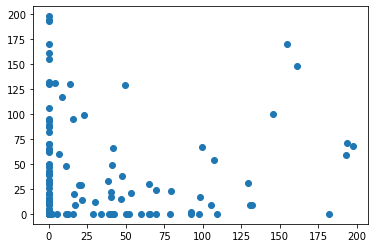

t+1 vs t-73


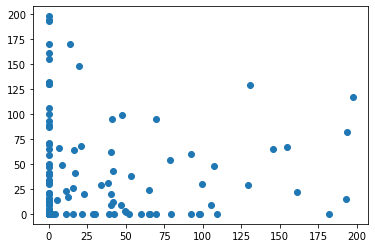

t+1 vs t-74


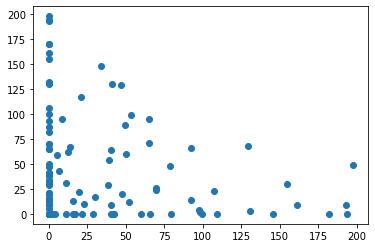

t+1 vs t-75


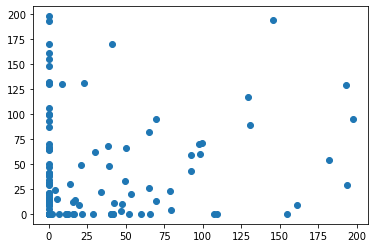

t+1 vs t-76


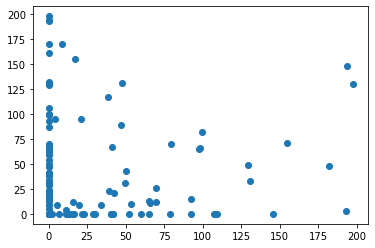

t+1 vs t-77


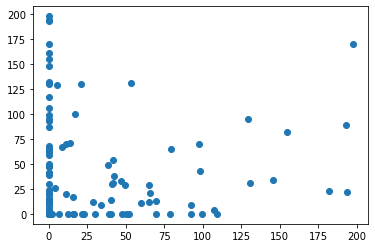

t+1 vs t-78


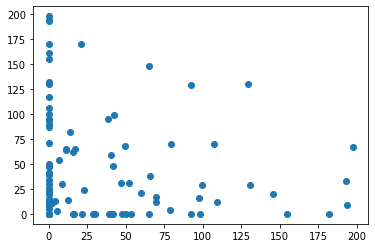

t+1 vs t-79


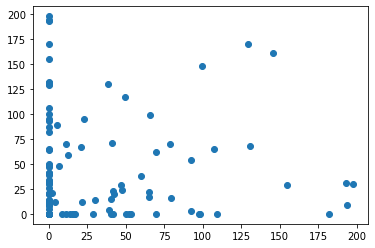

t+1 vs t-80


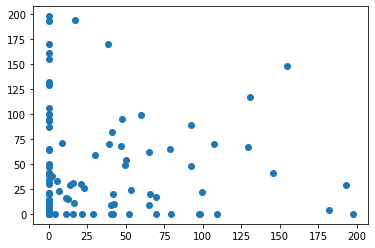

t+1 vs t-81


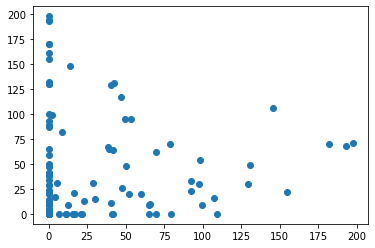

t+1 vs t-82


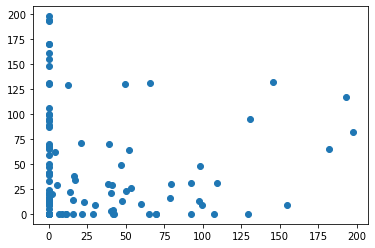

t+1 vs t-83


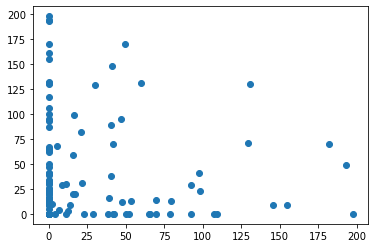

t+1 vs t-84


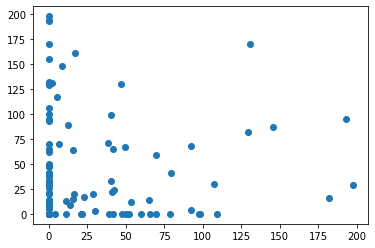

t+1 vs t-85


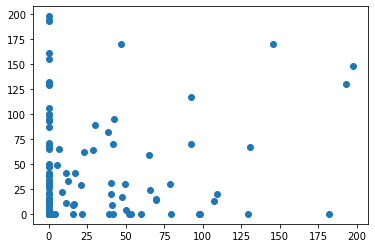

t+1 vs t-86


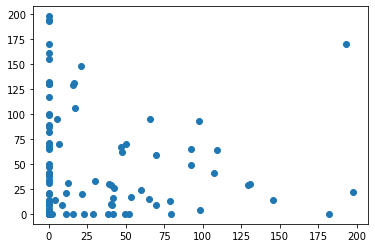

t+1 vs t-87


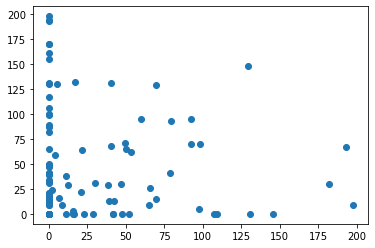

t+1 vs t-88


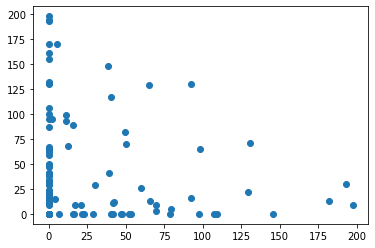

t+1 vs t-89


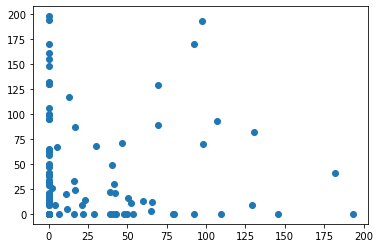

t+1 vs t-90


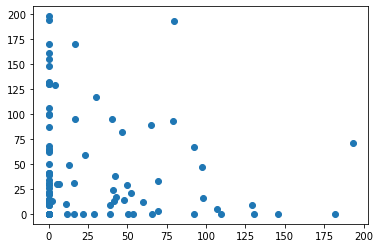

t+1 vs t-91


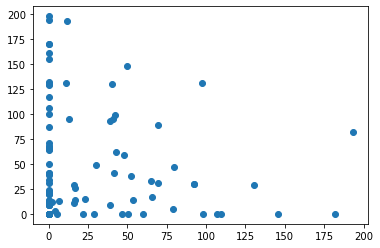

t+1 vs t-92


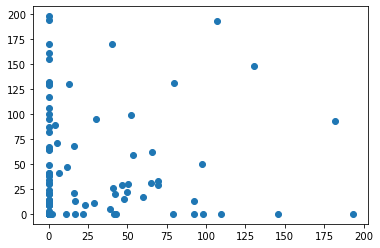

t+1 vs t-93


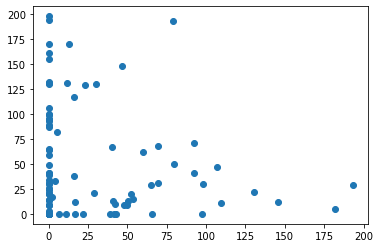

t+1 vs t-94


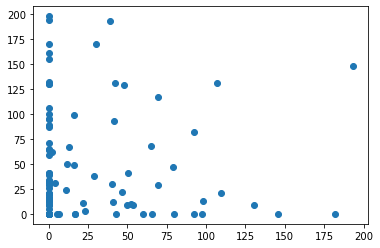

t+1 vs t-95


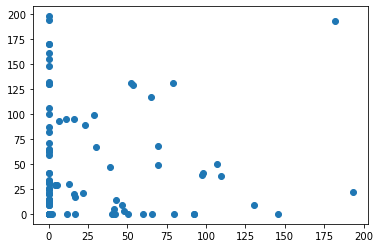

t+1 vs t-96


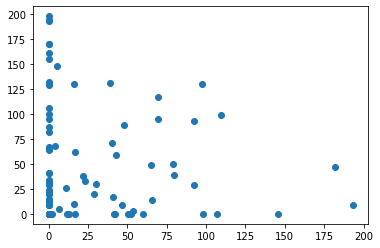

t+1 vs t-97


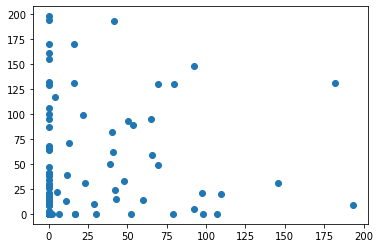

t+1 vs t-98


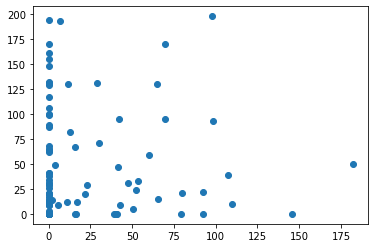

t+1 vs t-99


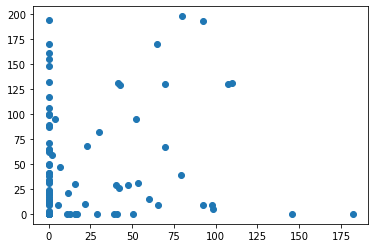

t+1 vs t-100


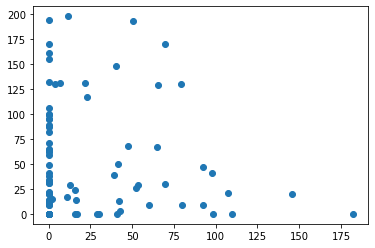

t+1 vs t-101


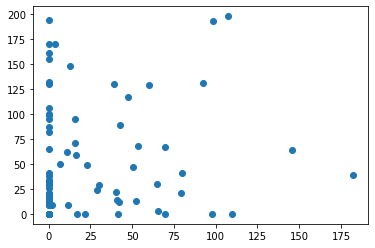

t+1 vs t-102


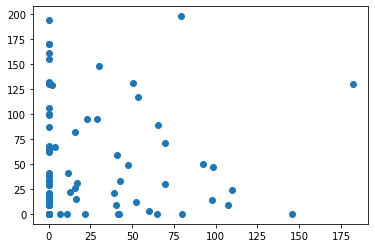

t+1 vs t-103


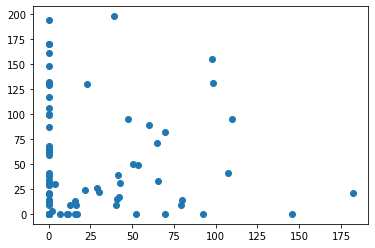

t+1 vs t-104


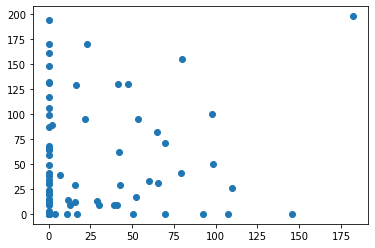

In [524]:
values = DataFrame(transacciones_super_weeks_df.values)
lags = 104
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
for i in range(1,(lags + 1)):
	print('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
	pyplot.show()

In [525]:
"""
Vemos que la correlacion por semanas entre y(t+1) y sus 104 lags anteriores es muy débil.

CONCLUSION: para modelizar temporalmente la serie mejor cogerse valores medios mensuales en lugar de valores medios semanales
"""

'\nVemos que la correlacion por semanas entre y(t+1) y sus 104 lags anteriores es muy débil.\n\nCONCLUSION: para modelizar temporalmente la serie mejor cogerse valores medios mensuales en lugar de valores medios semanales\n'

In [526]:
# 6. Time Series Autocorrelation Plots

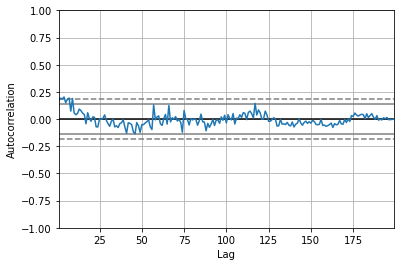

In [527]:
autocorrelation_plot(transacciones_super_weeks_df)
pyplot.show()

In [529]:
"""
El grafico de autocorrelacion sólo nos confirma lo que ya habíamos visto al hacer los scatter plots entre y(t+1) y sus 104 lags
anteriores: No hay correlación significativa entre y(t+1) y sus 200 lags anteriores.

CONCLUSION 1: esta serie temporal no es modelizable.
CONCLUSION 2: habrá que calcular valores medios por quincenas o meses y ver si esas series temporales son modelizables. 
Perderemos precisión pero ganaremos capacidad de modelización de la serie temporal siempre y cuando nos queden suficientes
valores como para que prophet pueda calcular la serie temporal.
"""

'\nEl grafico de autocorrelacion sólo nos confirma lo que ya habíamos visto al hacer los scatter plots entre y(t+1) y sus 104 lags\nanteriores: No hay correlación significativa entre y(t+1) y sus 200 lags anteriores.\n\nCONCLUSION 1: esta serie temporal no es modelizable.\nCONCLUSION 2: habrá que calcular valores medios por quincenas o meses y ver si esas series temporales son modelizables. \nPerderemos precisión pero ganaremos capacidad de modelización de la serie temporal siempre y cuando nos queden suficientes\nvalores como para que prophet pueda calcular la serie temporal.\n'

In [49]:
# VAMOS A AGRUPAR EL GASTO EN SUPERMERCADOS POR SEMANAS AL LUNES Y RELLENAR HUECOS CON EL VALOR DEL LUNES
# Y VER SI ASI SE PUEDE MODELAR LA SERIE TEMPORAL

In [50]:
# Load data using read_excel
transacciones_df = read_excel('20210513 mmelero (249236).xlsx', sheet_name='Hoja1')
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría  \
0           2020-07-24    -1.20          84.0                 parking_84   
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117   
2           2020-07-23   -13.53          70.0           supermercados_70   
3           2020-07-22   -51.40         222.0                   adsl_222   
4           2020-07-22   -11.00          70.0           supermercados_70   
...                ...      ...           ...                        ...   
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18   
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126   
1484        2016-09-05  -138.08         125.0                 cuotas_125   
1485        2016-09-01   -32.22          90.0            seguro_salud_90   
1486        2016-09-01   -33.00         434.0                 cuotas_434   

      Nivel categoría  iD categoría padre Nombre categoría padre  \
0                 2.0                 5.0            vehiculos_5   
1                 2.0                 8.0    gastos_personales_8   
2                 2.0                 4.0         alimentacion_4   
3                 3.0               521.0    Comunicaciones y TV   
4                 2.0                 4.0         alimentacion_4   
...               ...                 ...                    ...   
1482              3.0               576.0                 Nómina   
1483              3.0               478.0   tarjetas_credito_478   
1484              3.0               127.0      otros_pasivos_127   
1485              2.0                 6.0                salud_6   
1486              3.0               115.0           deportes_115   

                    Proveedor               Marca  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                        SPAR                SPAR   
3                Jazz Telecom             Jazztel   
4                   Mercadona           Mercadona   
...                       ...                 ...   
1482                      NaN                 NaN   
1483                      NaN                 NaN   
1484                      NaN                 NaN   
1485  Sanitas S.A. de Seguros             Sanitas   
1486       Royal Sport Center  Royal Sport Center   

                            Sector  Financiero  Transferencia  Unnamed: 12  \
0                              NaN       False          False          NaN   
1                              NaN       False          False          NaN   
2                    Supermercados       False          False          NaN   
3     Compañías telecomunicaciones       False          False          NaN   
4                    Supermercados       False          False          NaN   
...                            ...         ...            ...          ...   
1482                           NaN       False          False          NaN   
1483                           NaN        True           True          NaN   
1484                           NaN        True          False          NaN   
1485              Seguros de salud        True          False          NaN   
1486              Clubs deportivos       False          False          NaN   

      Unnamed: 13        ID  BALANCE BALANCE_DATE  
0             NaN  249236.0  1478.98   2020-07-26  
1             NaN       NaN      NaN          NaT  
2             NaN       NaN      NaN          NaT  
3             NaN       NaN      NaN          NaT  
4             NaN       NaN      NaN          NaT  
...           ...       ...      ...          ...  
1482          NaN       NaN      NaN          NaT  
1483          NaN       NaN      NaN          NaT  
1484          NaN       NaN      NaN          NaT  
1485          NaN       NaN      NaN          NaT  
1486          NaN       NaN      NaN          NaT  

[1487 rows x 17 columns]

In [51]:
# nos quedamos con la fecha en que nos dan los datos de las transacciones
last_date_obj = transacciones_df.loc[0,'BALANCE_DATE']
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [52]:
# nos quedamos con categoria desde 'Fecha transacción' hasta 'Nombre Categoría'
transacciones_df=transacciones_df.iloc[:,0:4]
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría
0           2020-07-24    -1.20          84.0                 parking_84
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117
2           2020-07-23   -13.53          70.0           supermercados_70
3           2020-07-22   -51.40         222.0                   adsl_222
4           2020-07-22   -11.00          70.0           supermercados_70
...                ...      ...           ...                        ...
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126
1484        2016-09-05  -138.08         125.0                 cuotas_125
1485        2016-09-01   -32.22          90.0            seguro_salud_90
1486        2016-09-01   -33.00         434.0                 cuotas_434

[1487 rows x 4 columns]

In [53]:
# nos quedamos con las transacciones de la categoria 'supermercados_70'
transacciones_super_df=transacciones_df[transacciones_df['ID Categoría'] == 70.0]
transacciones_super_df

Fecha transacción  Importe  ID Categoría  Nombre categoría
2           2020-07-23   -13.53          70.0  supermercados_70
4           2020-07-22   -11.00          70.0  supermercados_70
6           2020-07-22   -73.77          70.0  supermercados_70
9           2020-07-20   -16.17          70.0  supermercados_70
12          2020-07-20   -14.75          70.0  supermercados_70
...                ...      ...           ...               ...
1427        2016-11-03   -18.21          70.0  supermercados_70
1436        2016-10-25  -147.50          70.0  supermercados_70
1444        2016-10-24   -21.48          70.0  supermercados_70
1456        2016-10-11    -8.74          70.0  supermercados_70
1465        2016-10-06    -8.58          70.0  supermercados_70

[284 rows x 4 columns]

In [54]:
# quitamos las columnas de 'ID Categoría' y 'Nombre Categoría' que ya no me aportan nada
transacciones_super_df.drop(columns=['ID Categoría', 'Nombre categoría'], inplace=True)
transacciones_super_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Fecha transacción  Importe
2           2020-07-23   -13.53
4           2020-07-22   -11.00
6           2020-07-22   -73.77
9           2020-07-20   -16.17
12          2020-07-20   -14.75
...                ...      ...
1427        2016-11-03   -18.21
1436        2016-10-25  -147.50
1444        2016-10-24   -21.48
1456        2016-10-11    -8.74
1465        2016-10-06    -8.58

[284 rows x 2 columns]

In [55]:
# renombramos columnas
transacciones_super_df.rename(columns={'Fecha transacción': 'FECHA', 'Importe': 'IMPORTE'}, inplace=True)
transacciones_super_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


FECHA  IMPORTE
2    2020-07-23   -13.53
4    2020-07-22   -11.00
6    2020-07-22   -73.77
9    2020-07-20   -16.17
12   2020-07-20   -14.75
...         ...      ...
1427 2016-11-03   -18.21
1436 2016-10-25  -147.50
1444 2016-10-24   -21.48
1456 2016-10-11    -8.74
1465 2016-10-06    -8.58

[284 rows x 2 columns]

In [56]:
# ordenamos las fechas por orden ascendente
transacciones_super_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)
transacciones_super_df

<ipython-input-56-8ed63b426aa3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transacciones_super_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)


FECHA  IMPORTE
0   2016-10-06    -8.58
1   2016-10-11    -8.74
2   2016-10-24   -21.48
3   2016-10-25  -147.50
4   2016-11-03   -18.21
..         ...      ...
279 2020-07-20   -14.75
280 2020-07-20   -16.17
281 2020-07-22   -73.77
282 2020-07-22   -11.00
283 2020-07-23   -13.53

[284 rows x 2 columns]

In [57]:
# vamos a agrupar los valores y sumarlos por fecha
transacciones_super_df=transacciones_super_df.groupby(['FECHA']).sum()
transacciones_super_df

IMPORTE
FECHA              
2016-10-06    -8.58
2016-10-11    -8.74
2016-10-24   -21.48
2016-10-25  -147.50
2016-11-03   -18.21
...             ...
2020-07-15    -6.61
2020-07-17   -12.72
2020-07-20   -30.92
2020-07-22   -84.77
2020-07-23   -13.53

[214 rows x 1 columns]

In [58]:
# VAMOS A AGRUPAR LOS DATOS POR SEMANAS Y SUMAR
transacciones_super_weeks_df = transacciones_super_df.copy()
transacciones_super_weeks_df

IMPORTE
FECHA              
2016-10-06    -8.58
2016-10-11    -8.74
2016-10-24   -21.48
2016-10-25  -147.50
2016-11-03   -18.21
...             ...
2020-07-15    -6.61
2020-07-17   -12.72
2020-07-20   -30.92
2020-07-22   -84.77
2020-07-23   -13.53

[214 rows x 1 columns]

In [59]:
# sacamos una columna FECHA con el indice
transacciones_super_weeks_df['FECHA'] = transacciones_super_weeks_df.index
transacciones_super_weeks_df

IMPORTE      FECHA
FECHA                         
2016-10-06    -8.58 2016-10-06
2016-10-11    -8.74 2016-10-11
2016-10-24   -21.48 2016-10-24
2016-10-25  -147.50 2016-10-25
2016-11-03   -18.21 2016-11-03
...             ...        ...
2020-07-15    -6.61 2020-07-15
2020-07-17   -12.72 2020-07-17
2020-07-20   -30.92 2020-07-20
2020-07-22   -84.77 2020-07-22
2020-07-23   -13.53 2020-07-23

[214 rows x 2 columns]

In [60]:
# esto no va en produccion
# comprobamos tipos
transacciones_super_weeks_df.dtypes

IMPORTE           float64
FECHA      datetime64[ns]
dtype: object

In [61]:
# First substract one week, as we want to sum for the week ahead of the date, not the week before that date.
transacciones_super_weeks_df['FECHA'] = transacciones_super_weeks_df['FECHA'] - timedelta(days=7)
transacciones_super_weeks_df

IMPORTE      FECHA
FECHA                         
2016-10-06    -8.58 2016-09-29
2016-10-11    -8.74 2016-10-04
2016-10-24   -21.48 2016-10-17
2016-10-25  -147.50 2016-10-18
2016-11-03   -18.21 2016-10-27
...             ...        ...
2020-07-15    -6.61 2020-07-08
2020-07-17   -12.72 2020-07-10
2020-07-20   -30.92 2020-07-13
2020-07-22   -84.77 2020-07-15
2020-07-23   -13.53 2020-07-16

[214 rows x 2 columns]

In [62]:
# Then use groupby with Grouper by W-MON and aggregate sum.
transacciones_super_weeks_df = transacciones_super_weeks_df.resample('W-Mon', on='FECHA').sum()
transacciones_super_weeks_df

IMPORTE
FECHA              
2016-10-03    -8.58
2016-10-10    -8.74
2016-10-17   -21.48
2016-10-24  -147.50
2016-10-31   -29.04
...             ...
2020-06-22   -41.52
2020-06-29    -6.83
2020-07-06   -92.12
2020-07-13   -50.25
2020-07-20   -98.30

[199 rows x 1 columns]

In [63]:
# vamos a rellenar las missing dates con el ultimo valor válido y comprobar si esa serie temporal es modelable y predecible

In [64]:
# hago una columna fecha con el indice
transacciones_super_weeks_df['FECHA'] = transacciones_super_weeks_df.index
transacciones_super_weeks_df

IMPORTE      FECHA
FECHA                         
2016-10-03    -8.58 2016-10-03
2016-10-10    -8.74 2016-10-10
2016-10-17   -21.48 2016-10-17
2016-10-24  -147.50 2016-10-24
2016-10-31   -29.04 2016-10-31
...             ...        ...
2020-06-22   -41.52 2020-06-22
2020-06-29    -6.83 2020-06-29
2020-07-06   -92.12 2020-07-06
2020-07-13   -50.25 2020-07-13
2020-07-20   -98.30 2020-07-20

[199 rows x 2 columns]

In [65]:
# en siguiente celda 2020-7-20 es la fecha del ultimo lunes pero queremos que el dataset acabe el domingo de esa semana
# 2020-7-26
transacciones_super_weeks_df.FECHA.max() + pandas.DateOffset(6)

Timestamp('2020-07-26 00:00:00')

In [66]:
# hago un date_range desde el lunes de la 1a semana hasta el domingo de la ultima semana
idx = date_range(start=transacciones_super_weeks_df.FECHA.min(),
                 end=transacciones_super_weeks_df.FECHA.max() + pandas.DateOffset(6))
idx

DatetimeIndex(['2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
               '2016-10-11', '2016-10-12',
               ...
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26'],
              dtype='datetime64[ns]', length=1393, freq='D')

In [67]:
# esto no va en produccion
# comprobamos tipo del indice
type(transacciones_super_weeks_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [68]:
# sustituyo el indice de transacciones_super_weeks_df por el de idx y relleno los missing values con 'NaN'
transacciones_super_weeks_df = transacciones_super_weeks_df.reindex(idx, fill_value='NaN')
transacciones_super_weeks_df

IMPORTE      FECHA
2016-10-03   -8.58 2016-10-03
2016-10-04     NaN        NaT
2016-10-05     NaN        NaT
2016-10-06     NaN        NaT
2016-10-07     NaN        NaT
...            ...        ...
2020-07-22     NaN        NaT
2020-07-23     NaN        NaT
2020-07-24     NaN        NaT
2020-07-25     NaN        NaT
2020-07-26     NaN        NaT

[1393 rows x 2 columns]

In [69]:
# elimino la columna FECHA
transacciones_super_weeks_df.drop(columns='FECHA', inplace=True)
transacciones_super_weeks_df

IMPORTE
2016-10-03   -8.58
2016-10-04     NaN
2016-10-05     NaN
2016-10-06     NaN
2016-10-07     NaN
...            ...
2020-07-22     NaN
2020-07-23     NaN
2020-07-24     NaN
2020-07-25     NaN
2020-07-26     NaN

[1393 rows x 1 columns]

In [70]:
# esto no va en produccion
# comprobamos tipos
transacciones_super_weeks_df.dtypes

IMPORTE    object
dtype: object

In [71]:
# pasamos el df a serie para poder cambiar el tipo de IMPORTE de object a numeric
transacciones_super_weeks_ser = transacciones_super_weeks_df.T.squeeze()
transacciones_super_weeks_ser

2016-10-03   -8.58
2016-10-04     NaN
2016-10-05     NaN
2016-10-06     NaN
2016-10-07     NaN
              ... 
2020-07-22     NaN
2020-07-23     NaN
2020-07-24     NaN
2020-07-25     NaN
2020-07-26     NaN
Freq: D, Name: IMPORTE, Length: 1393, dtype: object

In [73]:
# cambiamos el tipo de la serie de object a float64
transacciones_super_weeks_ser = to_numeric(transacciones_super_weeks_ser, errors='coerce')
transacciones_super_weeks_ser

2016-10-03   -8.58
2016-10-04     NaN
2016-10-05     NaN
2016-10-06     NaN
2016-10-07     NaN
              ... 
2020-07-22     NaN
2020-07-23     NaN
2020-07-24     NaN
2020-07-25     NaN
2020-07-26     NaN
Freq: D, Name: IMPORTE, Length: 1393, dtype: float64

In [74]:
# recuperamos el dataframe con el tipo cambiado a partir de la serie
transacciones_super_weeks_df = DataFrame(transacciones_super_weeks_ser)
del transacciones_super_weeks_ser
transacciones_super_weeks_df

IMPORTE
2016-10-03    -8.58
2016-10-04      NaN
2016-10-05      NaN
2016-10-06      NaN
2016-10-07      NaN
...             ...
2020-07-22      NaN
2020-07-23      NaN
2020-07-24      NaN
2020-07-25      NaN
2020-07-26      NaN

[1393 rows x 1 columns]

In [75]:
# esta linea no va en producción
# comprobamos tipos
transacciones_super_weeks_df.dtypes

IMPORTE    float64
dtype: object

In [76]:
# rellenamos los NaN con el ultimo valor numérico anterior
transacciones_super_weeks_df['IMPORTE'].fillna(method='ffill', inplace=True)
transacciones_super_weeks_df

IMPORTE
2016-10-03    -8.58
2016-10-04    -8.58
2016-10-05    -8.58
2016-10-06    -8.58
2016-10-07    -8.58
...             ...
2020-07-22   -98.30
2020-07-23   -98.30
2020-07-24   -98.30
2020-07-25   -98.30
2020-07-26   -98.30

[1393 rows x 1 columns]

In [81]:
# para que los datos sean más fáciles de interpretar vamos a hacerlos todos positivos multiplicándolos por '-1'
transacciones_super_weeks_df['IMPORTE'] = -transacciones_super_weeks_df['IMPORTE']
transacciones_super_weeks_df

IMPORTE
2016-10-03     8.58
2016-10-04     8.58
2016-10-05     8.58
2016-10-06     8.58
2016-10-07     8.58
...             ...
2020-07-22    98.30
2020-07-23    98.30
2020-07-24    98.30
2020-07-25    98.30
2020-07-26    98.30

[1393 rows x 1 columns]

In [82]:
# VAMOS A COMPROBAR SI ESTA SERIE TEMPORAL ES MODELIZABLE 'transacciones_super_weeks_df' 

In [83]:
# Time Series Data Visualization with Python
# https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [84]:
# 1. Time Series Line Plot

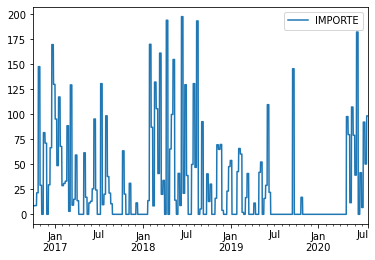

In [85]:
transacciones_super_weeks_df.plot()
pyplot.show()

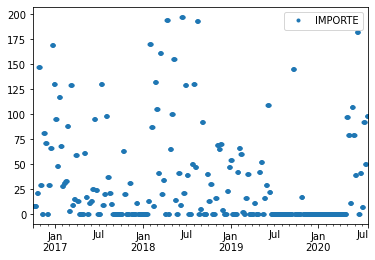

In [86]:
transacciones_super_weeks_df.plot(style='.')
pyplot.show()

In [87]:
"""a priori no parece una serie muy sencilla de modelizar porque tiene datos muy dispersos"""

'a priori no parece una serie muy sencilla de modelizar porque tiene datos muy dispersos'

In [88]:
# 2. Time Series Histogram and Density Plots

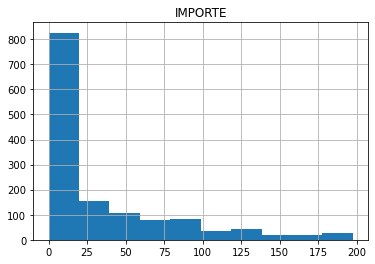

In [89]:
transacciones_super_weeks_df.hist()
pyplot.show()

In [96]:
"""
Es una distribucion sesgada a la derecha: moda (0) > mediana (8.83) > media (32.40).

Debe ser porque hay muchas semanas en que no se hace compra en el supermercado.
min = 0
q1  = 0 
q2  = 8.83
q3  = 48.69
max = 197.46

quizá sea modelizable
"""

'\nEs una distribucion sesgada a la derecha: moda (0) > mediana (8.83) > media (32.40).\n\nDebe ser porque hay muchas semanas en que no se hace compra en el supermercado.\nmin = 0\nq1  = 0 \nq2  = 8.83\nq3  = 48.69\nmax = 197.46\n\nquizá sea modelizable\n'

In [93]:
transacciones_super_weeks_df.describe()

IMPORTE
count  1393.000000
mean     32.408995
std      47.547597
min      -0.000000
25%      -0.000000
50%       8.830000
75%      48.690000
max     197.460000

In [94]:
# calculamos la moda
stat_mode = statistics.mode(transacciones_super_weeks_df['IMPORTE'])
stat_mode

-0.0

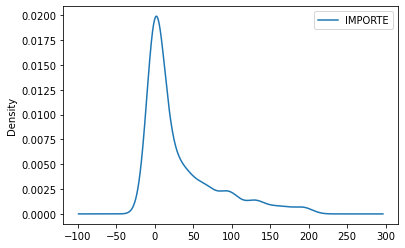

In [95]:
transacciones_super_weeks_df.plot(kind='kde')
pyplot.show()

In [ ]:
"""
El diagrama de densidad nos confirma las conclusiones del histograma y no nos aporta nueva información
"""

In [97]:
# 3. Time Series Box and Whisker Plots by Interval

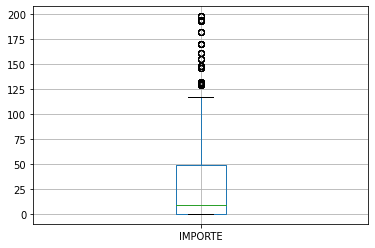

In [99]:
transacciones_super_weeks_df.boxplot()
pyplot.show()

In [100]:
"""
iqr = 48.69 - 0 = 48.69
whisker = q3 + 1.5*iqr = 48.69 + 1.5*48.69 = 121.725

En línea con el histograma el 75% de las transacciones están entre 0 y 48.69 eur y las mayores a 121.72 eur 
las considera outliers; sobre todo porque la mayoria de los dias-semanas el valor de la transaccion es 0
"""

'\niqr = 48.69 - 0 = 48.69\nwhisker = q3 + 1.5*iqr = 48.69 + 1.5*48.69 = 121.725\n\nEn línea con el histograma el 75% de las transacciones están entre 0 y 48.69 eur y las mayores a 121.72 eur \nlas considera outliers; sobre todo porque la mayoria de los dias-semanas el valor de la transaccion es 0\n'

In [101]:
# 4. Time Series Heat Maps

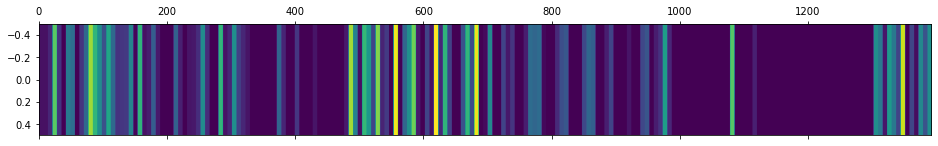

In [102]:
pyplot.matshow(transacciones_super_weeks_df.T, interpolation=None, aspect='auto')
pyplot.show()

In [103]:
"""
El mapa de color nos muestra de forma muy gráfica como la mayor parte de los dias-semanas el valor de la transaccion es 0 eur
y cuando no lo es muchas veces es tomado como outlier en verde muy claro/brillante o amarillo
"""

'\nEl mapa de color nos muestra de forma muy gráfica como la mayor parte de los dias-semanas el valor de la transaccion es 0 eur\ny cuando no lo es muchas veces es tomado como outlier en verde muy claro/brillante o amarillo\n'

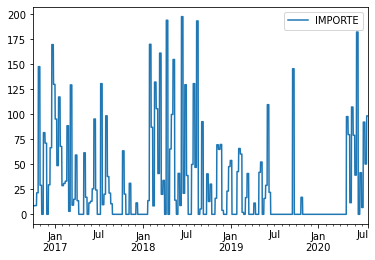

In [104]:
transacciones_super_weeks_df.plot()
pyplot.show()

In [105]:
# 5. Time Series Lag Scatter Plots

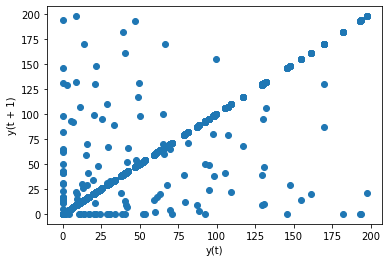

In [107]:
lag_plot(transacciones_super_weeks_df)
pyplot.show()

In [109]:
"""
sorprendentemente si que vemos que hay correlacion entre y(t+1) e y(t) (se ve una clara diagonal aunque haya ruido) con lo que
podemos esperar que esta serie temporal sea modelizable
"""

'\nsorprendentemente si que vemos que hay correlacion entre y(t+1) e y(t) (se ve una clara diagonal aunque haya ruido) con lo que\npodemos esperar que esta serie temporal sea modelizable\n'

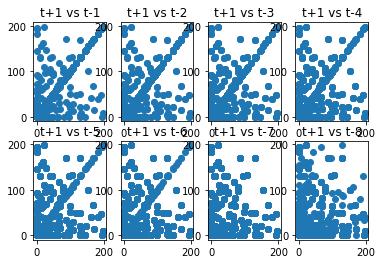

In [110]:
values = DataFrame(transacciones_super_weeks_df.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
	ax = pyplot.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

In [111]:
"""
podemos observar que hay clara correlacion entre y(t+1) y sus 6 lags anteriores
"""

'\npodemos observar que hay clara correlacion entre y(t+1) y sus 6 lags anteriores\n'

In [112]:
transacciones_super_weeks_df.size

1393

t+1 vs t-1


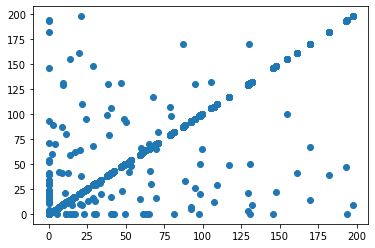

t+1 vs t-2


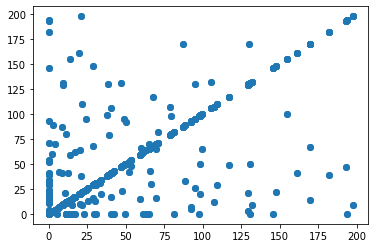

t+1 vs t-3


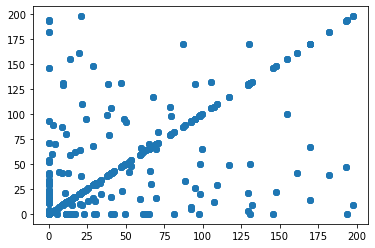

t+1 vs t-4


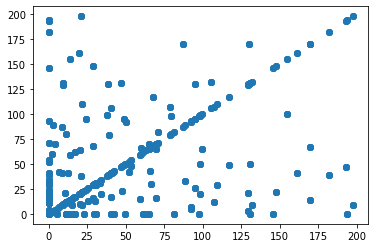

t+1 vs t-5


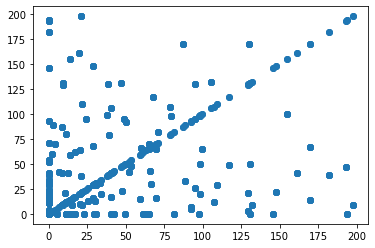

t+1 vs t-6


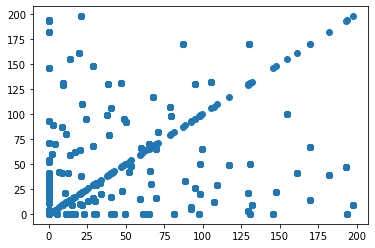

t+1 vs t-7


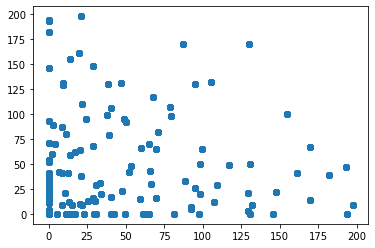

t+1 vs t-8


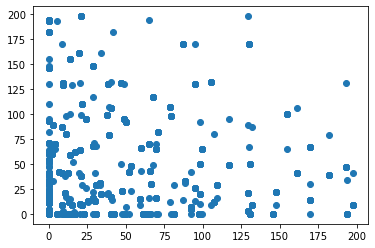

t+1 vs t-9


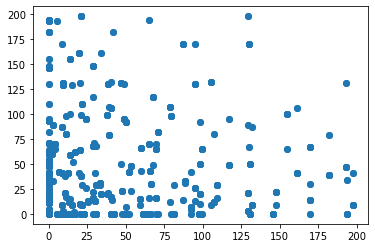

t+1 vs t-10


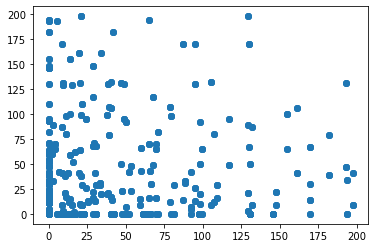

t+1 vs t-11


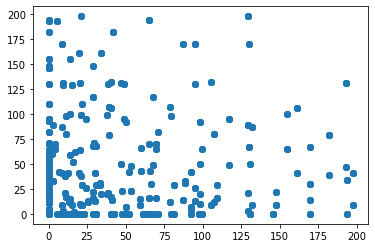

t+1 vs t-12


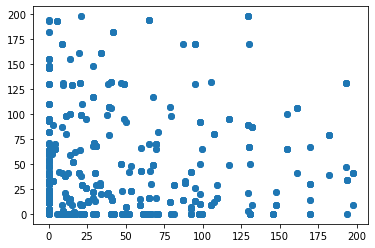

t+1 vs t-13


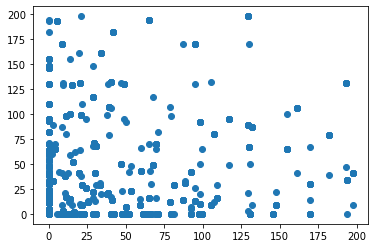

t+1 vs t-14


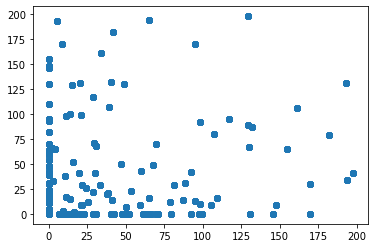

t+1 vs t-15


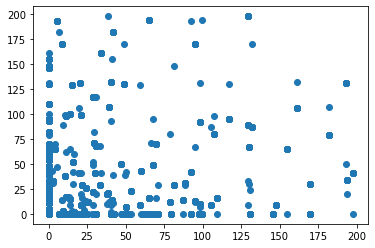

t+1 vs t-16


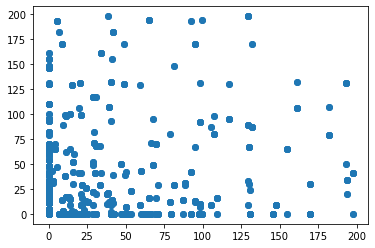

t+1 vs t-17


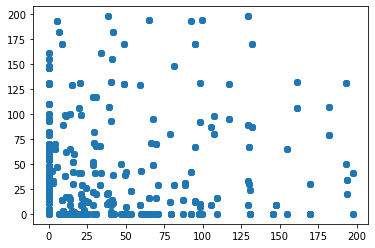

t+1 vs t-18


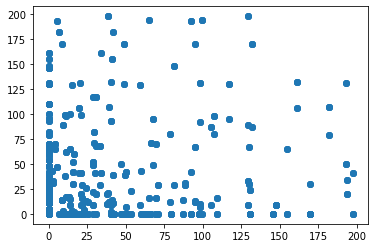

t+1 vs t-19


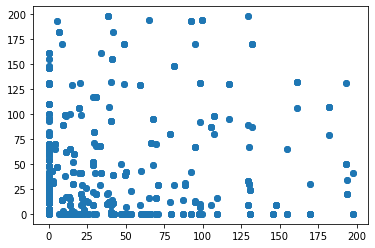

t+1 vs t-20


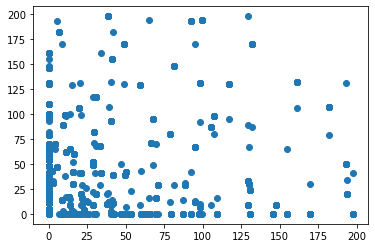

t+1 vs t-21


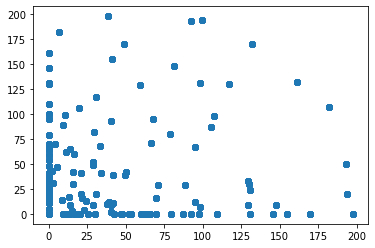

t+1 vs t-22


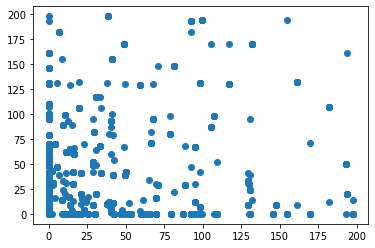

t+1 vs t-23


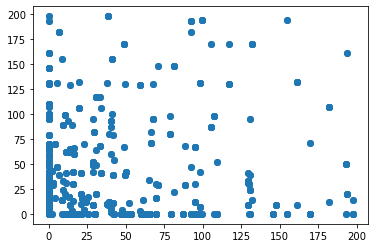

t+1 vs t-24


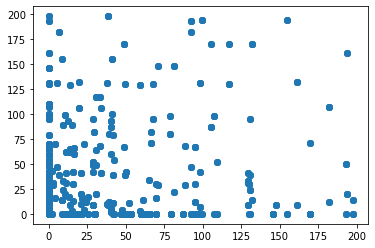

t+1 vs t-25


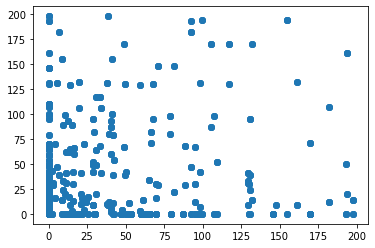

t+1 vs t-26


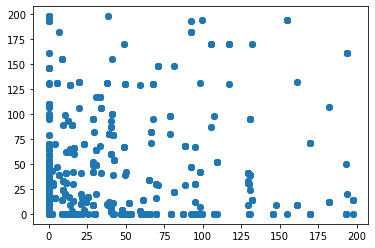

t+1 vs t-27


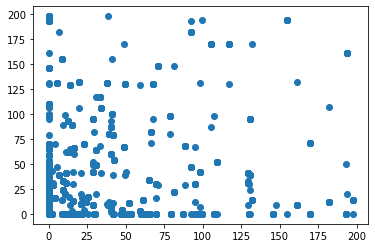

t+1 vs t-28


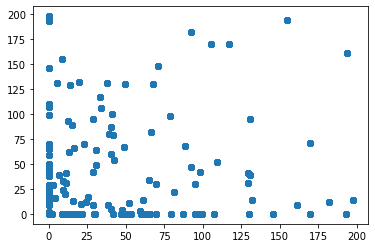

t+1 vs t-29


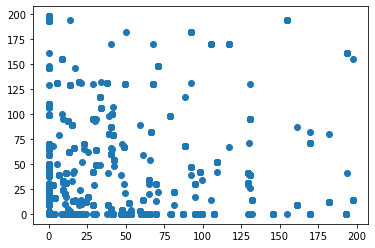

t+1 vs t-30


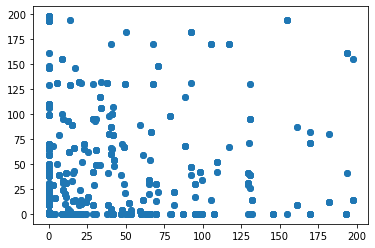

t+1 vs t-31


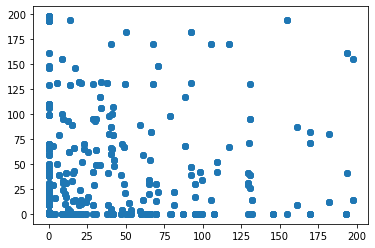

t+1 vs t-32


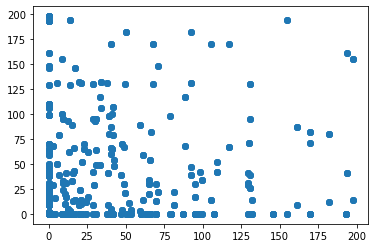

t+1 vs t-33


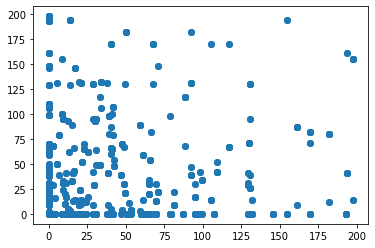

t+1 vs t-34


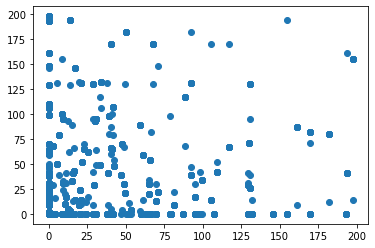

t+1 vs t-35


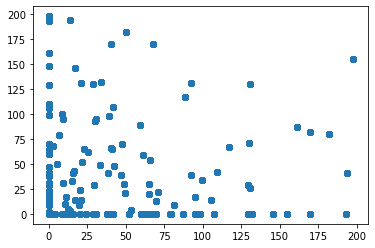

t+1 vs t-36


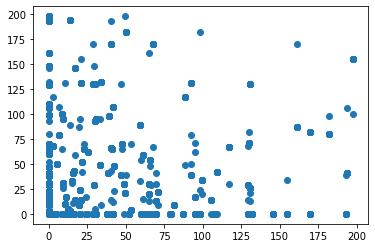

t+1 vs t-37


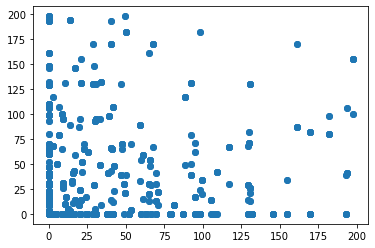

t+1 vs t-38


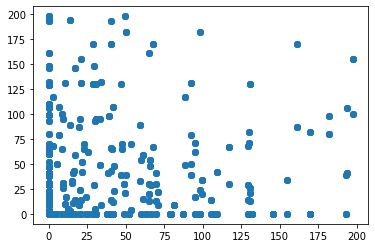

t+1 vs t-39


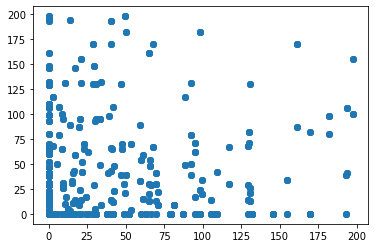

t+1 vs t-40


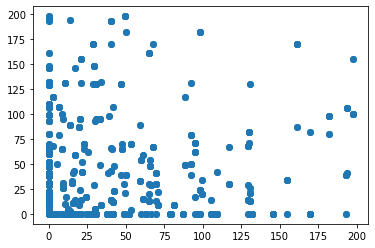

t+1 vs t-41


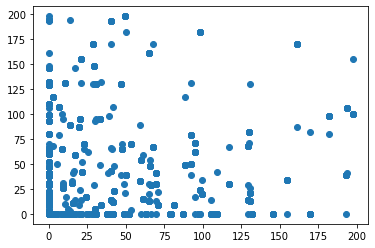

t+1 vs t-42


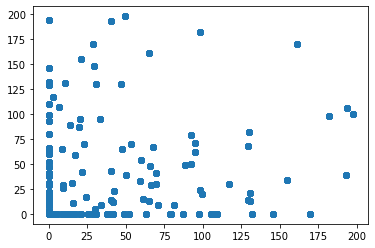

t+1 vs t-43


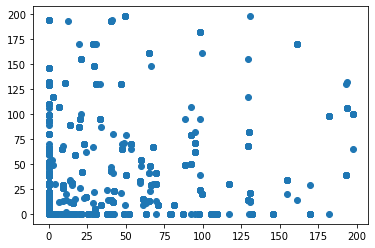

t+1 vs t-44


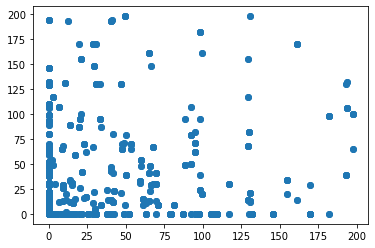

t+1 vs t-45


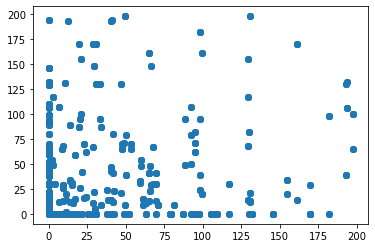

t+1 vs t-46


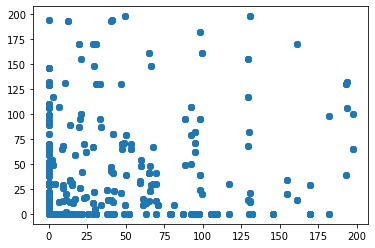

t+1 vs t-47


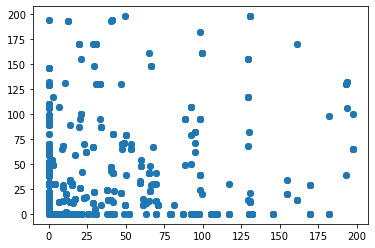

t+1 vs t-48


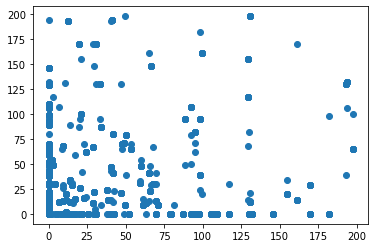

t+1 vs t-49


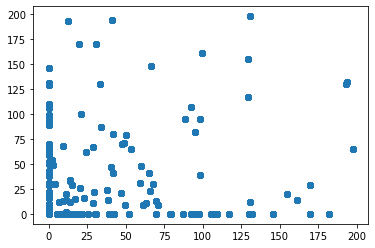

t+1 vs t-50


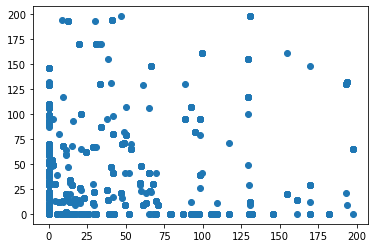

t+1 vs t-51


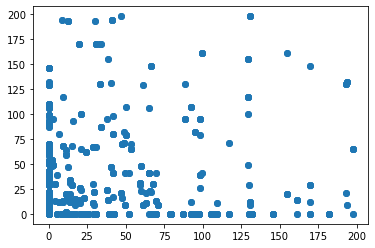

t+1 vs t-52


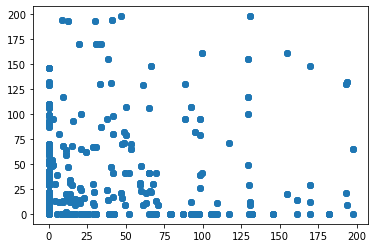

t+1 vs t-53


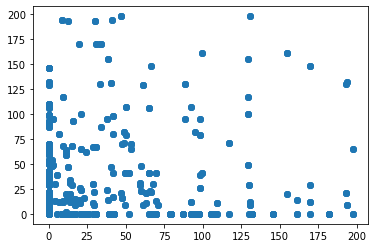

t+1 vs t-54


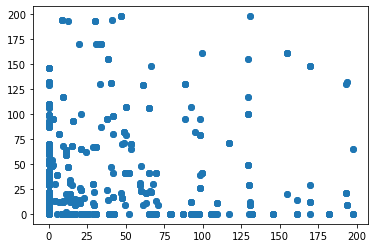

t+1 vs t-55


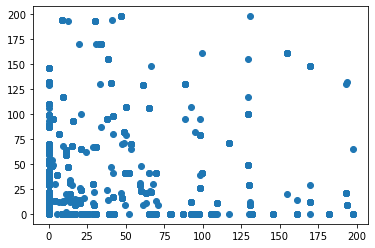

t+1 vs t-56


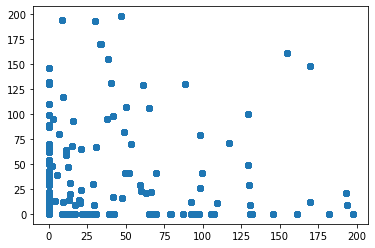

t+1 vs t-57


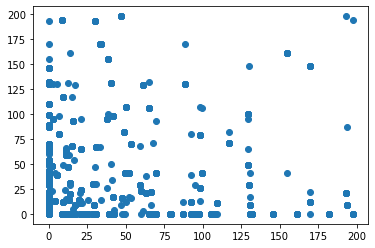

t+1 vs t-58


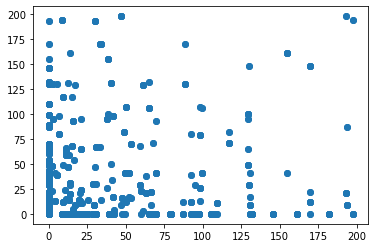

t+1 vs t-59


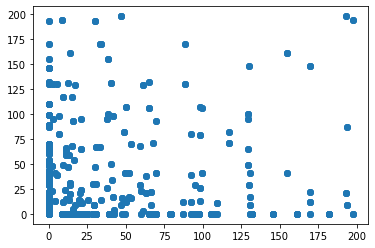

t+1 vs t-60


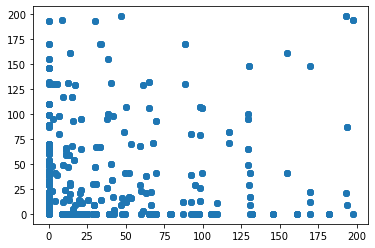

t+1 vs t-61


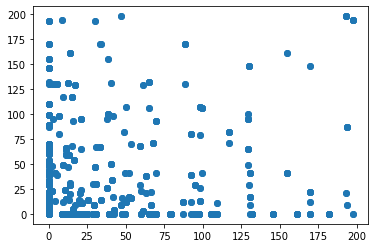

t+1 vs t-62


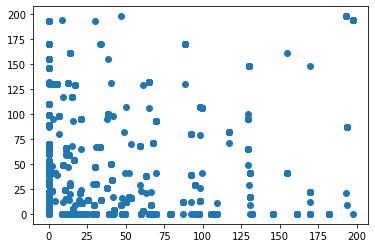

t+1 vs t-63


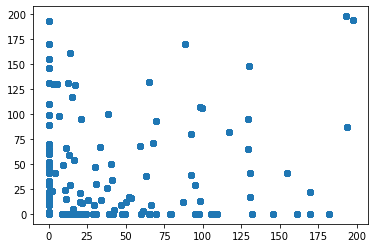

t+1 vs t-64


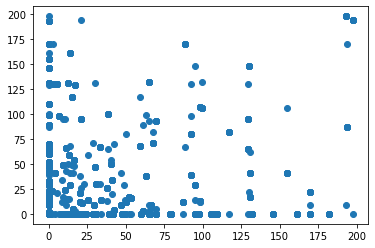

t+1 vs t-65


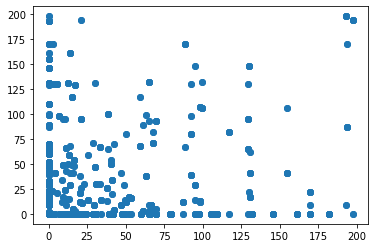

t+1 vs t-66


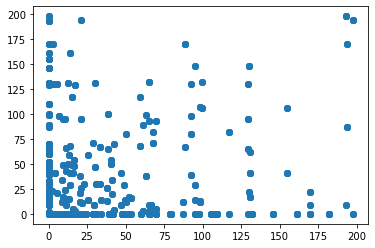

t+1 vs t-67


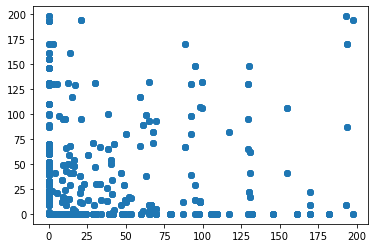

t+1 vs t-68


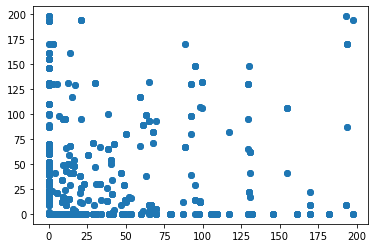

t+1 vs t-69


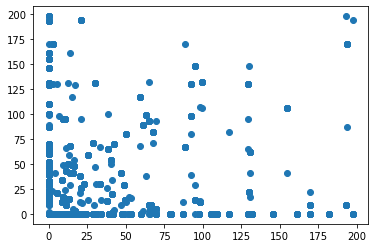

t+1 vs t-70


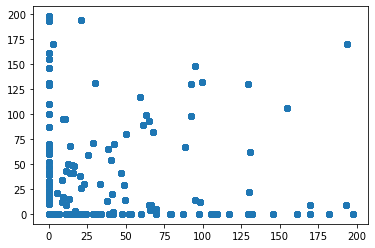

t+1 vs t-71


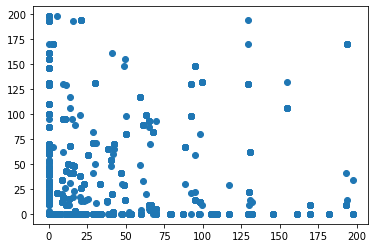

t+1 vs t-72


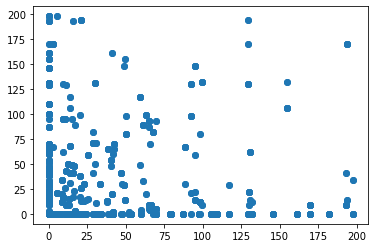

t+1 vs t-73


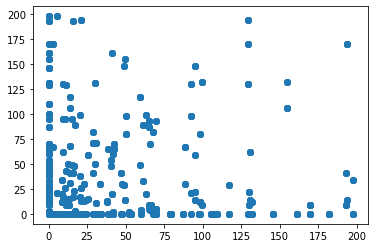

t+1 vs t-74


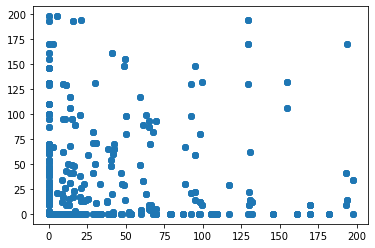

t+1 vs t-75


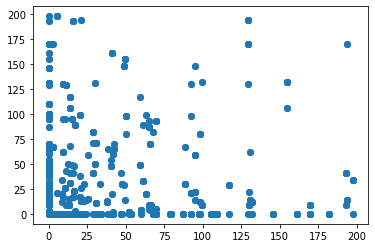

t+1 vs t-76


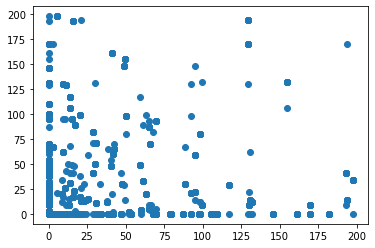

t+1 vs t-77


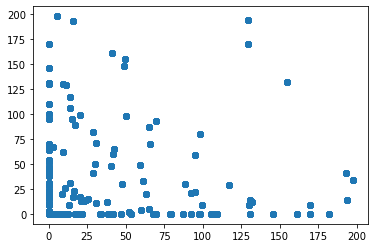

t+1 vs t-78


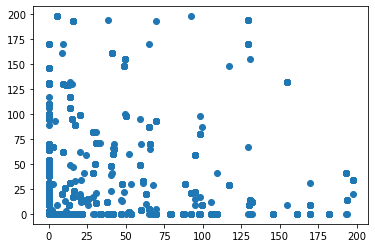

t+1 vs t-79


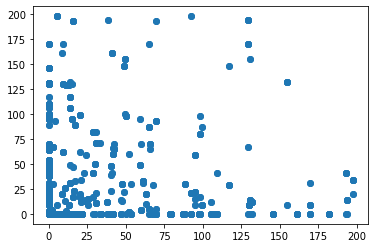

t+1 vs t-80


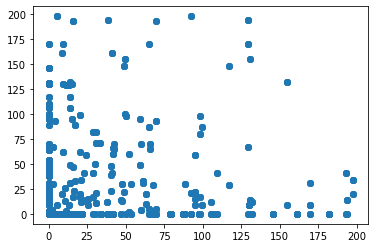

t+1 vs t-81


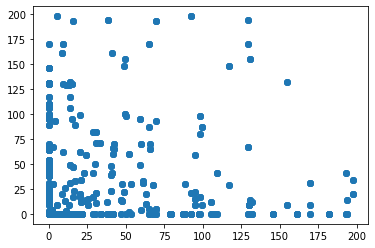

t+1 vs t-82


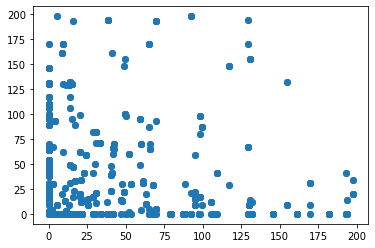

t+1 vs t-83


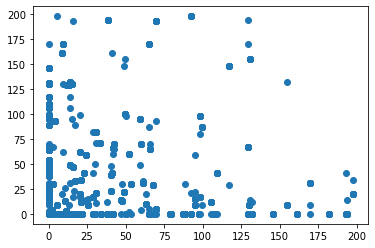

t+1 vs t-84


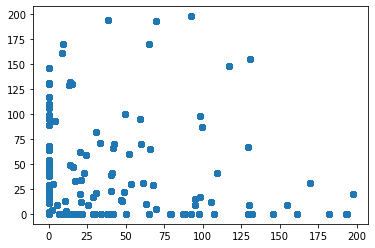

t+1 vs t-85


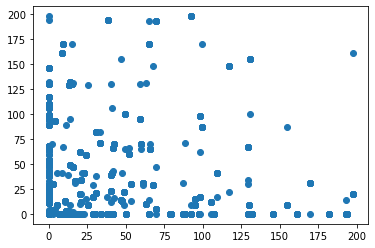

t+1 vs t-86


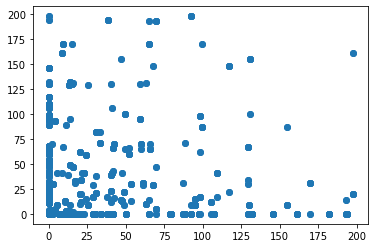

t+1 vs t-87


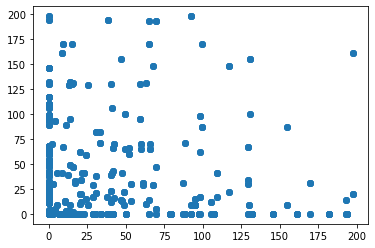

t+1 vs t-88


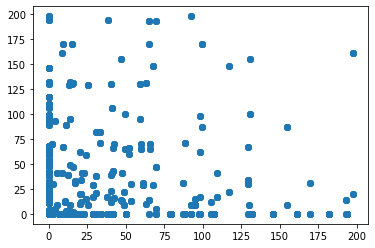

t+1 vs t-89


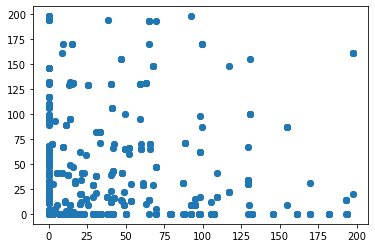

t+1 vs t-90


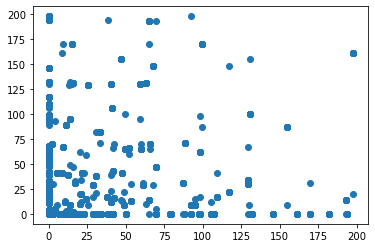

t+1 vs t-91


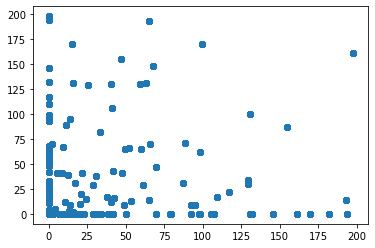

t+1 vs t-92


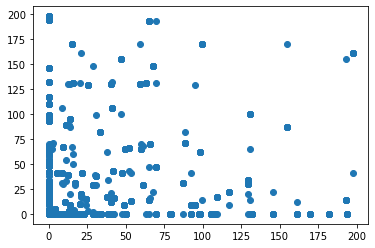

t+1 vs t-93


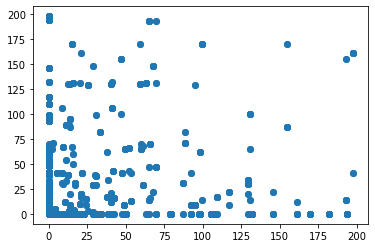

t+1 vs t-94


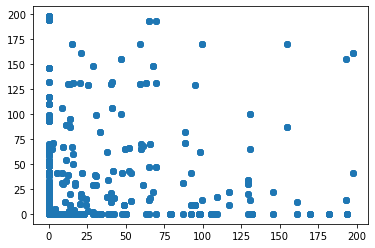

t+1 vs t-95


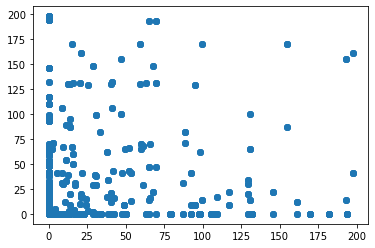

t+1 vs t-96


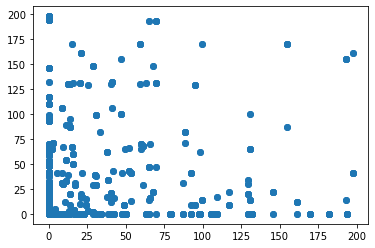

t+1 vs t-97


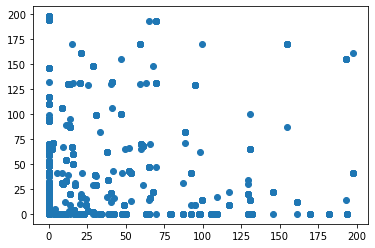

t+1 vs t-98


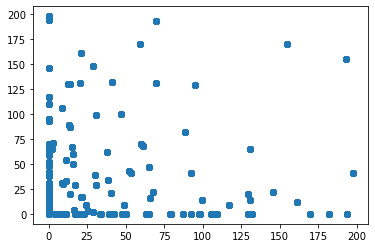

t+1 vs t-99


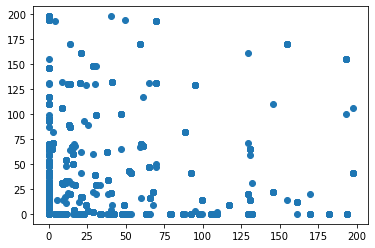

t+1 vs t-100


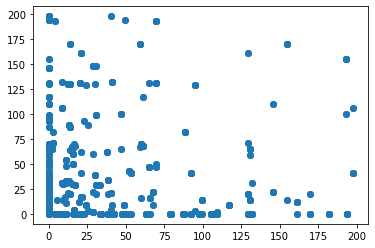

In [114]:
values = DataFrame(transacciones_super_weeks_df.values)
# lags = transacciones_super_weeks_df.size
lags = 100
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
for i in range(1,(lags + 1)):
	print('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
	pyplot.show()

In [115]:
"""
confirmando las graficas anteriores vemos que hay clara correlacion entre y(t+1) y sus 6 primeros lags y(t-6)
"""

'\nconfirmando las graficas anteriores vemos que hay clara correlacion entre y(t+1) y sus 6 primeros lags y(t-6)\n'

In [116]:
# 6. Time Series Autocorrelation Plots

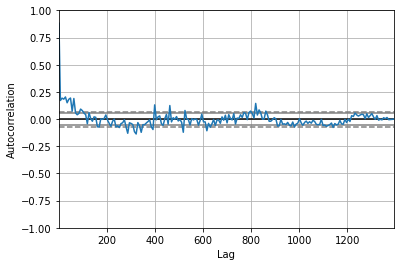

In [117]:
autocorrelation_plot(transacciones_super_weeks_df)
pyplot.show()

In [118]:
"""
Vemos que hay correlacion estadisticamente significativa pero baja entre y(t+1) y sus 100 primeros lags.
CONCLUSION: hacer una serie temporal con este dataset no servira para hacer predicciones temporales buenas
"""

'\nVemos que hay correlacion estadisticamente significativa pero baja entre y(t+1) y sus 100 primeros lags.\nCONCLUSION: hacer una serie temporal con este dataset no servira para hacer predicciones temporales buenas\n'

In [330]:
# vamos a agrupar el gasto por meses y a crear la serie temporal a ver que tal no sale asi la prediccion

In [331]:
# Load data using read_excel
transacciones_df = read_excel('20210513 mmelero (249236).xlsx', sheet_name='Hoja1')
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría  \
0           2020-07-24    -1.20          84.0                 parking_84   
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117   
2           2020-07-23   -13.53          70.0           supermercados_70   
3           2020-07-22   -51.40         222.0                   adsl_222   
4           2020-07-22   -11.00          70.0           supermercados_70   
...                ...      ...           ...                        ...   
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18   
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126   
1484        2016-09-05  -138.08         125.0                 cuotas_125   
1485        2016-09-01   -32.22          90.0            seguro_salud_90   
1486        2016-09-01   -33.00         434.0                 cuotas_434   

      Nivel categoría  iD categoría padre Nombre categoría padre  \
0                 2.0                 5.0            vehiculos_5   
1                 2.0                 8.0    gastos_personales_8   
2                 2.0                 4.0         alimentacion_4   
3                 3.0               521.0    Comunicaciones y TV   
4                 2.0                 4.0         alimentacion_4   
...               ...                 ...                    ...   
1482              3.0               576.0                 Nómina   
1483              3.0               478.0   tarjetas_credito_478   
1484              3.0               127.0      otros_pasivos_127   
1485              2.0                 6.0                salud_6   
1486              3.0               115.0           deportes_115   

                    Proveedor               Marca  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                        SPAR                SPAR   
3                Jazz Telecom             Jazztel   
4                   Mercadona           Mercadona   
...                       ...                 ...   
1482                      NaN                 NaN   
1483                      NaN                 NaN   
1484                      NaN                 NaN   
1485  Sanitas S.A. de Seguros             Sanitas   
1486       Royal Sport Center  Royal Sport Center   

                            Sector  Financiero  Transferencia  Unnamed: 12  \
0                              NaN       False          False          NaN   
1                              NaN       False          False          NaN   
2                    Supermercados       False          False          NaN   
3     Compañías telecomunicaciones       False          False          NaN   
4                    Supermercados       False          False          NaN   
...                            ...         ...            ...          ...   
1482                           NaN       False          False          NaN   
1483                           NaN        True           True          NaN   
1484                           NaN        True          False          NaN   
1485              Seguros de salud        True          False          NaN   
1486              Clubs deportivos       False          False          NaN   

      Unnamed: 13        ID  BALANCE BALANCE_DATE  
0             NaN  249236.0  1478.98   2020-07-26  
1             NaN       NaN      NaN          NaT  
2             NaN       NaN      NaN          NaT  
3             NaN       NaN      NaN          NaT  
4             NaN       NaN      NaN          NaT  
...           ...       ...      ...          ...  
1482          NaN       NaN      NaN          NaT  
1483          NaN       NaN      NaN          NaT  
1484          NaN       NaN      NaN          NaT  
1485          NaN       NaN      NaN          NaT  
1486          NaN       NaN      NaN          NaT  

[1487 rows x 17 columns]

In [332]:
# nos quedamos con la fecha en que nos dan los datos de las transacciones
last_date_obj = transacciones_df.loc[0,'BALANCE_DATE']
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [333]:
# nos quedamos con las transacciones de la categoria 'supermercados_70'
transacciones_super_df = transacciones_df[transacciones_df['ID Categoría'] == 70.0]
transacciones_super_df

Fecha transacción  Importe  ID Categoría  Nombre categoría  \
2           2020-07-23   -13.53          70.0  supermercados_70   
4           2020-07-22   -11.00          70.0  supermercados_70   
6           2020-07-22   -73.77          70.0  supermercados_70   
9           2020-07-20   -16.17          70.0  supermercados_70   
12          2020-07-20   -14.75          70.0  supermercados_70   
...                ...      ...           ...               ...   
1427        2016-11-03   -18.21          70.0  supermercados_70   
1436        2016-10-25  -147.50          70.0  supermercados_70   
1444        2016-10-24   -21.48          70.0  supermercados_70   
1456        2016-10-11    -8.74          70.0  supermercados_70   
1465        2016-10-06    -8.58          70.0  supermercados_70   

      Nivel categoría  iD categoría padre Nombre categoría padre  Proveedor  \
2                 2.0                 4.0         alimentacion_4       SPAR   
4                 2.0                 4.0         alimentacion_4  Mercadona   
6                 2.0                 4.0         alimentacion_4       Aldi   
9                 2.0                 4.0         alimentacion_4       SPAR   
12                2.0                 4.0         alimentacion_4       Lidl   
...               ...                 ...                    ...        ...   
1427              2.0                 4.0         alimentacion_4       SPAR   
1436              2.0                 4.0         alimentacion_4  Carrefour   
1444              2.0                 4.0         alimentacion_4       SPAR   
1456              2.0                 4.0         alimentacion_4       SPAR   
1465              2.0                 4.0         alimentacion_4       SPAR   

          Marca         Sector  Financiero  Transferencia  Unnamed: 12  \
2          SPAR  Supermercados       False          False          NaN   
4     Mercadona  Supermercados       False          False          NaN   
6          Aldi  Supermercados       False          False          NaN   
9          SPAR  Supermercados       False          False          NaN   
12         Lidl  Supermercados       False          False          NaN   
...         ...            ...         ...            ...          ...   
1427       SPAR  Supermercados       False          False          NaN   
1436  Carrefour  Supermercados       False          False          NaN   
1444       SPAR  Supermercados       False          False          NaN   
1456       SPAR  Supermercados       False          False          NaN   
1465       SPAR  Supermercados       False          False          NaN   

      Unnamed: 13  ID  BALANCE BALANCE_DATE  
2             NaN NaN      NaN          NaT  
4             NaN NaN      NaN          NaT  
6             NaN NaN      NaN          NaT  
9             NaN NaN      NaN          NaT  
12            NaN NaN      NaN          NaT  
...           ...  ..      ...          ...  
1427          NaN NaN      NaN          NaT  
1436          NaN NaN      NaN          NaT  
1444          NaN NaN      NaN          NaT  
1456          NaN NaN      NaN          NaT  
1465          NaN NaN      NaN          NaT  

[284 rows x 17 columns]

In [334]:
# nos quedamos con columnas desde 'Fecha transacción' hasta 'Importe'
transacciones_super_df = transacciones_super_df.iloc[:,0:2]
transacciones_super_df

Fecha transacción  Importe
2           2020-07-23   -13.53
4           2020-07-22   -11.00
6           2020-07-22   -73.77
9           2020-07-20   -16.17
12          2020-07-20   -14.75
...                ...      ...
1427        2016-11-03   -18.21
1436        2016-10-25  -147.50
1444        2016-10-24   -21.48
1456        2016-10-11    -8.74
1465        2016-10-06    -8.58

[284 rows x 2 columns]

In [ ]:
# ya no necesitamos transacciones_df
del transacciones_df

In [335]:
# renombramos columnas
transacciones_super_df.rename(columns={'Fecha transacción': 'FECHA', 'Importe': 'IMPORTE'}, inplace=True)
transacciones_super_df

FECHA  IMPORTE
2    2020-07-23   -13.53
4    2020-07-22   -11.00
6    2020-07-22   -73.77
9    2020-07-20   -16.17
12   2020-07-20   -14.75
...         ...      ...
1427 2016-11-03   -18.21
1436 2016-10-25  -147.50
1444 2016-10-24   -21.48
1456 2016-10-11    -8.74
1465 2016-10-06    -8.58

[284 rows x 2 columns]

In [336]:
# ordenamos las fechas por orden ascendente
transacciones_super_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)
transacciones_super_df

FECHA  IMPORTE
0   2016-10-06    -8.58
1   2016-10-11    -8.74
2   2016-10-24   -21.48
3   2016-10-25  -147.50
4   2016-11-03   -18.21
..         ...      ...
279 2020-07-20   -14.75
280 2020-07-20   -16.17
281 2020-07-22   -73.77
282 2020-07-22   -11.00
283 2020-07-23   -13.53

[284 rows x 2 columns]

In [337]:
# vamos a agrupar los valores y sumarlos por fecha
transacciones_super_df=transacciones_super_df.groupby(['FECHA']).sum()
transacciones_super_df

IMPORTE
FECHA              
2016-10-06    -8.58
2016-10-11    -8.74
2016-10-24   -21.48
2016-10-25  -147.50
2016-11-03   -18.21
...             ...
2020-07-15    -6.61
2020-07-17   -12.72
2020-07-20   -30.92
2020-07-22   -84.77
2020-07-23   -13.53

[214 rows x 1 columns]

In [338]:
# esto no va en produccion

# comprobamos que el indice sea datetime o DatetimeIndex
type(transacciones_super_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [339]:
# hacemos una columna con el indice
transacciones_super_df['FECHA'] = transacciones_super_df.index
transacciones_super_df

IMPORTE      FECHA
FECHA                         
2016-10-06    -8.58 2016-10-06
2016-10-11    -8.74 2016-10-11
2016-10-24   -21.48 2016-10-24
2016-10-25  -147.50 2016-10-25
2016-11-03   -18.21 2016-11-03
...             ...        ...
2020-07-15    -6.61 2020-07-15
2020-07-17   -12.72 2020-07-17
2020-07-20   -30.92 2020-07-20
2020-07-22   -84.77 2020-07-22
2020-07-23   -13.53 2020-07-23

[214 rows x 2 columns]

In [340]:
# esto no va en produccion

# comprobamos que 'FECHA' sea datetime
transacciones_super_df.dtypes

IMPORTE           float64
FECHA      datetime64[ns]
dtype: object

In [341]:
# sumamos la cuantia de las transacciones de cada mes y la suma la ponemos fecha del inicio de cada mes
transacciones_month_df = transacciones_super_df.groupby(pandas.Grouper(key='FECHA', freq="MS")).sum()
transacciones_month_df

IMPORTE
FECHA              
2016-10-01  -186.30
2016-11-01  -181.69
2016-12-01  -265.52
2017-01-01  -458.75
2017-02-01  -181.12
...             ...
2020-03-01     0.00
2020-04-01     0.00
2020-05-01  -344.47
2020-06-01  -293.41
2020-07-01  -247.50

[46 rows x 1 columns]

In [342]:
# para que los datos sean más fáciles de interpretar vamos a hacerlos todos positivos multiplicándolos por '-1'
transacciones_month_df['IMPORTE'] = -transacciones_month_df['IMPORTE']
transacciones_month_df

IMPORTE
FECHA              
2016-10-01   186.30
2016-11-01   181.69
2016-12-01   265.52
2017-01-01   458.75
2017-02-01   181.12
...             ...
2020-03-01    -0.00
2020-04-01    -0.00
2020-05-01   344.47
2020-06-01   293.41
2020-07-01   247.50

[46 rows x 1 columns]

In [343]:
# hacemos el estudio de la serie temporal

In [344]:
# Time Series Data Visualization with Python
# https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [345]:
# 1. Time Series Line Plot

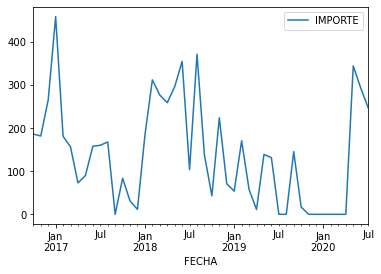

In [346]:
transacciones_month_df.plot()
pyplot.show()

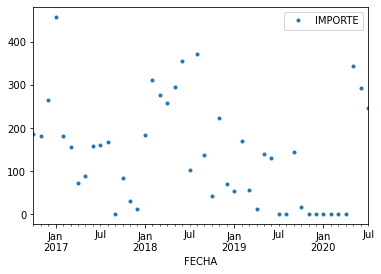

In [347]:
transacciones_month_df.plot(style='.')
pyplot.show()

In [348]:
"""
no parece que sea una serie temporal con una predictibilidad muy alta pues presenta grandes y rapidas variaciones
"""

'\nno parece que sea una serie temporal con una predictibilidad muy alta pues presenta grandes y rapidas variaciones\n'

In [349]:
# 2. Time Series Histogram and Density Plots

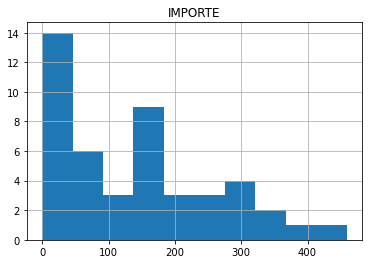

In [350]:
transacciones_month_df.hist()
pyplot.show()

In [351]:
"""
Es una distribucion asimetrica a la derecha: moda (0) < mediana (138.18) < media (140.20).

min = 0
q1  = 20.49 
q2  = 138.18
q3  = 214.65
max = 458.75

y ahora que los datos estan agrupados por meses vemos que es mas dispersa que cuando los datos estaban agrupados por semanas
"""

'\nEs una distribucion asimetrica a la derecha: moda (0) < mediana (138.18) < media (140.20).\n\nmin = 0\nq1  = 20.49 \nq2  = 138.18\nq3  = 214.65\nmax = 458.75\n\ny ahora que los datos estan agrupados por meses vemos que es mas dispersa que cuando los datos estaban agrupados por semanas\n'

In [352]:
transacciones_month_df.describe()

IMPORTE
count   46.000000
mean   140.204130
std    122.445984
min     -0.000000
25%     20.490000
50%    138.180000
75%    214.657500
max    458.750000

In [353]:
# calculamos la moda
stat_mode = statistics.mode(transacciones_month_df['IMPORTE'])
stat_mode

-0.0

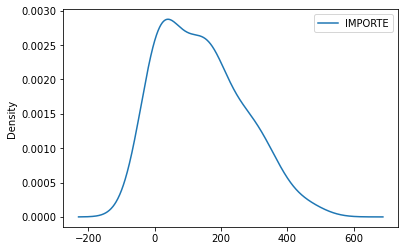

In [354]:
transacciones_month_df.plot(kind='kde')
pyplot.show()

In [355]:
"""
El diagrama de densidad confirma las conclusiones del histograma.
Ahora que las transacciones estan agrupadas por meses la distribucion es más dispersa que cuando estaban agrupados por semanas.
"""

'\nEl diagrama de densidad confirma las conclusiones del histograma.\nAhora que las transacciones estan agrupadas por meses la distribucion es más dispersa que cuando estaban agrupados por semanas.\n'

In [356]:
# 3. Time Series Box and Whisker Plots by Interval

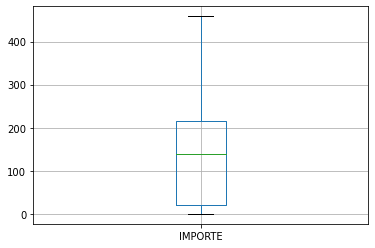

In [357]:
transacciones_month_df.boxplot()
pyplot.show()

In [358]:
"""
El boxplot nos confirma que ahora hay más dispersion en los datos y que ya no hay outliers.
"""

'\nEl boxplot nos confirma que ahora hay más dispersion en los datos y que ya no hay outliers.\n'

In [359]:
# 4. Time Series Heat Maps

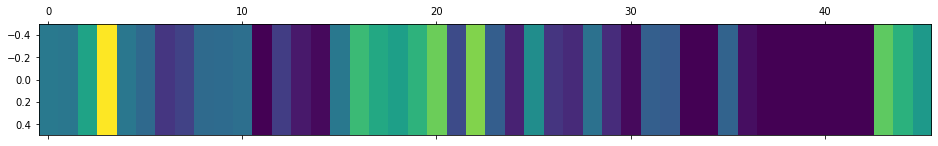

In [360]:
pyplot.matshow(transacciones_month_df.T, interpolation=None, aspect='auto')
pyplot.show()

In [361]:
"""
El mapa de calor nos muestra más dispersion en los datos pero ahora los cambios de valor son más suaves que cuando los
datos estaban agrupados por semanas
"""

'\nEl mapa de calor nos muestra más dispersion en los datos pero ahora los cambios de valor son más suaves que cuando los\ndatos estaban agrupados por semanas\n'

In [362]:
# 5. Time Series Lag Scatter Plots

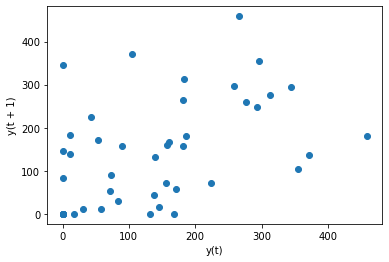

In [363]:
lag_plot(transacciones_month_df)
pyplot.show()

In [364]:
"""
No vemos correlacion entre y(t+1) e y(t)
"""

'\nNo vemos correlacion entre y(t+1) e y(t)\n'

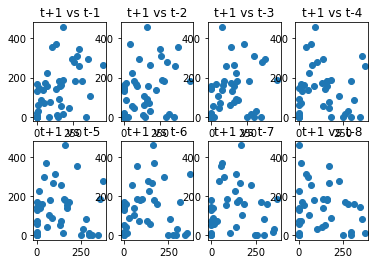

In [365]:
values = DataFrame(transacciones_month_df.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
	ax = pyplot.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

In [366]:
"""
Seguimos sin ver clara correlacion (diagonal) entre y(t+1) y sus 8 primeros lags
"""

'\nSeguimos sin ver clara correlacion (diagonal) entre y(t+1) y sus 8 primeros lags\n'

t+1 vs t-1


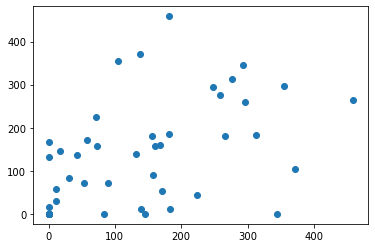

t+1 vs t-2


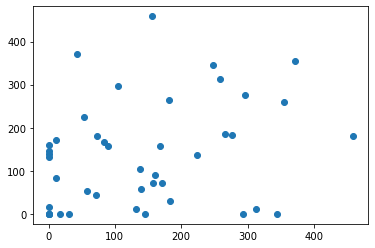

t+1 vs t-3


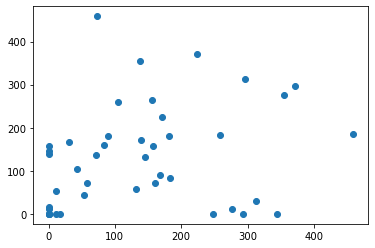

t+1 vs t-4


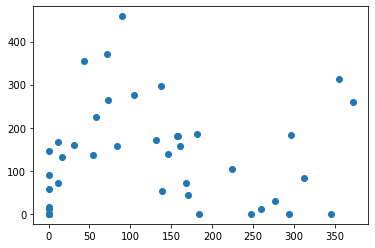

t+1 vs t-5


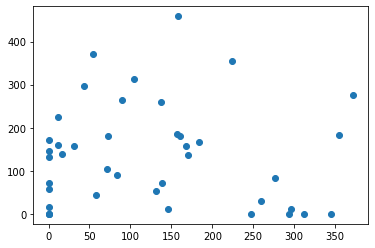

t+1 vs t-6


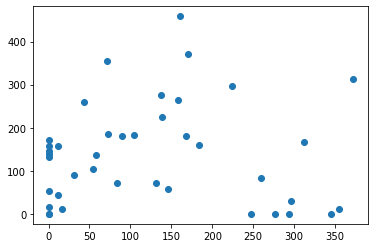

t+1 vs t-7


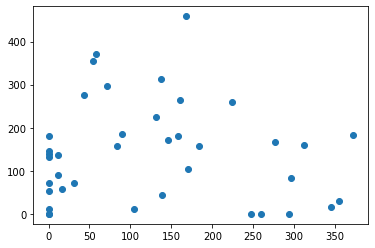

t+1 vs t-8


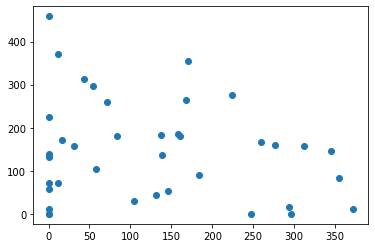

t+1 vs t-9


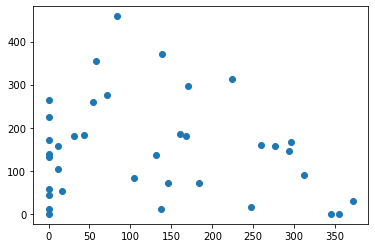

t+1 vs t-10


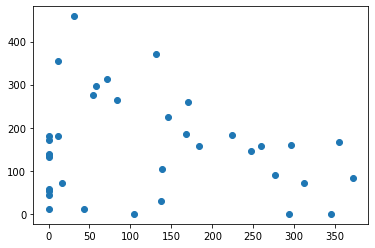

t+1 vs t-11


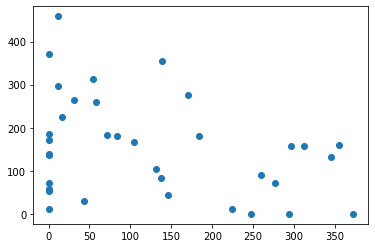

t+1 vs t-12


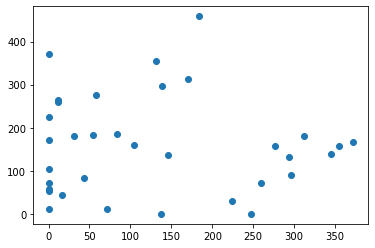

t+1 vs t-13


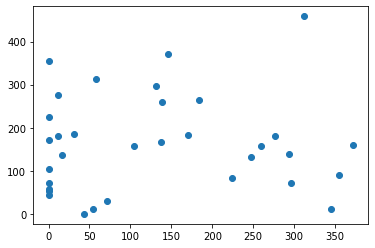

t+1 vs t-14


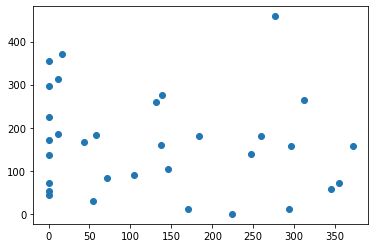

t+1 vs t-15


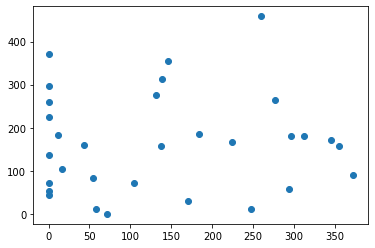

t+1 vs t-16


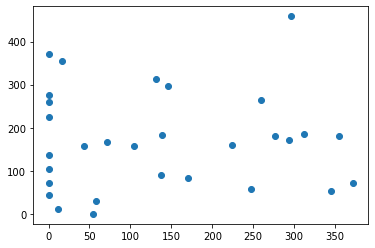

t+1 vs t-17


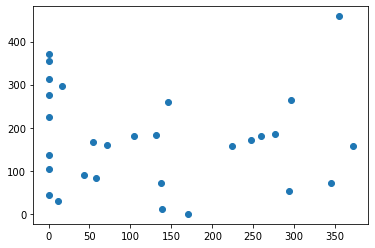

t+1 vs t-18


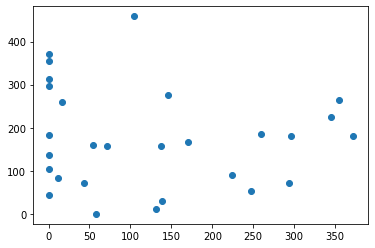

t+1 vs t-19


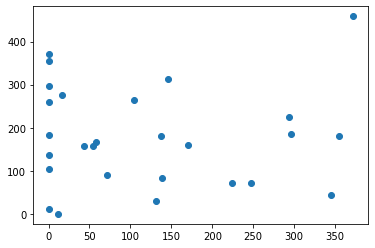

t+1 vs t-20


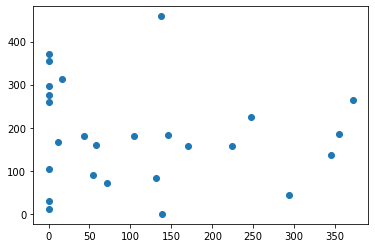

t+1 vs t-21


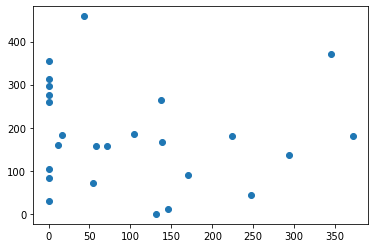

t+1 vs t-22


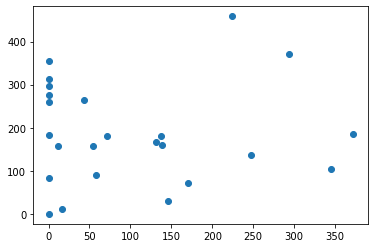

t+1 vs t-23


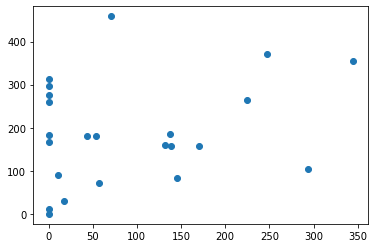

t+1 vs t-24


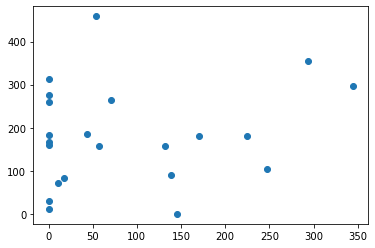

t+1 vs t-25


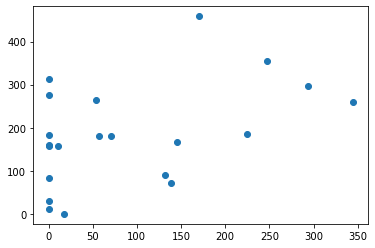

t+1 vs t-26


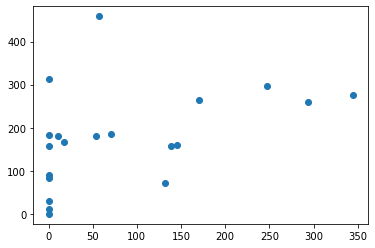

t+1 vs t-27


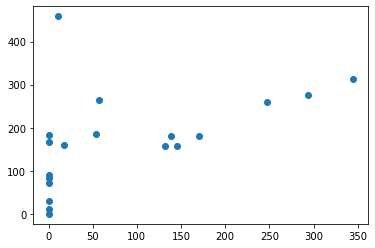

t+1 vs t-28


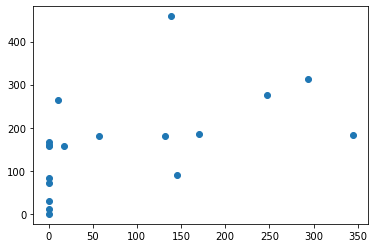

t+1 vs t-29


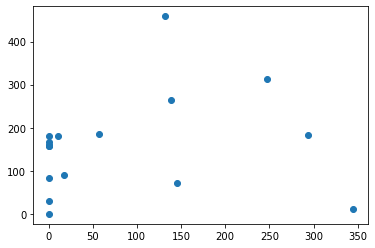

t+1 vs t-30


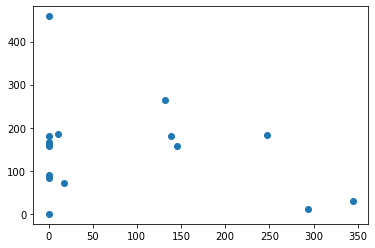

t+1 vs t-31


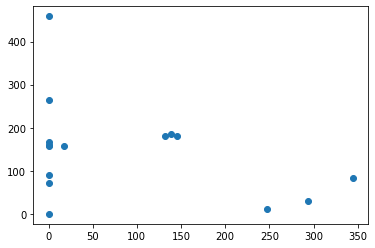

t+1 vs t-32


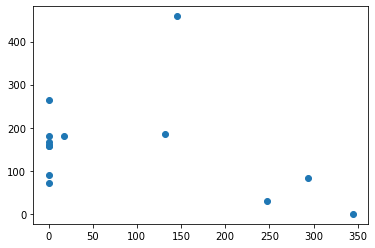

t+1 vs t-33


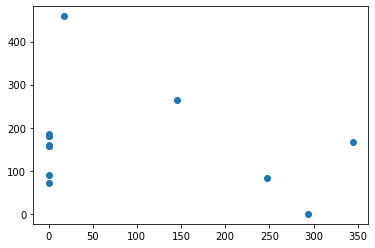

t+1 vs t-34


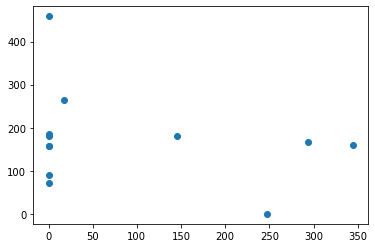

t+1 vs t-35


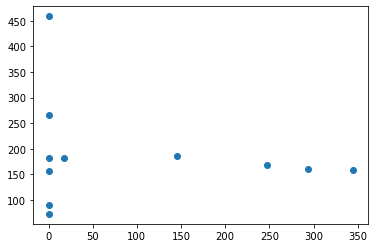

t+1 vs t-36


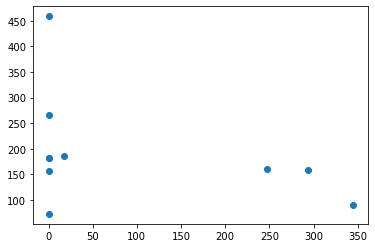

t+1 vs t-37


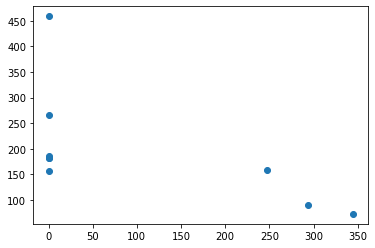

t+1 vs t-38


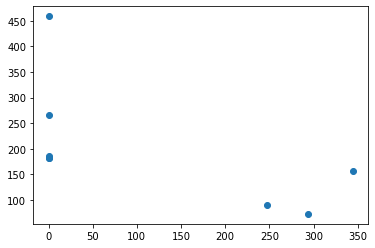

t+1 vs t-39


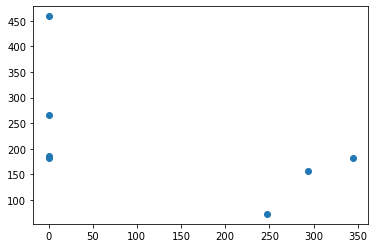

t+1 vs t-40


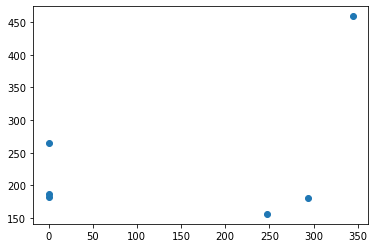

t+1 vs t-41


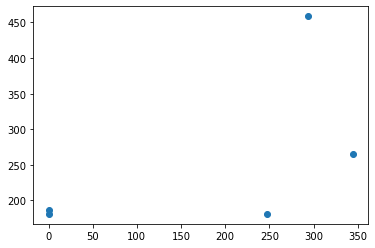

t+1 vs t-42


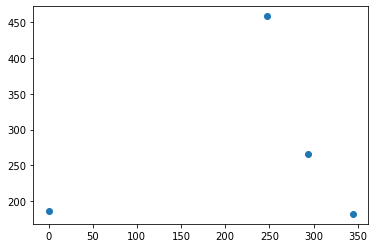

t+1 vs t-43


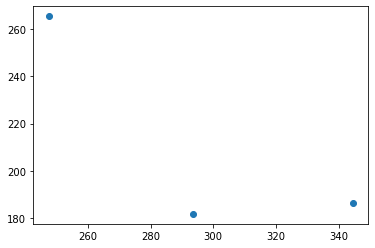

t+1 vs t-44


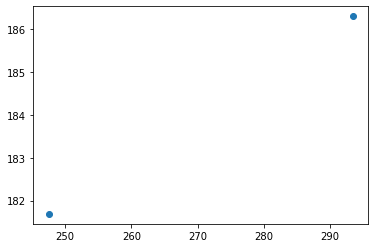

t+1 vs t-45


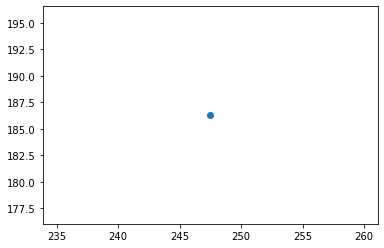

t+1 vs t-46


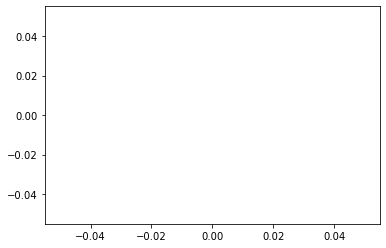

In [367]:
values = DataFrame(transacciones_month_df.values)
lags = transacciones_month_df.size
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
for i in range(1,(lags + 1)):
	print('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
	pyplot.show()

In [368]:
"""
No vemos correlacion entre y(t+1) y ninguno de sus flags anteriores.
Y vemos aun menos correlacion a medida que vemos lags mas atrasados
"""

'\nNo vemos correlacion entre y(t+1) y ninguno de sus flags anteriores.\nY vemos aun menos correlacion a medida que vemos lags mas atrasados\n'

In [369]:
# 6. Time Series Autocorrelation Plots

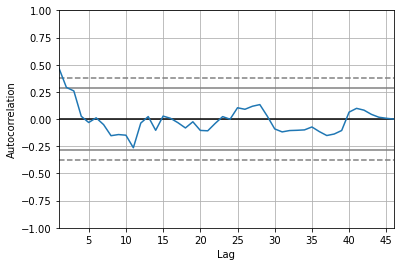

In [370]:
autocorrelation_plot(transacciones_month_df)
pyplot.show()

In [371]:
"""
No vemos correlacion estadisticamente significativa con practicamente ninguno de sus lags anteriores.

CONCLUSION 1: la serie temporal no es modelizable.
CONCLUSION 2: Vamos a rellenar las fechas huecas con el ultimo valor valido a ver si asi la serie temporal es mas modelizable
"""

'\nNo vemos correlacion estadisticamente significativa con practicamente ninguno de sus lags anteriores.\n\nCONCLUSION 1: la serie temporal no es modelizable.\nCONCLUSION 2: Vamos a rellenar las fechas huecas con el ultimo valor valido a ver si asi la serie temporal es mas modelizable\n'

In [372]:
# sumamos la cuantia de las transacciones de cada mes y a la suma la ponemos fecha del inicio de cada mes
transacciones_month_df = transacciones_super_df.groupby(pandas.Grouper(key='FECHA', freq="MS")).sum()
transacciones_month_df

IMPORTE
FECHA              
2016-10-01  -186.30
2016-11-01  -181.69
2016-12-01  -265.52
2017-01-01  -458.75
2017-02-01  -181.12
...             ...
2020-03-01     0.00
2020-04-01     0.00
2020-05-01  -344.47
2020-06-01  -293.41
2020-07-01  -247.50

[46 rows x 1 columns]

In [ ]:
# ya no necesitamos transacciones_super_df
del transacciones_super_df

In [373]:
# en transacciones_mfilled_df rellenaremos las fechas sin importe con el importe valido inmediatamente anterior
transacciones_mfilled_df = transacciones_month_df.copy()
transacciones_mfilled_df

IMPORTE
FECHA              
2016-10-01  -186.30
2016-11-01  -181.69
2016-12-01  -265.52
2017-01-01  -458.75
2017-02-01  -181.12
...             ...
2020-03-01     0.00
2020-04-01     0.00
2020-05-01  -344.47
2020-06-01  -293.41
2020-07-01  -247.50

[46 rows x 1 columns]

In [ ]:
# ya no necesitamos transacciones_month_df
del transacciones_month_df

In [374]:
# hacemos una columna con la fecha del indice
transacciones_mfilled_df['FECHA'] = transacciones_mfilled_df.index
transacciones_mfilled_df

IMPORTE      FECHA
FECHA                         
2016-10-01  -186.30 2016-10-01
2016-11-01  -181.69 2016-11-01
2016-12-01  -265.52 2016-12-01
2017-01-01  -458.75 2017-01-01
2017-02-01  -181.12 2017-02-01
...             ...        ...
2020-03-01     0.00 2020-03-01
2020-04-01     0.00 2020-04-01
2020-05-01  -344.47 2020-05-01
2020-06-01  -293.41 2020-06-01
2020-07-01  -247.50 2020-07-01

[46 rows x 2 columns]

In [375]:
# indice de fechas hasta el ultimo dia del mes para el cual hay datos
idx = date_range(start=transacciones_mfilled_df.FECHA.min(), end=transacciones_mfilled_df.FECHA.max() + MonthEnd(1))
idx

DatetimeIndex(['2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04',
               '2016-10-05', '2016-10-06', '2016-10-07', '2016-10-08',
               '2016-10-09', '2016-10-10',
               ...
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', length=1400, freq='D')

In [376]:
# esto no va en produccion

# comprobamos que el indice de transacciones_mfilled_df es de tipo DatetimeIndex 
type(transacciones_mfilled_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [377]:
# rellenamos las missing dates en el indice
transacciones_mfilled_df = transacciones_mfilled_df.reindex(idx, fill_value='NaN')
transacciones_mfilled_df

IMPORTE      FECHA
2016-10-01  -186.3 2016-10-01
2016-10-02     NaN        NaT
2016-10-03     NaN        NaT
2016-10-04     NaN        NaT
2016-10-05     NaN        NaT
...            ...        ...
2020-07-27     NaN        NaT
2020-07-28     NaN        NaT
2020-07-29     NaN        NaT
2020-07-30     NaN        NaT
2020-07-31     NaN        NaT

[1400 rows x 2 columns]

In [378]:
# hacemos drop de la columna FECHA
transacciones_mfilled_df.drop(columns='FECHA', inplace=True)
transacciones_mfilled_df

IMPORTE
2016-10-01  -186.3
2016-10-02     NaN
2016-10-03     NaN
2016-10-04     NaN
2016-10-05     NaN
...            ...
2020-07-27     NaN
2020-07-28     NaN
2020-07-29     NaN
2020-07-30     NaN
2020-07-31     NaN

[1400 rows x 1 columns]

In [379]:
# esto no va en produccion

# comprobamos si el tipo de IMPORTE es numerico
transacciones_mfilled_df.dtypes

IMPORTE    object
dtype: object

In [380]:
# pasamos IMPORTE a formato 'numeric'
transacciones_mfilled_ser = transacciones_mfilled_df.T.squeeze()
transacciones_mfilled_ser

2016-10-01   -186.3
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
              ...  
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN
Freq: D, Name: IMPORTE, Length: 1400, dtype: object

In [381]:
transacciones_mfilled_ser = to_numeric(transacciones_mfilled_ser, errors='coerce')
transacciones_mfilled_ser

2016-10-01   -186.3
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
              ...  
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN
Freq: D, Name: IMPORTE, Length: 1400, dtype: float64

In [382]:
transacciones_mfilled_df = DataFrame(transacciones_mfilled_ser)
del transacciones_mfilled_ser
transacciones_mfilled_df

IMPORTE
2016-10-01   -186.3
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
...             ...
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN

[1400 rows x 1 columns]

In [383]:
# esto no va en produccion

# comprobamos si el tipo de IMPORTE es numerico
transacciones_mfilled_df.dtypes

IMPORTE    float64
dtype: object

In [384]:
# rellenamos los NaN con el ultimo valor numérico anterior
transacciones_mfilled_df['IMPORTE'].fillna(method='ffill', inplace=True)
transacciones_mfilled_df

IMPORTE
2016-10-01   -186.3
2016-10-02   -186.3
2016-10-03   -186.3
2016-10-04   -186.3
2016-10-05   -186.3
...             ...
2020-07-27   -247.5
2020-07-28   -247.5
2020-07-29   -247.5
2020-07-30   -247.5
2020-07-31   -247.5

[1400 rows x 1 columns]

In [385]:
# para que los datos sean más fáciles de interpretar vamos a hacerlos todos positivos multiplicándolos por '-1'
transacciones_mfilled_df['IMPORTE'] = -transacciones_mfilled_df['IMPORTE']
transacciones_mfilled_df

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [386]:
# antes de hacer una prediccion con prophet vamos a comprobar si este serie 'transacciones_mfilled_df' es modelizable

In [387]:
# Time Series Data Visualization with Python
# https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [388]:
# 1. Time Series Line Plot

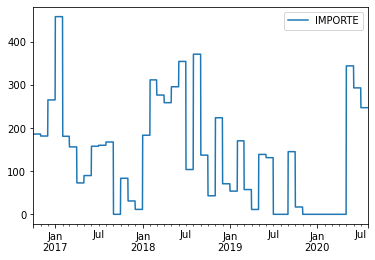

In [389]:
transacciones_mfilled_df.plot()
pyplot.show()

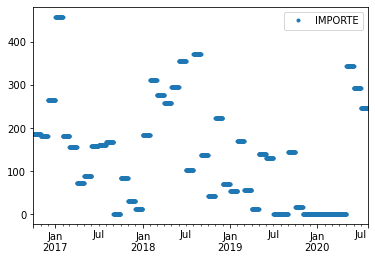

In [390]:
transacciones_mfilled_df.plot(style='.')
pyplot.show()

In [391]:
"""
no podemos obtener conclusiones claras sobre si esta serie es facil de modelizar
"""

'\nno podemos obtener conclusiones claras sobre si esta serie es facil de modelizar\n'

In [392]:
# 2. Time Series Histogram and Density Plots

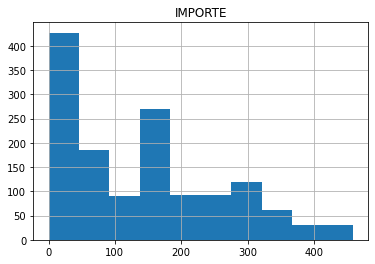

In [393]:
transacciones_mfilled_df.hist()
pyplot.show()

In [394]:
"""
ahora que los datos estan agrupados por meses y rellenando los huecos con el ultimo valor valido la distribucion de los mismo
sale aun mas dispersa.

Es una distribucion asimetrica a la derecha: moda (0) < mediana (137.34) < media (139.95).

min = 0
q1  = 16.99
q2  = 137.34
q3  = 224.11
max = 458.75
"""

'\nahora que los datos estan agrupados por meses y rellenando los huecos con el ultimo valor valido la distribucion de los mismo\nsale aun mas dispersa.\n\nEs una distribucion asimetrica a la derecha: moda (0) < mediana (137.34) < media (139.95).\n\nmin = 0\nq1  = 16.99\nq2  = 137.34\nq3  = 224.11\nmax = 458.75\n'

In [395]:
transacciones_mfilled_df.describe()

IMPORTE
count  1400.000000
mean    139.956729
std     121.329890
min      -0.000000
25%      16.990000
50%     137.340000
75%     224.110000
max     458.750000

In [396]:
# calculamos la moda
stat_mode = statistics.mode(transacciones_mfilled_df['IMPORTE'])
stat_mode

-0.0

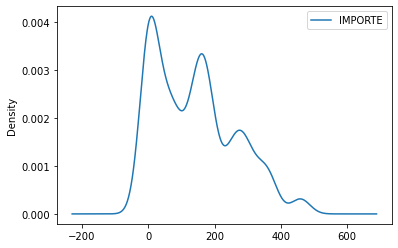

In [397]:
transacciones_mfilled_df.plot(kind='kde')
pyplot.show()

In [398]:
"""
el diagrama de densidad nos muestra que los gastos mas comunes (las modas) en la distribucion son 0 y 180 eur aproximadamente
"""

'\nel diagrama de densidad nos muestra que los gastos mas comunes (las modas) en la distribucion son 0 y 180 eur aproximadamente\n'

In [399]:
# 3. Time Series Box and Whisker Plots by Interval

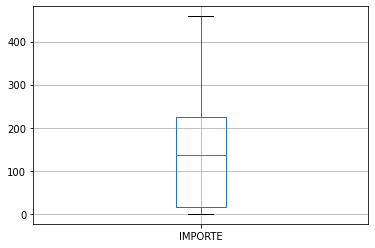

In [400]:
transacciones_mfilled_df.boxplot()
pyplot.show()

In [401]:
"""
El boxplot sale igual que el de los datos agrupados por meses sin rellenar las fechas intermedias.
Sigue sin haber outliers.
"""

'\nEl boxplot sale igual que el de los datos agrupados por meses sin rellenar las fechas intermedias.\nSigue sin haber outliers.\n'

In [402]:
# 4. Time Series Heat Maps

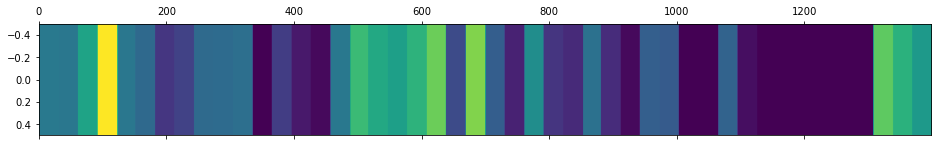

In [403]:
pyplot.matshow(transacciones_mfilled_df.T, interpolation=None, aspect='auto')
pyplot.show()

In [404]:
"""
El mapa de color sale igual que con los datos agrupados por meses sin rellenar las fechas intermedias
"""

'\nEl mapa de color sale igual que con los datos agrupados por meses sin rellenar las fechas intermedias\n'

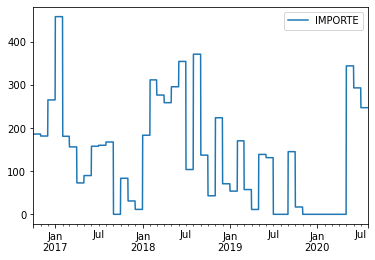

In [405]:
transacciones_mfilled_df.plot()
pyplot.show()

In [406]:
# 5. Time Series Lag Scatter Plots

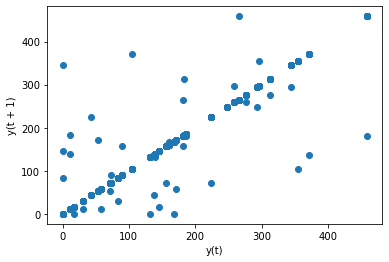

In [407]:
lag_plot(transacciones_mfilled_df)
pyplot.show()

In [408]:
"""
Vemos una correlacion muy clara entre y(t+1) e y(t); sobretodo para valores inferiores a 200 eur
"""

'\nVemos una correlacion muy clara entre y(t+1) e y(t); sobretodo para valores inferiores a 200 eur\n'

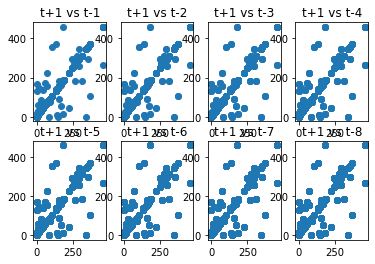

In [409]:
values = DataFrame(transacciones_mfilled_df.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
	ax = pyplot.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

In [410]:
"""
Seguimos viendo correlaciones muy claras entre y(t+1) y sus 8 primeros lags
"""

'\nSeguimos viendo correlaciones muy claras entre y(t+1) y sus 8 primeros lags\n'

t+1 vs t-1


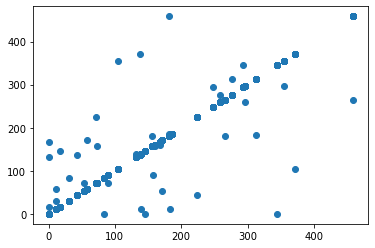

t+1 vs t-2


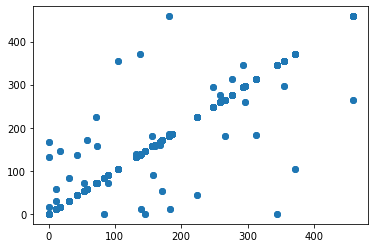

t+1 vs t-3


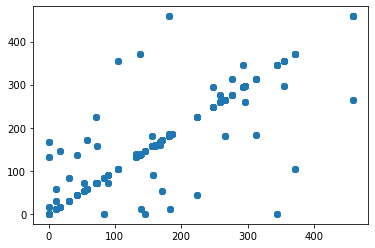

t+1 vs t-4


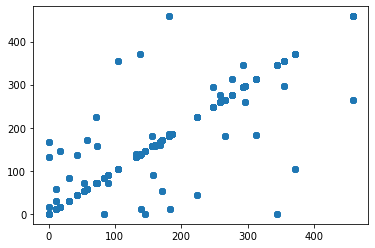

t+1 vs t-5


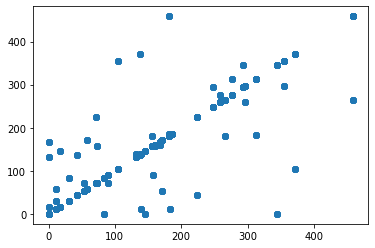

t+1 vs t-6


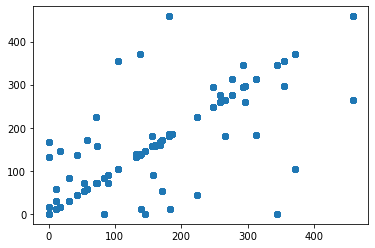

t+1 vs t-7


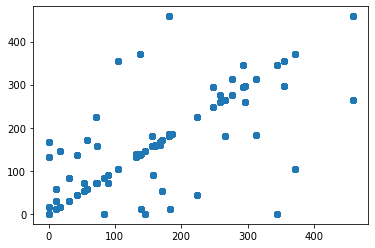

t+1 vs t-8


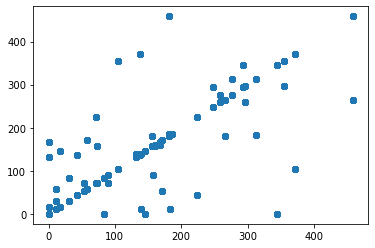

t+1 vs t-9


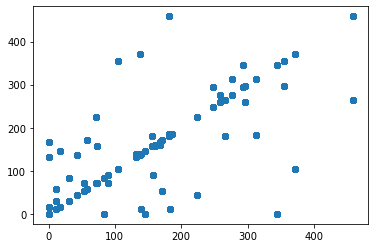

t+1 vs t-10


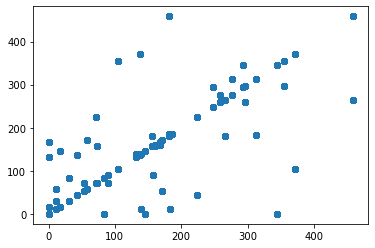

t+1 vs t-11


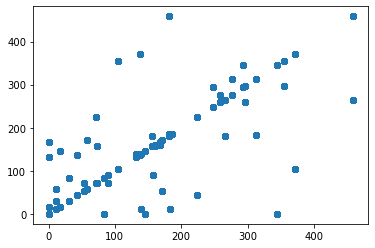

t+1 vs t-12


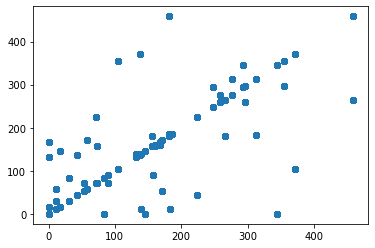

t+1 vs t-13


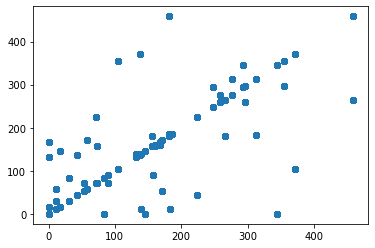

t+1 vs t-14


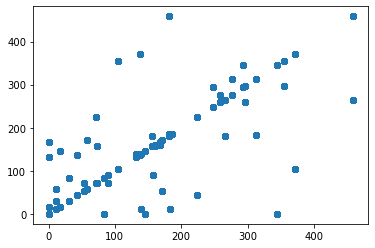

t+1 vs t-15


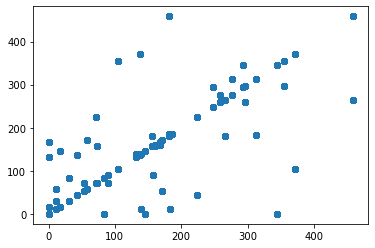

t+1 vs t-16


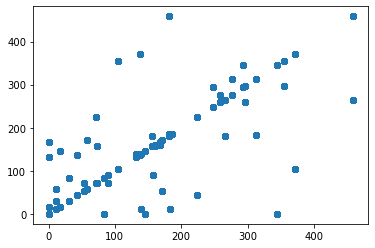

t+1 vs t-17


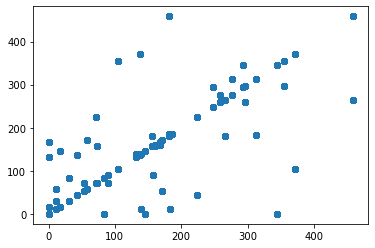

t+1 vs t-18


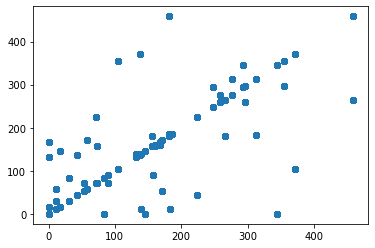

t+1 vs t-19


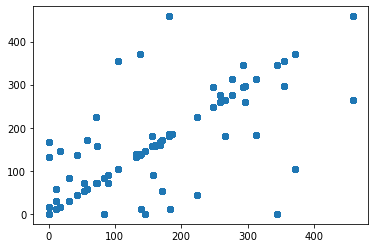

t+1 vs t-20


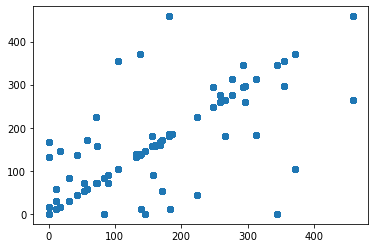

t+1 vs t-21


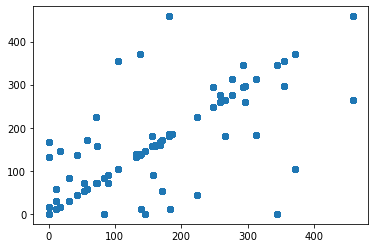

t+1 vs t-22


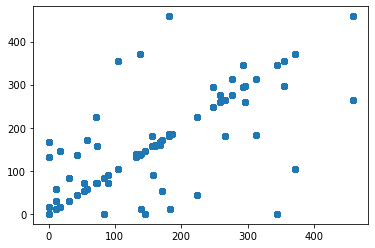

t+1 vs t-23


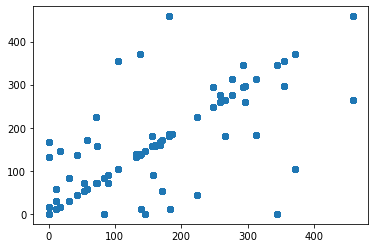

t+1 vs t-24


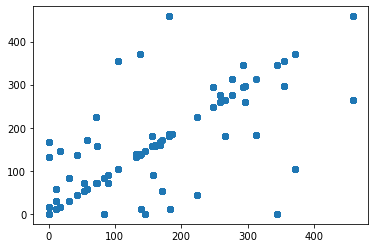

t+1 vs t-25


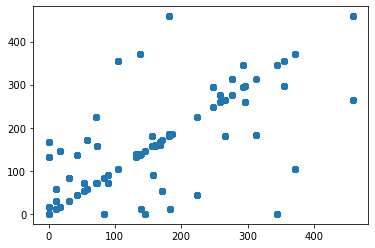

t+1 vs t-26


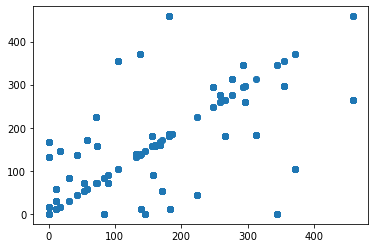

t+1 vs t-27


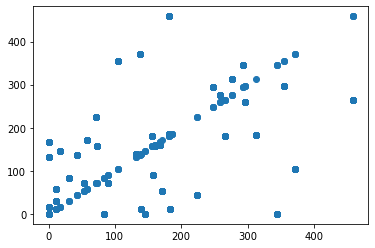

t+1 vs t-28


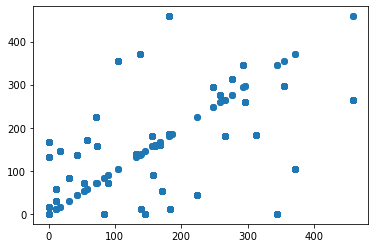

t+1 vs t-29


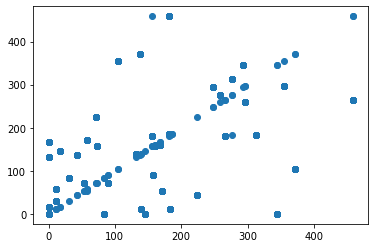

t+1 vs t-30


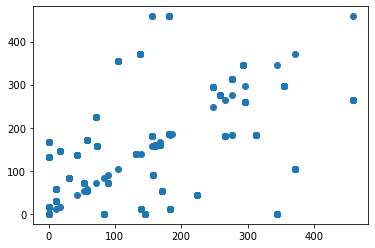

t+1 vs t-31


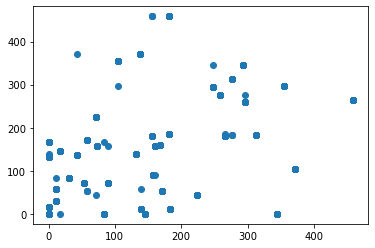

t+1 vs t-32


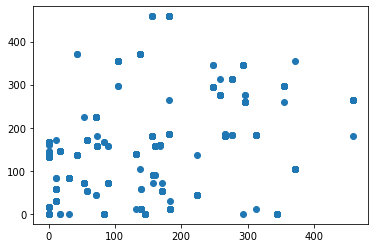

t+1 vs t-33


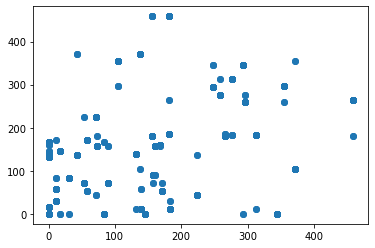

t+1 vs t-34


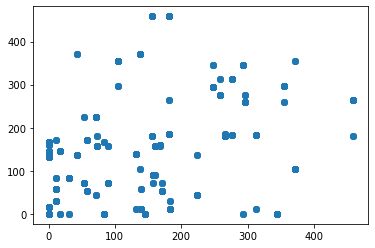

t+1 vs t-35


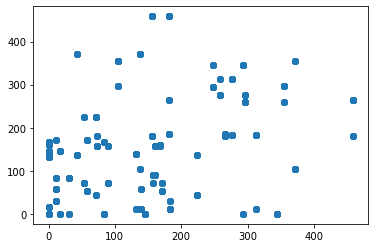

t+1 vs t-36


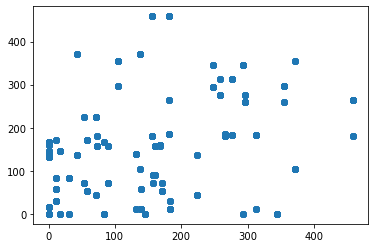

t+1 vs t-37


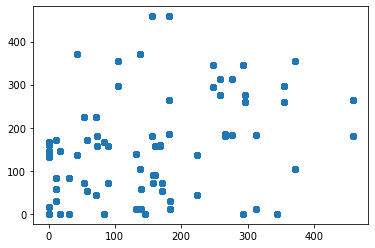

t+1 vs t-38


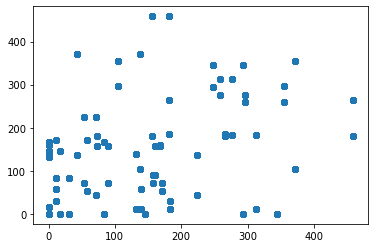

t+1 vs t-39


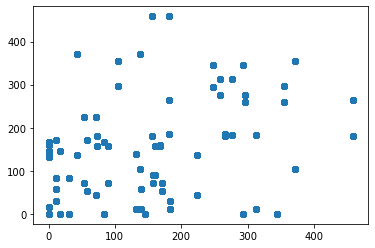

t+1 vs t-40


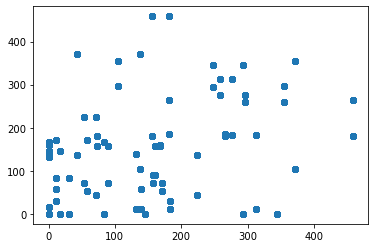

t+1 vs t-41


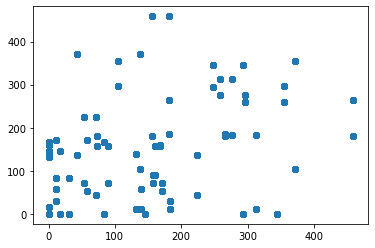

t+1 vs t-42


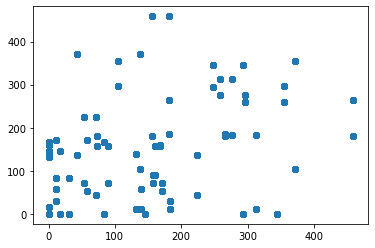

t+1 vs t-43


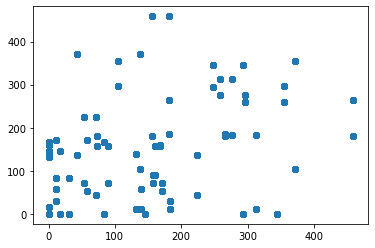

t+1 vs t-44


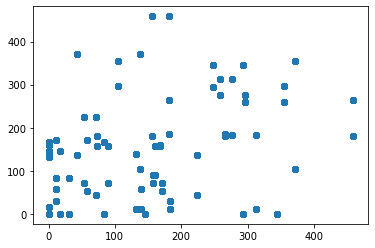

t+1 vs t-45


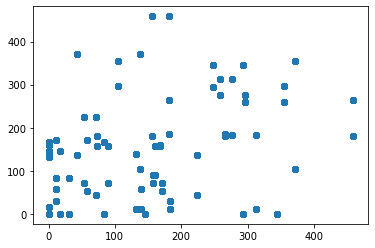

t+1 vs t-46


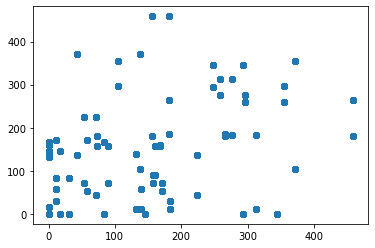

t+1 vs t-47


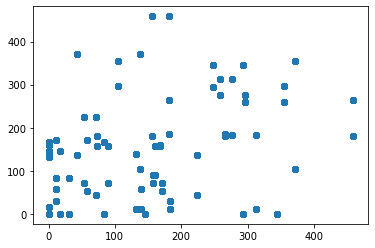

t+1 vs t-48


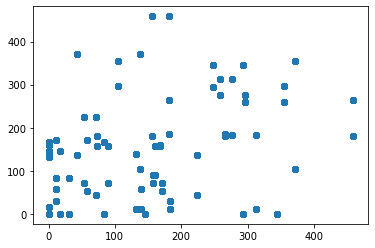

t+1 vs t-49


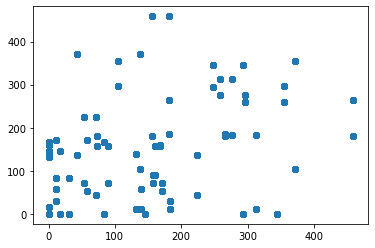

t+1 vs t-50


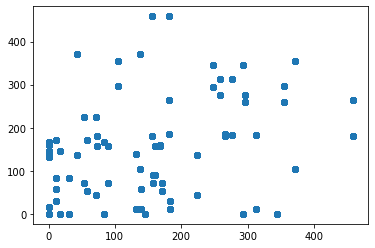

t+1 vs t-51


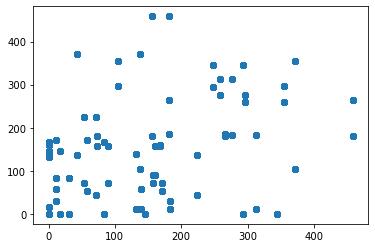

t+1 vs t-52


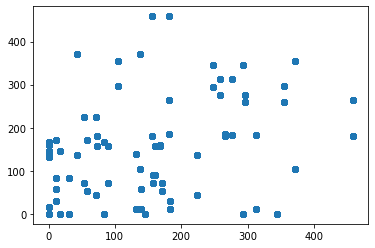

t+1 vs t-53


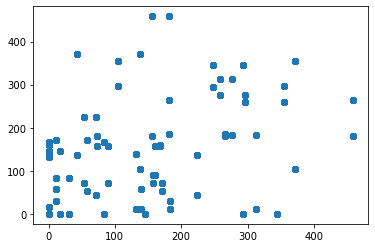

t+1 vs t-54


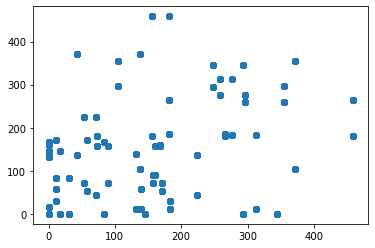

t+1 vs t-55


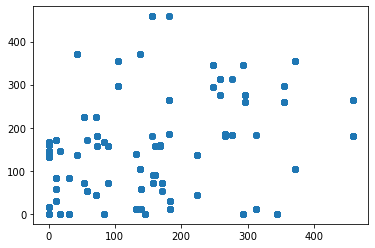

t+1 vs t-56


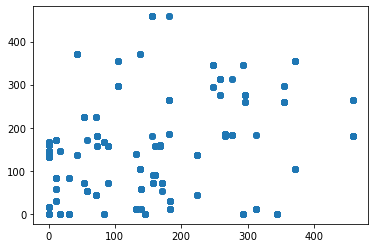

t+1 vs t-57


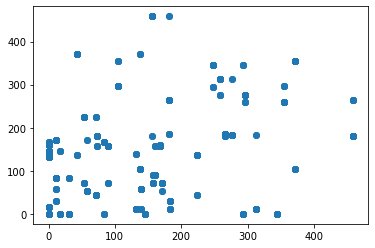

t+1 vs t-58


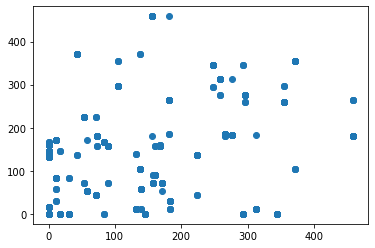

t+1 vs t-59


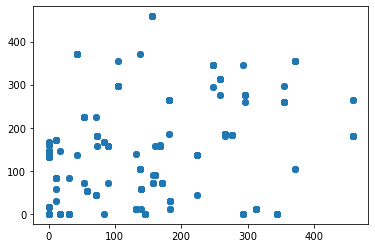

t+1 vs t-60


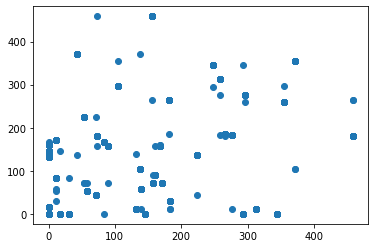

t+1 vs t-61


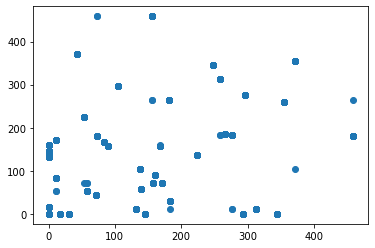

t+1 vs t-62


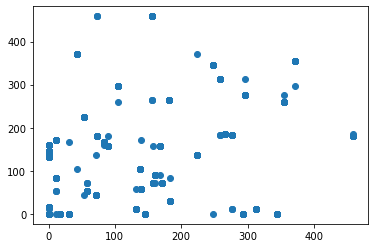

t+1 vs t-63


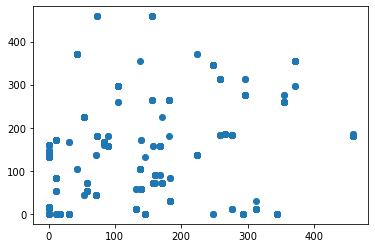

t+1 vs t-64


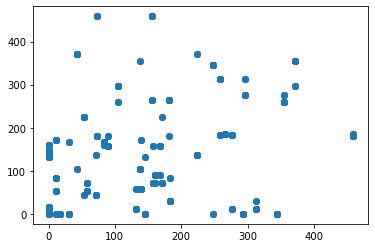

t+1 vs t-65


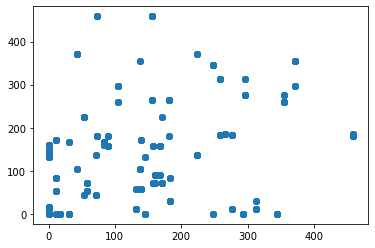

t+1 vs t-66


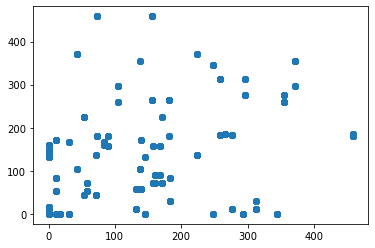

t+1 vs t-67


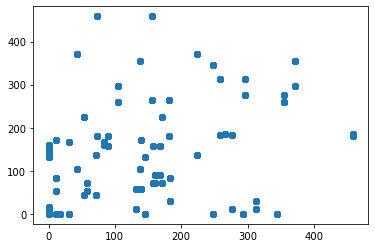

t+1 vs t-68


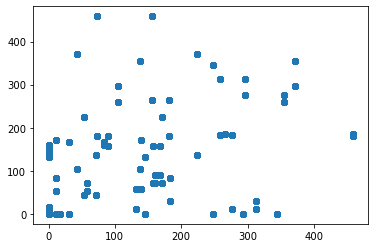

t+1 vs t-69


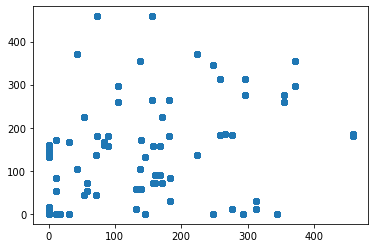

t+1 vs t-70


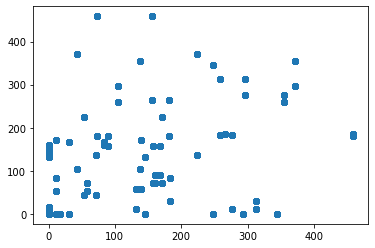

t+1 vs t-71


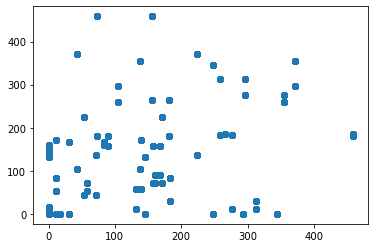

t+1 vs t-72


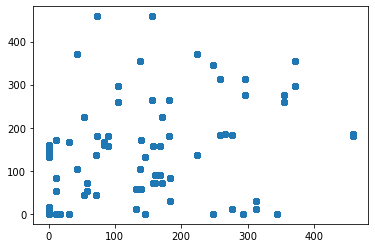

t+1 vs t-73


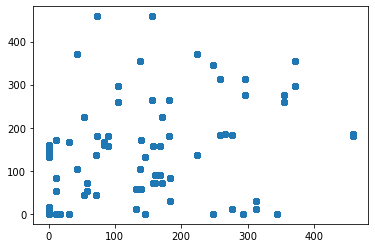

t+1 vs t-74


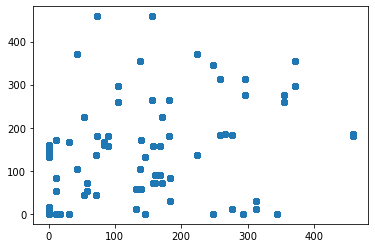

t+1 vs t-75


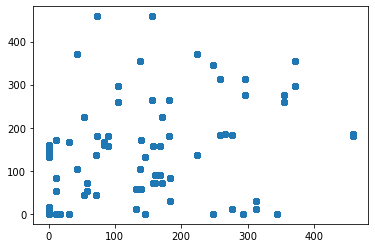

t+1 vs t-76


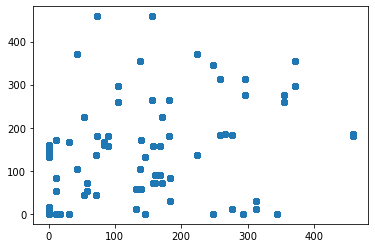

t+1 vs t-77


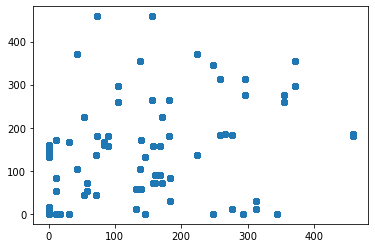

t+1 vs t-78


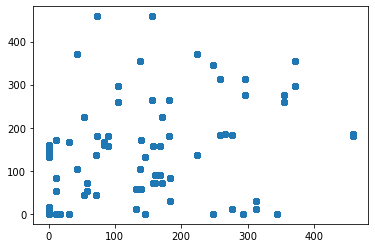

t+1 vs t-79


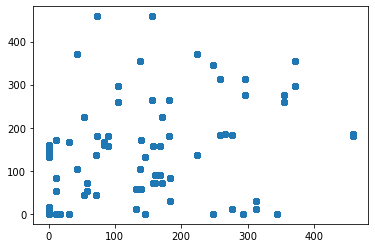

t+1 vs t-80


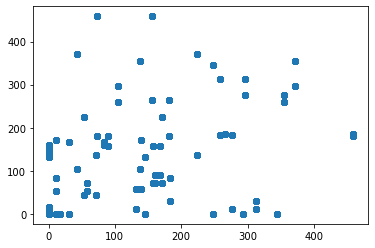

t+1 vs t-81


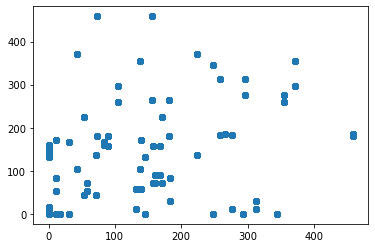

t+1 vs t-82


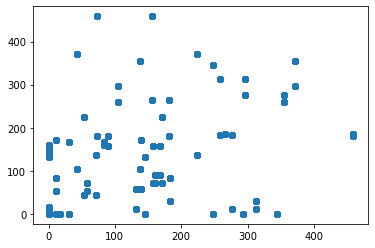

t+1 vs t-83


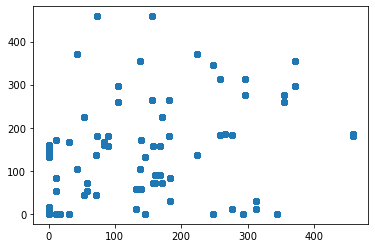

t+1 vs t-84


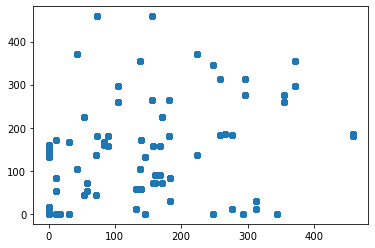

t+1 vs t-85


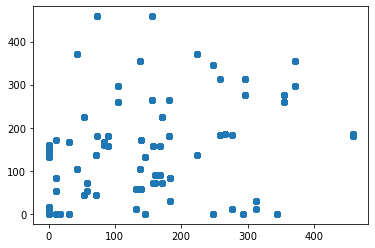

t+1 vs t-86


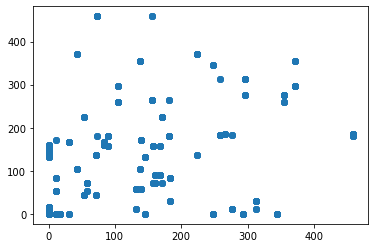

t+1 vs t-87


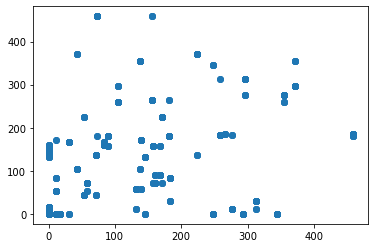

t+1 vs t-88


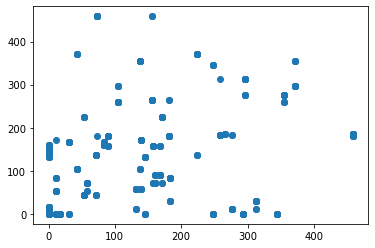

t+1 vs t-89


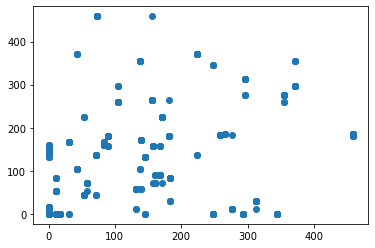

t+1 vs t-90


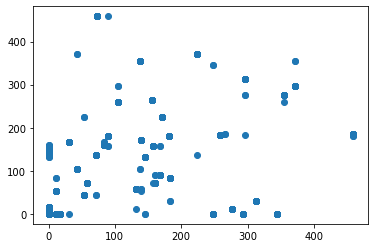

t+1 vs t-91


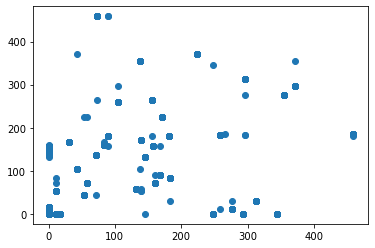

t+1 vs t-92


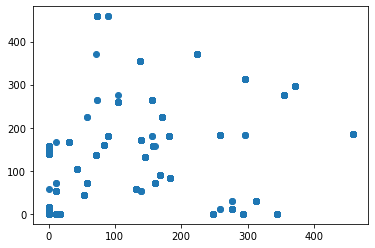

t+1 vs t-93


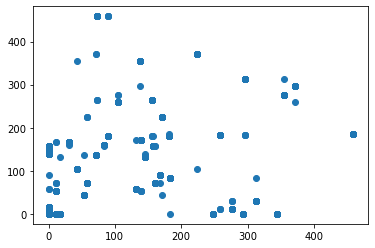

t+1 vs t-94


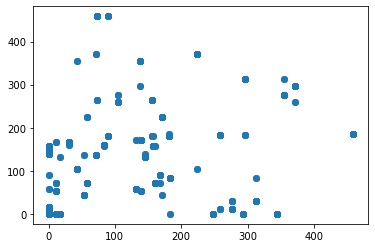

t+1 vs t-95


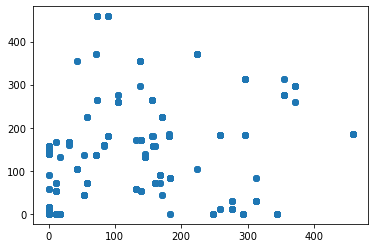

t+1 vs t-96


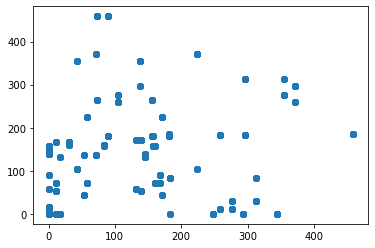

t+1 vs t-97


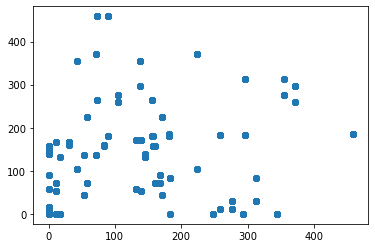

t+1 vs t-98


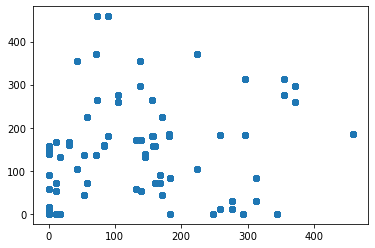

t+1 vs t-99


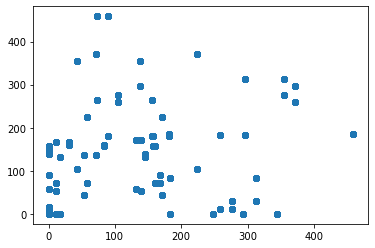

t+1 vs t-100


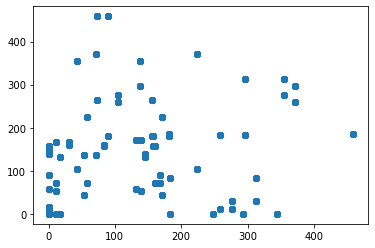

In [411]:
values = DataFrame(transacciones_mfilled_df.values)
# lags = transacciones_mfilled_df.size
lags = 100
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
for i in range(1,(lags + 1)):
	print('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
	pyplot.show()

In [412]:
"""
Vemos que hay buena correlacion desde y(t+1) hasta y(t-30)
"""

'\nVemos que hay buena correlacion desde y(t+1) hasta y(t-30)\n'

In [413]:
# 6. Time Series Autocorrelation Plots

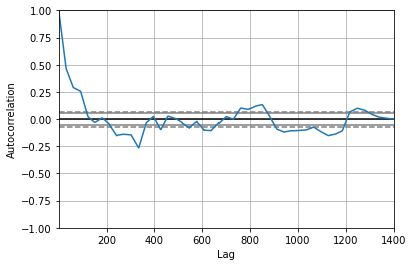

In [414]:
autocorrelation_plot(transacciones_mfilled_df)
pyplot.show()

In [415]:
"""
Vemos que hay una fuerte correlacion (corr > 0.5) entre y(t+1) hasta aproximadamente el lag 30; y correlacion estadisticamente
significativa hasta el lag 130.

Además a partir del lag 200 hay otros grupos de lags con correlación estadisticamente significativa.
Por tanto vamos a intentar modelar la serie temporal y ver cuanto error estamos cometiendo.
"""

'\nVemos que hay una fuerte correlacion (corr > 0.5) entre y(t+1) hasta aproximadamente el lag 30; y correlacion estadisticamente\nsignificativa hasta el lag 130.\n\nAdemás a partir del lag 200 hay otros grupos de lags con correlación estadisticamente significativa.\nPor tanto vamos a intentar modelar la serie temporal y ver cuanto error estamos cometiendo.\n'

In [593]:
# a continuacion vamos a estimar con prophet la serie temporal del importe con los datos del dataframe 
# 'transacciones_mfilled_df'
# vamos a entrenar la serie hasta la fecha de la ultima fila de 'transacciones_mfilled_df'

In [594]:
prophet_train_df = transacciones_mfilled_df.copy()
prophet_train_df

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [595]:
# Time Series Forecasting With Prophet in Python
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [596]:
# Fit Prophet Model

In [597]:
# para los datos de training tenemos que quitar los datos del mes en el que pedimos la estimacion.
# ya que si hacemos la estimacion al principio del mes el gasto en supermercados sera mucho menor respecto al gasto
# en supermercados de un mes completo similar

In [598]:
# hacemos una columna con el indice que se llame fecha
prophet_train_df['FECHA'] = prophet_train_df.index
prophet_train_df

IMPORTE      FECHA
2016-10-01    186.3 2016-10-01
2016-10-02    186.3 2016-10-02
2016-10-03    186.3 2016-10-03
2016-10-04    186.3 2016-10-04
2016-10-05    186.3 2016-10-05
...             ...        ...
2020-07-27    247.5 2020-07-27
2020-07-28    247.5 2020-07-28
2020-07-29    247.5 2020-07-29
2020-07-30    247.5 2020-07-30
2020-07-31    247.5 2020-07-31

[1400 rows x 2 columns]

In [599]:
# calculamos el ultimo año
last_year = prophet_train_df['FECHA'].dt.year.max()
last_year

2020

In [600]:
# calculamos el ultimo mes del ultimo año
last_month = prophet_train_df[str(last_year)]['FECHA'].dt.month.max()
last_month

<ipython-input-600-ffeaa67b850d>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  last_month = prophet_train_df[str(last_year)]['FECHA'].dt.month.max()


7

In [601]:
# hacemos un string con el ultimo año y mes para hacer una mascara
last_year_month = str(last_year) + '-' + str(last_month)
last_year_month

'2020-7'

In [602]:
maximum_date_obj = prophet_train_df[last_year_month]['FECHA'].min()
maximum_date_obj

<ipython-input-602-7ea07b9d02bc>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  maximum_date_obj = prophet_train_df[last_year_month]['FECHA'].min()


Timestamp('2020-07-01 00:00:00')

In [603]:
# hacemos una mascara para quitar las filas del ultimo mes
before_maximum_date_ser = prophet_train_df['FECHA'] < maximum_date_obj
before_maximum_date_ser

2016-10-01     True
2016-10-02     True
2016-10-03     True
2016-10-04     True
2016-10-05     True
              ...  
2020-07-27    False
2020-07-28    False
2020-07-29    False
2020-07-30    False
2020-07-31    False
Freq: D, Name: FECHA, Length: 1400, dtype: bool

In [604]:
# aplicamos la mascara
prophet_train_df = prophet_train_df.loc[before_maximum_date_ser]
prophet_train_df

IMPORTE      FECHA
2016-10-01   186.30 2016-10-01
2016-10-02   186.30 2016-10-02
2016-10-03   186.30 2016-10-03
2016-10-04   186.30 2016-10-04
2016-10-05   186.30 2016-10-05
...             ...        ...
2020-06-26   293.41 2020-06-26
2020-06-27   293.41 2020-06-27
2020-06-28   293.41 2020-06-28
2020-06-29   293.41 2020-06-29
2020-06-30   293.41 2020-06-30

[1369 rows x 2 columns]

In [605]:
# tambien tenemos que quitar del dataframe los datos del primer mes porque también puede estar no completo y nos
# desvirtua tambien la serie temporal del entrenamiento

In [606]:
# calculamos el primer año del dataframe
first_year = prophet_train_df['FECHA'].dt.year.min()
first_year

2016

In [607]:
# calculamos el primer mes del primer año
first_month = prophet_train_df[str(first_year)]['FECHA'].dt.month.min()
first_month

<ipython-input-607-baaeca60f1f1>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_month = prophet_train_df[str(first_year)]['FECHA'].dt.month.min()


10

In [608]:
# hacemos un string con el primer mes del primer año para hacer una mascara
first_year_month = str(first_year) + '-' + str(first_month)
first_year_month

'2016-10'

In [609]:
# calculamos la fecha minima para quedarnos con todas las transacciones del dataframe posteriores a esa fecha
minimum_date_obj = prophet_train_df[first_year_month]['FECHA'].max()
minimum_date_obj

<ipython-input-609-f3b3fea60e53>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  minimum_date_obj = prophet_train_df[first_year_month]['FECHA'].max()


Timestamp('2016-10-31 00:00:00')

In [610]:
# hago una mascara para quitar las filas del primer mes
after_minimum_date_ser = prophet_train_df['FECHA'] > minimum_date_obj
after_minimum_date_ser

2016-10-01    False
2016-10-02    False
2016-10-03    False
2016-10-04    False
2016-10-05    False
              ...  
2020-06-26     True
2020-06-27     True
2020-06-28     True
2020-06-29     True
2020-06-30     True
Freq: D, Name: FECHA, Length: 1369, dtype: bool

In [611]:
# aplicamos la mascara anterior
prophet_train_df = prophet_train_df.loc[after_minimum_date_ser]
prophet_train_df

IMPORTE      FECHA
2016-11-01   181.69 2016-11-01
2016-11-02   181.69 2016-11-02
2016-11-03   181.69 2016-11-03
2016-11-04   181.69 2016-11-04
2016-11-05   181.69 2016-11-05
...             ...        ...
2020-06-26   293.41 2020-06-26
2020-06-27   293.41 2020-06-27
2020-06-28   293.41 2020-06-28
2020-06-29   293.41 2020-06-29
2020-06-30   293.41 2020-06-30

[1338 rows x 2 columns]

In [612]:
# reordenamos las columnas de prophet_train_df
prophet_train_df = prophet_train_df[['FECHA', 'IMPORTE']]
prophet_train_df

FECHA  IMPORTE
2016-11-01 2016-11-01   181.69
2016-11-02 2016-11-02   181.69
2016-11-03 2016-11-03   181.69
2016-11-04 2016-11-04   181.69
2016-11-05 2016-11-05   181.69
...               ...      ...
2020-06-26 2020-06-26   293.41
2020-06-27 2020-06-27   293.41
2020-06-28 2020-06-28   293.41
2020-06-29 2020-06-29   293.41
2020-06-30 2020-06-30   293.41

[1338 rows x 2 columns]

In [613]:
# prepare expected column names
prophet_train_df.columns = ['ds', 'y']
prophet_train_df

ds       y
2016-11-01 2016-11-01  181.69
2016-11-02 2016-11-02  181.69
2016-11-03 2016-11-03  181.69
2016-11-04 2016-11-04  181.69
2016-11-05 2016-11-05  181.69
...               ...     ...
2020-06-26 2020-06-26  293.41
2020-06-27 2020-06-27  293.41
2020-06-28 2020-06-28  293.41
2020-06-29 2020-06-29  293.41
2020-06-30 2020-06-30  293.41

[1338 rows x 2 columns]

In [614]:
# reseteamos el indice del dataframe
prophet_train_df.reset_index(drop=True, inplace=True)
prophet_train_df

ds       y
0    2016-11-01  181.69
1    2016-11-02  181.69
2    2016-11-03  181.69
3    2016-11-04  181.69
4    2016-11-05  181.69
...         ...     ...
1333 2020-06-26  293.41
1334 2020-06-27  293.41
1335 2020-06-28  293.41
1336 2020-06-29  293.41
1337 2020-06-30  293.41

[1338 rows x 2 columns]

In [615]:
# esto no va en produccion

# comprobamos q 'ds' es 'datetime'
prophet_train_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [616]:
# define the model
model = Prophet()

In [617]:
# fit the model
model.fit(prophet_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [618]:
# esto no va en produccion

# vamos a pedirle a prophet que haga la prediccion hasta el ultimo dia del mes siguiente al de 'last_date_obj'
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [619]:
# vamos a pedirle a prophet que haga la prediccion hasta el ultimo dia del mes siguiente al de 'last_date_obj'
future_out_sample = transacciones_mfilled_df.copy()
future_out_sample

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [620]:
# hacemos una columna 'FECHA' con el indice
future_out_sample['FECHA'] = future_out_sample.index
future_out_sample

IMPORTE      FECHA
2016-10-01    186.3 2016-10-01
2016-10-02    186.3 2016-10-02
2016-10-03    186.3 2016-10-03
2016-10-04    186.3 2016-10-04
2016-10-05    186.3 2016-10-05
...             ...        ...
2020-07-27    247.5 2020-07-27
2020-07-28    247.5 2020-07-28
2020-07-29    247.5 2020-07-29
2020-07-30    247.5 2020-07-30
2020-07-31    247.5 2020-07-31

[1400 rows x 2 columns]

In [621]:
# hacemos un drop de la columna 'IMPORTE'
future_out_sample.drop(columns='IMPORTE', inplace=True)
future_out_sample

FECHA
2016-10-01 2016-10-01
2016-10-02 2016-10-02
2016-10-03 2016-10-03
2016-10-04 2016-10-04
2016-10-05 2016-10-05
...               ...
2020-07-27 2020-07-27
2020-07-28 2020-07-28
2020-07-29 2020-07-29
2020-07-30 2020-07-30
2020-07-31 2020-07-31

[1400 rows x 1 columns]

In [622]:
# calculamos la fecha del ultimo dia 
target_date_obj = last_date_obj + DateOffset(months=1) + MonthEnd(1)
target_date_obj

Timestamp('2020-08-31 00:00:00')

In [624]:
# calculamos el rango de fechas de la estimacion
idx = date_range(start=prophet_train_df.ds.min(), end=target_date_obj)
idx

DatetimeIndex(['2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
               '2016-11-09', '2016-11-10',
               ...
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30', '2020-08-31'],
              dtype='datetime64[ns]', length=1400, freq='D')

In [625]:
# esto no va en produccion

# comprobamos q el indice del dataframe es del formato 'DatetimeIndex'
type(future_out_sample.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [626]:
# rehacemos el indice de future_out_sample de acuerdo a las fechas de idx
future_out_sample = future_out_sample.reindex(idx)
future_out_sample

FECHA
2016-11-01 2016-11-01
2016-11-02 2016-11-02
2016-11-03 2016-11-03
2016-11-04 2016-11-04
2016-11-05 2016-11-05
...               ...
2020-08-27        NaT
2020-08-28        NaT
2020-08-29        NaT
2020-08-30        NaT
2020-08-31        NaT

[1400 rows x 1 columns]

In [627]:
# hacemos una columna con el nuevo indice
future_out_sample.reset_index(drop=False, inplace=True)
future_out_sample

index      FECHA
0    2016-11-01 2016-11-01
1    2016-11-02 2016-11-02
2    2016-11-03 2016-11-03
3    2016-11-04 2016-11-04
4    2016-11-05 2016-11-05
...         ...        ...
1395 2020-08-27        NaT
1396 2020-08-28        NaT
1397 2020-08-29        NaT
1398 2020-08-30        NaT
1399 2020-08-31        NaT

[1400 rows x 2 columns]

In [628]:
# hacemos un drop de la columna 'FECHA'
future_out_sample.drop(columns='FECHA', inplace=True)
future_out_sample

index
0    2016-11-01
1    2016-11-02
2    2016-11-03
3    2016-11-04
4    2016-11-05
...         ...
1395 2020-08-27
1396 2020-08-28
1397 2020-08-29
1398 2020-08-30
1399 2020-08-31

[1400 rows x 1 columns]

In [629]:
# renombramos la columna del dataframe a 'ds'
future_out_sample.columns = ['ds']
future_out_sample

ds
0    2016-11-01
1    2016-11-02
2    2016-11-03
3    2016-11-04
4    2016-11-05
...         ...
1395 2020-08-27
1396 2020-08-28
1397 2020-08-29
1398 2020-08-30
1399 2020-08-31

[1400 rows x 1 columns]

In [630]:
# esto no va en produccion

# comprobamos que ds es del tipo datetime64
future_out_sample.dtypes

ds    datetime64[ns]
dtype: object

In [631]:
# use the model to make a forecast
forecast_df = model.predict(future_out_sample)

In [632]:
# esto no va en produccion

# summarize the forecast
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds        yhat  yhat_lower  yhat_upper
0    2016-11-01  273.279857  177.542789  366.725987
1    2016-11-02  272.589545  171.272605  361.351752
2    2016-11-03  274.463645  173.543019  381.444499
3    2016-11-04  275.085406  179.106627  366.914053
4    2016-11-05  272.061844  178.835183  370.353944
...         ...         ...         ...         ...
1395 2020-08-27  193.905537   90.219294  290.485997
1396 2020-08-28  190.499738   91.210587  285.021544
1397 2020-08-29  183.537251   87.012028  273.457776
1398 2020-08-30  179.930245   89.873731  280.633125
1399 2020-08-31  174.913117   77.090526  278.589450

[1400 rows x 4 columns]

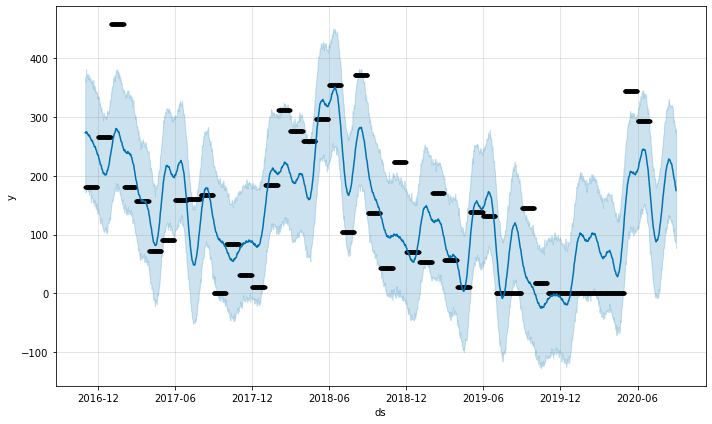

In [633]:
# esto no va en produccion

# plot forecast
model.plot(forecast_df)
pyplot.show()

In [634]:
# nos quedamos con las columnas 'ds' y 'yhat'
forecast_df = forecast_df[['ds', 'yhat']]
forecast_df

ds        yhat
0    2016-11-01  273.279857
1    2016-11-02  272.589545
2    2016-11-03  274.463645
3    2016-11-04  275.085406
4    2016-11-05  272.061844
...         ...         ...
1395 2020-08-27  193.905537
1396 2020-08-28  190.499738
1397 2020-08-29  183.537251
1398 2020-08-30  179.930245
1399 2020-08-31  174.913117

[1400 rows x 2 columns]

In [635]:
# nos quedamos con las filas del ultimo mes que es para el que hemos hecho la prediccion
# calculamos el ultimo año
last_year = forecast_df['ds'].dt.year.max()
last_year

2020

In [636]:
# calculamos el ultimo mes del ultimo año creandonos un dataframe donde al final tendremos la estimacion del ultimo mes
prediction_df = forecast_df.copy()
prediction_df

ds        yhat
0    2016-11-01  273.279857
1    2016-11-02  272.589545
2    2016-11-03  274.463645
3    2016-11-04  275.085406
4    2016-11-05  272.061844
...         ...         ...
1395 2020-08-27  193.905537
1396 2020-08-28  190.499738
1397 2020-08-29  183.537251
1398 2020-08-30  179.930245
1399 2020-08-31  174.913117

[1400 rows x 2 columns]

In [637]:
# rehacemos el indice con la FECHA columna 'ds'
prediction_df.set_index('ds', drop=False, inplace=True)
prediction_df

ds        yhat
ds                               
2016-11-01 2016-11-01  273.279857
2016-11-02 2016-11-02  272.589545
2016-11-03 2016-11-03  274.463645
2016-11-04 2016-11-04  275.085406
2016-11-05 2016-11-05  272.061844
...               ...         ...
2020-08-27 2020-08-27  193.905537
2020-08-28 2020-08-28  190.499738
2020-08-29 2020-08-29  183.537251
2020-08-30 2020-08-30  179.930245
2020-08-31 2020-08-31  174.913117

[1400 rows x 2 columns]

In [638]:
# calculamos el ultimo mes del ultimo año
last_month = prediction_df[str(last_year)]['ds'].dt.month.max()
last_month

<ipython-input-638-a34f31bb08de>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  last_month = prediction_df[str(last_year)]['ds'].dt.month.max()


8

In [639]:
# hago una variable str con el ultimo año y el ultimo mes
last_year_month = str(last_year) + '-' + str(last_month)
last_year_month

'2020-8'

In [640]:
# calculo la fecha minima a partir de la cual me quedo con los datos
minimum_date_obj = prediction_df[last_year_month]['ds'].min()
minimum_date_obj

<ipython-input-640-63931a1604df>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  minimum_date_obj = prediction_df[last_year_month]['ds'].min()


Timestamp('2020-08-01 00:00:00')

In [641]:
# hago una mascara para quedarme con las filas del ultimo año y del ultimo mes
after_minimum_date_ser = prediction_df['ds'] >= minimum_date_obj
after_minimum_date_ser

ds
2016-11-01    False
2016-11-02    False
2016-11-03    False
2016-11-04    False
2016-11-05    False
              ...  
2020-08-27     True
2020-08-28     True
2020-08-29     True
2020-08-30     True
2020-08-31     True
Name: ds, Length: 1400, dtype: bool

In [642]:
# aplico la mascara para quedarme finalmente con las filas de las trasacciones del ultimo mes y del ultimo año
prediction_df = prediction_df.loc[after_minimum_date_ser]
prediction_df

ds        yhat
ds                               
2020-08-01 2020-08-01  168.912967
2020-08-02 2020-08-02  176.791275
2020-08-03 2020-08-03  182.934473
2020-08-04 2020-08-04  188.485370
2020-08-05 2020-08-05  194.236665
...               ...         ...
2020-08-27 2020-08-27  193.905537
2020-08-28 2020-08-28  190.499738
2020-08-29 2020-08-29  183.537251
2020-08-30 2020-08-30  179.930245
2020-08-31 2020-08-31  174.913117

[31 rows x 2 columns]

In [643]:
# hacemos un drop de la columna con las fechas
prediction_df.drop(columns='ds', inplace=True)
prediction_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


yhat
ds                    
2020-08-01  168.912967
2020-08-02  176.791275
2020-08-03  182.934473
2020-08-04  188.485370
2020-08-05  194.236665
...                ...
2020-08-27  193.905537
2020-08-28  190.499738
2020-08-29  183.537251
2020-08-30  179.930245
2020-08-31  174.913117

[31 rows x 1 columns]

In [645]:
# damos la prediccion final como la media de valores predichos para el mes
final_prediction = float(prediction_df.mean())
final_prediction

205.7720258153242

In [646]:
# a continuacion comprobamos que la media de transacciones en supermercado desde el dia 1 del mes anterior es mayor que 0
# para poder dar la prediccion como valida

In [647]:
# esto no va en produccion

transacciones_mfilled_df

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [697]:
# esto no va en produccion

last_date_obj

Timestamp('2020-07-26 00:00:00')

In [652]:
# calculamos la fecha del primer dia del mes anterior a la peticion
target_date_obj = last_date_obj - DateOffset(months=1) - MonthBegin(1)
target_date_obj

Timestamp('2020-06-01 00:00:00')

In [655]:
# hago una mascara para solo quedarme con las filas del dataframe a partir de target_date_obj
after_target_date_ser = transacciones_mfilled_df.index >= target_date_obj
after_target_date_ser

array([False, False, False, ...,  True,  True,  True])

In [656]:
# aplico la mascara
final_mean_df = transacciones_mfilled_df.loc[after_target_date_ser]
final_mean_df

IMPORTE
2020-06-01   293.41
2020-06-02   293.41
2020-06-03   293.41
2020-06-04   293.41
2020-06-05   293.41
...             ...
2020-07-27   247.50
2020-07-28   247.50
2020-07-29   247.50
2020-07-30   247.50
2020-07-31   247.50

[61 rows x 1 columns]

In [688]:
# calculo la media final desde el dia 1 del mes anterior a la peticion
final_mean = float(final_mean_df.mean())
final_mean

270.0786885245901

In [690]:
# hago el chequeo final de que la prediccion sea valida

valid_prediction = False

if final_mean != 0:
    valid_prediction = True
elif float(final_prediction) == 0:
    valid_prediction = True

valid_prediction

True

In [691]:
# hago un dataframe para calcular el año y mes de la prediccion
final_date_month_df = prediction_df.copy()
final_date_month_df

yhat
ds                    
2020-08-01  168.912967
2020-08-02  176.791275
2020-08-03  182.934473
2020-08-04  188.485370
2020-08-05  194.236665
...                ...
2020-08-27  193.905537
2020-08-28  190.499738
2020-08-29  183.537251
2020-08-30  179.930245
2020-08-31  174.913117

[31 rows x 1 columns]

In [692]:
# hacemos una columna con el indice
final_date_month_df.reset_index(inplace=True)
final_date_month_df

ds        yhat
0  2020-08-01  168.912967
1  2020-08-02  176.791275
2  2020-08-03  182.934473
3  2020-08-04  188.485370
4  2020-08-05  194.236665
..        ...         ...
26 2020-08-27  193.905537
27 2020-08-28  190.499738
28 2020-08-29  183.537251
29 2020-08-30  179.930245
30 2020-08-31  174.913117

[31 rows x 2 columns]

In [693]:
# calculo el año de la prediccion
final_year = final_date_month_df['ds'].dt.year.max()
final_year

2020

In [694]:
# calculo el mes de la prediccion
final_month = final_date_month_df['ds'].dt.month.max()
final_month

8

In [695]:
# paso de numero a nombre el mes de la prediccion
datetime_object = datetime.strptime(str(final_month), "%m")
final_month_str = datetime_object.strftime("%B")
final_month_str

In [696]:
print('Tus gasto aproximado en supermercados en ' + final_month_str + '-' + str(final_year) +
      ' sera: ' + str(5*round(final_prediction/5)) + ' eur')
print('Prediccion válida: ' +  str(valid_prediction))

Tus gasto aproximado en supermercados en August-2020 sera: 205 eur
Prediccion válida: True
